# Freedom of Information Requests in the Region of Waterloo

One of the Region of Waterloo initiatives is [Open Data](https://rowopendata-rmw.opendata.arcgis.com/). With it, the Region strives to be open, transparent, and accountable to citizens. It shares its data for everyone to use and republish with few restrictions. The data is provided in machine-readable format.

Searching the Region's Open Data Portal, one can find the Freedom of Information Requests (FOIR) data set. This data set spans 18 years (1999-2016).

In this repository, you will find a jupyter notebook that does a thorough job at describing the FOIR set. Specially from the side of descriptive statistics, visualization, natural langauge processing (NLP), and topic modeling (LSA, LDA, LSI).

You will also find a [file](https://github.com/brodriguezmilla/foir/blob/master/foir_all_figures.png) that encompasses the figures and images produced in the notebook, a.k.a., all the neat results.

Towards the end of the notebook, we test and compare some machine learning (ML) models, including the use of pipelines and GridSearchCV, albeit we don't do a deep analysis.

So let's find what this dataset holds as there is always value in data! And as a bonus, let's see if we have better "luck" using machine learning to predict the outcome of a request based on the previously made decisions.

## Overview of Notebook 

There is a lot of material in this notebook. And pretty much, you can jump to the section of your interest, therefore, it is better is we give you a short summary of what is ahead.

- Get to know the data
    * We look at the files, we merge them, and clean them if necessary.
    * We have five main columns: one is the request ID, three columns have categorical data, and one has the summary of the request itself (plain text).
    * Of those with categorical data, decision made, source (a.k.a., requester), and request type, can we somehow reduce the number of categories (spoiler alert: yes).
- Descriptive Analysis
    * There are about 11 types of decisions for six different types of sources.
        * How many requests per type of decision?
        * How are the decisions split based on the source? Are some sources more "lucky" than others? Spoiler alert: yes, though we don't know the reason.
        * How is each decision split among the sources? 
        * For the main types of decisions (All information disclosed, Information disclosed in part, No information disclosed), how are they split among the sources?
- Natural Language Processing (NLP) - Analyzing the summary of request
    * Before analyzing any text with NLP, one needs to go over some steps, which can vary depending on the goal:
        * Parse text, tokenize it, remove symbols, remove stop words, remove punctuation, convert tokens to lowercase, remove short words, and lemmatize the tokens. We use both NLTK and spaCy.
    * n-grams. We take a look at the most frequent unigrams, bigrams, trigrams, and n-grams (4-5).
    * WordClouds. They are not only pretty, they are also useful. Why is a word/phrase so important!?
    * Let's take six of these frequent phrases and find if there is any correlation with the decision taken.
    * Summary of request statistics. With how much text are we working? How long are the requests before and after tokenization? (Spoiler alert: seven tokens is the median per request. Ouch!)
    * Part-of-Speech (POS) tagging of the requests. Nouns, verbs?
    * Topic Modeling
         * Here with do LSA and LDA Analysis using Bokeh, scikit-learn, and t-SNE.
         * We also try LDA Analysis using Gensim and pyLDAvis.
- Machine Learning (ML)
    * Here we compare the accuracies of eight classifiers, RandomForest, LinearSVC, MultinomialNB, LogisticRegression, SVC, KNeighbors, SGDC, and DecisionTree, using pipelines, GridSearchCV, confusion matrices, and classification reports.
    * We compare two vectorizers, Count vectorizer and tf-idf vectorizer.
    * Given that some of our decisions have less than 15 instances and that we also have an unbalanced case, we look at other ways to optimize this. For example, a) we keep decisions with over 15 instances, b) we merge our 11 type of decisions into three main bins (full, partial, or no info released), and c) we remove cases where no decision was made (withdrawn or abandoned, which we name it as the independent case).
    * And with all of this, our best score goes up to... 51%


So, let's start!

## Importing, cleaning, and getting to know the data

First, let's import few must have libraries for such task:

* pandas - to be able to work work dataframes
* matplot and seaborn - to make plots
* numpy - for scientific computing


In [73]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from os import listdir
from os.path import isfile, join

%matplotlib inline

Files are similarly named, e.g., *Freedom_of_Information_Requests__1999.csv*, except that they have different years, from 1999 to 2016. So let's add them to a pandas dataframe.

In [74]:
counter = 0
df = {}   # Dataframe of dataframes

mypath = 'data/files/'

for file in listdir(mypath):
    f = join(mypath, file)
    if isfile(f):
        df[counter] = pd.read_csv(f, encoding='utf-8')
        counter += 1

In [75]:
# Number of files read and turned into dataframes
len(df)

26

Here is how the first few lines of the first file look like,

In [76]:
df[0].head()

Request_Number          Request_Type               Source  \
0           98001  Personal Information               Public   
1           98002   General Information               Public   
2           98003   General Information             Business   
3           98004   General Information  Individual by Agent   
4           98005  Personal Information               Public   

                                  Summary_of_Request             Decision  \
0  GWA file, specifically agreements, cheques and...        All disclosed   
1  Records related to construction on {company na...  Partly non-existent   
2  Information regarding damage to Regional facil...  Partly non-existent   
3  Identity of the Sunnyside Home employee who wi...    Nothing disclosed   
4  Regional Solicitor's file for {name removed} r...      Partly exempted   

   OBJECTID  
0         0  
1         1  
2         2  
3         3  
4         4

Let's find out if all the files have the same number of columns:

In [77]:
for y in range(0, len(df)):
    print(df[y].shape)

(22, 6)
(27, 6)
(23, 6)
(41, 6)
(33, 6)
(24, 6)
(43, 6)
(22, 6)
(22, 6)
(29, 6)
(30, 6)
(19, 6)
(25, 6)
(43, 6)
(24, 6)
(82, 6)
(20, 6)
(39, 6)
(30, 6)
(17, 6)
(26, 6)
(68, 6)
(53, 6)
(26, 6)
(54, 6)
(60, 6)


In [78]:
# Number of columns of the first file
df[0].shape[1]

6

While all the files have the same number of columns, it is possible that over the years, those columns would not be the same, that the structure of those files has changed. We need to verify that we can combine all those files into a single stacked dataframe.

In [79]:
# How does one get the name of the columns? Call df.columns.values
column_names_arr = df[0].columns.values
print(column_names_arr)
print(column_names_arr[5])

['Request_Number' 'Request_Type' 'Source' 'Summary_of_Request' 'Decision'
 'OBJECTID']
OBJECTID


In [80]:
# Start an array with the names of the columns for all the files.
column_names_arr = {}
for y in range(0, len(df)):
    column_names_arr[y] = df[y].columns.values

      

In [81]:
# Find out if they have the same columns or not. 
for i in range(0, len(df)-1):
    for j in range(0, df[0].shape[1]):
        assert column_names_arr[i][j] == column_names_arr[i + 1][j],\
        "The column names are different at ({0}, {1}) and ({2}, {3}): '{4}' vs. '{5}'".format(
        i, j, i + 1, j, column_names_arr[i][j], column_names_arr[i + 1][j])
        

AssertionError: The column names are different at (9, 0) and (10, 0): 'Request_Number' vs. 'Request_Number:'

Let's do the same, but this time, use all lower case, and strip spaces and colons.

In [82]:
for i in range(0, len(df)-1):
    for j in range(0, df[0].shape[1]):
        assert column_names_arr[i][j].lower().strip(' :') == column_names_arr[i + 1][j].lower().strip(' :'), \
        "The column names are different at ({0}, {1}) and ({2}, {3}): '{4}' vs. '{5}'".format(
        i, j, i + 1, j, column_names_arr[i][j], column_names_arr[i + 1][j])  
        

In [83]:
# As an example of what the stripping does:
i = 14
j = 0
print("The column name of ({0}, {1}) before .lower().strip(' :') is '{2}', and after is '{3}'.".format(
      i, j, column_names_arr[i][j], column_names_arr[i][j].lower().strip(' :')))

print("The column name of ({0}, {1}) before .lower().strip(' :') is '{2}', and after is '{3}'.".format(
      i + 1, j, column_names_arr[i + 1][j], column_names_arr[i + 1][j].lower().strip(' :')))

The column name of (14, 0) before .lower().strip(' :') is 'Request_Number', and after is 'request_number'.
The column name of (15, 0) before .lower().strip(' :') is 'Request_Number', and after is 'request_number'.


In [84]:
df[0].columns.values[0]

'Request_Number'

Now that we know that all columns are the same, let's consolidate the names directly in the dataframe:

In [85]:
for i in range(0, 18):
    for j in range(0, df[0].shape[1]):
        df[i].columns.values[j] = df[i].columns.values[j].strip(' :')
        

In [86]:
# Check if it worked
i = 14
j = 0
print(df[i].columns.values[j])
print(df[i + 1].columns.values[j])

Request_Number
Request_Number


We can now proceed to concatenate the dataframes into a single one:

In [87]:
adf = pd.concat(df, ignore_index=True)

In [88]:
# Check shape
adf.shape

(902, 6)

In [89]:
adf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 902 entries, 0 to 901
Data columns (total 6 columns):
Request_Number        902 non-null int64
Request_Type          902 non-null object
Source                902 non-null object
Summary_of_Request    902 non-null object
Decision              902 non-null object
OBJECTID              902 non-null int64
dtypes: int64(2), object(4)
memory usage: 42.4+ KB


On further inspection, the OBJECTID column is just the order number in which the request arrived in a particular year, without any further meaning. So I will proceed to drop that column.

In [90]:
adf = adf.drop(columns=['OBJECTID'])

In [91]:
adf.head(3)

Request_Number          Request_Type    Source  \
0           98001  Personal Information    Public   
1           98002   General Information    Public   
2           98003   General Information  Business   

                                  Summary_of_Request             Decision  
0  GWA file, specifically agreements, cheques and...        All disclosed  
1  Records related to construction on {company na...  Partly non-existent  
2  Information regarding damage to Regional facil...  Partly non-existent

Before diving into the Machine Learning aspect of this, or any other analysis, one needs to know the data better!

*Request_Number* has the file number, unique to each case. *Summary_of_Request* has, as the name says, the summarized version of the request, written by a clerk at the office. 

For the columns, *Request_Type*, *Source*, and *Decision*, it seems that we have a limited number of options, so let's see how many unique values they have.

Let's start with *Request_Type*:

In [92]:
adf.Request_Type.unique()

array(['Personal Information', 'General Information',
       'Personal Health Information',
       'Personal Health Information/General Informaiton',
       'Personal Health Information/General Information',
       'General Records', 'Correction', 'Personal', 'General ',
       'Personal Health Information ', 'General', 'Personal ',
       'Personal Information/General Information', 'Personal information'],
      dtype=object)

In [93]:
print(adf.Request_Type.nunique())
adf.Request_Type.value_counts()

14


General Information                                439
Personal Information                               262
General                                             57
General Records                                     36
Personal                                            25
Personal                                            22
General                                             19
Personal Health Information/General Information     16
Personal information                                13
Correction                                           7
Personal Information/General Information             2
Personal Health Information                          2
Personal Health Information                          1
Personal Health Information/General Informaiton      1
Name: Request_Type, dtype: int64

We see that given typos and extra white spaces, these categories can be combined. 

In [94]:
adf['Request_Type'] = adf['Request_Type'].str.strip()
print(adf.Request_Type.nunique())
adf.Request_Type.value_counts()

11


General Information                                439
Personal Information                               262
General                                             76
Personal                                            47
General Records                                     36
Personal Health Information/General Information     16
Personal information                                13
Correction                                           7
Personal Health Information                          3
Personal Information/General Information             2
Personal Health Information/General Informaiton      1
Name: Request_Type, dtype: int64

In [95]:
adf['Request_Type'] = adf['Request_Type'].str.replace('Informaiton', 'Information')

In [96]:
adf['Request_Type'] = adf['Request_Type'].str.replace('information', 'Information')

On further inspection, one finds out that the terminology evolved over time. For example, in the early years, it was called *General Information*, then later on it was called *General Records*, and nowadays, it is called just *General*. (You can uncomment the next few cells to verify that.)

In [97]:
#adf[(adf['Request_Type'] == 'General Information') | (adf['Request_Type'] == 'General Records')]

In [98]:
#adf[(adf['Request_Type'] == 'General Information') | (adf['Request_Type'] == 'General')]

It is the same case for *Personal Information* and *Personal*. 

In [99]:
#adf[(adf['Request_Type'] == 'Personal Information') | (adf['Request_Type'] =='Personal')]

We can then proceed to combine those categories.

In [100]:
adf['Request_Type'] = adf['Request_Type'].str.replace('Personal Information', 'Personal')

In [101]:
adf['Request_Type'] = adf['Request_Type'].str.replace('General Information', 'General')

In [102]:
adf['Request_Type'] = adf['Request_Type'].str.replace('General Records', 'General')

In [103]:
print(adf.Request_Type.nunique())
adf.Request_Type.value_counts()

6


General                                551
Personal                               322
Personal Health Information/General     17
Correction                               7
Personal Health Information              3
Personal/General                         2
Name: Request_Type, dtype: int64

How about other categories?

In [104]:
adf[(adf['Request_Type'] == 'Personal Health Information/General')
    | (adf['Request_Type'] =='Personal Health Information')
    | (adf['Request_Type'] =='Personal/General')]


Request_Number                         Request_Type  \
59          2006011          Personal Health Information   
67          2006019  Personal Health Information/General   
75          2012004  Personal Health Information/General   
91          2012020  Personal Health Information/General   
108         2012037  Personal Health Information/General   
146         2007001  Personal Health Information/General   
150         2007005  Personal Health Information/General   
153         2007008  Personal Health Information/General   
154         2007009  Personal Health Information/General   
157         2007012  Personal Health Information/General   
228         2005016  Personal Health Information/General   
234         2005022  Personal Health Information/General   
240         2004006  Personal Health Information/General   
247         2004013  Personal Health Information/General   
270         2010014  Personal Health Information/General   
391         2015032          Personal Health Information   
396         2015037          Personal Health Information   
516         2002008                     Personal/General   
527         2002019                     Personal/General   
535         2009007  Personal Health Information/General   
584         2008017  Personal Health Information/General   
592         2008025  Personal Health Information/General   

                   Source                                 Summary_of_Request  \
59                 Public  Ambulance Call Report for Emergency Medical Se...   
67                 Public                 Rabies control investigation file.   
75                 Public  Rabies control investigation records regarding...   
91                 Public              Rabies control investigation records.   
108   Individual by Agent  Rabies control inspection records for incident...   
146                Public  Public Health investigation file regarding e-c...   
150                Public  Public Health investigation records regarding ...   
153   Individual by Agent  Rabies control investigation records affecting...   
154   Individual by Agent  Food borne illness investigation at {location ...   
157   Individual by Agent  Rabies control investigation regarding an inci...   
228   Individual by Agent  Food premise inspections of {location removed}...   
234   Individual by Agent  Rabies control investigation file regarding do...   
240                Public  Rabies control investigation from April 2003 r...   
247   Individual by Agent                 Rabies control investigation file.   
270   Individual by Agent  Food-borne Illness investigation regarding e. ...   
391  Individual by agent   Investigation file and notes of Natan Somer, P...   
396            Individual  Copy of a report from the early 1990's about a...   
516   Individual by Agent  Rabies incident report records regarding May 2...   
527   Individual by Agent  Food-borne illness incident records for {locat...   
535   Individual by Agent  Records regarding cause of death and recalled ...   
584   Individual by Agent                Rabies control investigation file.    
592   Individual by Agent  Emergency Medical Services and Waterloo Region...   

                                            Decision  
59                                         Withdrawn  
67                                     All disclosed  
75                                   Partly exempted  
91                                   Partly exempted  
108                                  Partly exempted  
146                                  Partly exempted  
150                                  Partly exempted  
153                                  Partly exempted  
154                                 No record exists  
157                                  Partly exempted  
228                                    All disclosed  
234                                  Partly exempted  
240                                  Partly exempted  
247          

While there may still be room to combine those categories even further, as *Personal Health Information/General* and *Personal Health Information* seem to involve cases of food-borne illnesses and rabies control investigations, I chose not to. 

This was given that if one takes a look at other requests involving the words *rabies* or *food borne* (see below), those requests turn out to be filed into other categories, such as general or personal. Whether there is a clear difference, or whether it depends on the clerk filing the request, it is unknown to me.

In [105]:
adf[(adf['Summary_of_Request'].str.contains('rabies')) | (adf['Summary_of_Request'].str.contains('Rabies'))]

Request_Number                         Request_Type               Source  \
34            99013                              General  Individual by Agent   
67          2006019  Personal Health Information/General               Public   
75          2012004  Personal Health Information/General               Public   
91          2012020  Personal Health Information/General               Public   
108         2012037  Personal Health Information/General  Individual by Agent   
153         2007008  Personal Health Information/General  Individual by Agent   
157         2007012  Personal Health Information/General  Individual by Agent   
168         2007023                              General  Individual by Agent   
178         2011009                              General  Individual by Agent   
219         2005007                              General  Individual by Agent   
222         2005010                              General             Business   
234         2005022  Personal Health Information/General  Individual by Agent   
240         2004006  Personal Health Information/General               Public   
247         2004013  Personal Health Information/General  Individual by Agent   
413         2003011                             Personal  Individual by Agent   
414         2003012                             Personal  Individual by Agent   
424         2003022                              General               Public   
495         2016069                              General  Individual by agent   
516         2002008                     Personal/General  Individual by Agent   
549         2009021                              General               Public   
584         2008017  Personal Health Information/General  Individual by Agent   

                                    Summary_of_Request  \
34   Rabies control records related to dog bite aff...   
67                  Rabies control investigation file.   
75   Rabies control investigation records regarding...   
91               Rabies control investigation records.   
108  Rabies control inspection records for incident...   
153  Rabies control investigation records affecting...   
157  Rabies control investigation regarding an inci...   
168  Rabies control inspection records involving ca...   
178                 Rabies control investigation file.   
219  Owner name and address in rabies control inves...   
222  Rabies control investigation file for incident...   
234  Rabies control investigation file regarding do...   
240  Rabies control investigation from April 2003 r...   
247                 Rabies control investigation file.   
413  Rabies control records from an incident occurr...   
414  Rabies control records for incident that occur...   
424  Rabies control investigation records regarding...   
495  Copy of {name removed} rabies file including a...   
516  Rabies incident report records regarding May 2...   
549  Dog owner's identity contained in rabies contr...   
584                Rabies control investigation file.    

                          Decision  
34                 Partly exempted  
67                   All disclosed  
75                 Partly exempted  
91                 Partly exempted  
108                Partly exempted  
153                Partly exempted  
157                Partly exempted  
168                Partly exempted  
178                  All disclosed  
219                Partly exempted  
222                Partly exempted  
234                Partly exempted  
240                Partly exempted  
247                Partly exempted  
413                Partly exempted  
414                  Forwarded out  
424                Partly exempted  
495  Information disclosed in part  
516                  All disclosed  
549                  All disclosed  
584                Partly exempted

In [106]:
adf[(adf['Summary_of_Request'].str.contains('Food-borne')) 
    | (adf['Summary_of_Request'].str.contains('Food borne'))
    | (adf['Summary_of_Request'].str.contains('food borne'))
    | (adf['Summary_of_Request'].str.contains('food-borne'))]

Request_Number                         Request_Type               Source  \
124         2013012                              General               Public   
149         2007004                              General    Business by Agent   
154         2007009  Personal Health Information/General  Individual by Agent   
165         2007020                              General    Business by Agent   
228         2005016  Personal Health Information/General  Individual by Agent   
249         2004015                             Personal  Individual by Agent   
270         2010014  Personal Health Information/General  Individual by Agent   
320         2000005                             Personal               Public   
321         2000006                              General               Public   
323         2000008                             Personal               Public   
406         2003004                             Personal  Individual by Agent   
527         2002019                     Personal/General  Individual by Agent   
599           97002                              General             Business   

                                    Summary_of_Request          Decision  
124  Food-borne illness complaint records for {comp...     All disclosed  
149  Food-borne illness investigation at {company r...     All disclosed  
154  Food borne illness investigation at {location ...  No record exists  
165  Food-borne illness complaint investigation reg...   Partly exempted  
228  Food premise inspections of {location removed}...     All disclosed  
249  Food-borne illness incident records from {loca...     All disclosed  
270  Food-borne Illness investigation regarding e. ...   Partly exempted  
320  Public Health Inspection reports about food-bo...   Partly exempted  
321  Public Health Inspection report dated March 20...     All disclosed  
323  Public Health Inspection reports and laborator...   Partly exempted  
406  Records regarding alleged food borne illness a...     All disclosed  
527  Food-borne illness incident records for {locat...     All disclosed  
599  Copies of food-borne illness complaint reports...  No records exist

How about the *Source* column?

In [107]:
print(adf.Source.nunique())
adf.Source.value_counts()

13


Public                      376
Business                    214
Individual by Agent         149
Individual by agent          40
Individual                   26
Business by Agent            26
Media                        25
Individual by agent          19
Individual                   14
Business                      9
Business                      2
Media                         1
Individual for dependant      1
Name: Source, dtype: int64

In [108]:
adf['Source'] = adf['Source'].str.strip()
print(adf.Source.nunique())
adf.Source.value_counts()

8


Public                      376
Business                    225
Individual by Agent         149
Individual by agent          59
Individual                   40
Media                        26
Business by Agent            26
Individual for dependant      1
Name: Source, dtype: int64

In [109]:
adf['Source'] = adf['Source'].str.replace('Individual by agent', 'Individual by Agent')

Again, is Source Public == Source Individual? I think so. Pre-2015, there were no *Individual* requests, just *Public*. Post-2015, there are no *Public* requests, just *Individual*.

In [110]:
#adf[(adf['Source'] == 'Public') | (adf['Source'] == 'Individual')]

In [111]:
adf['Source'] = adf['Source'].str.replace('Public', 'Individual')

In [112]:
print(adf.Source.nunique())
adf.Source.value_counts()

6


Individual                  416
Business                    225
Individual by Agent         208
Media                        26
Business by Agent            26
Individual for dependant      1
Name: Source, dtype: int64

Let's look at the *Decision* column.

In [113]:
print(adf.Decision.nunique())
adf.Decision.value_counts()

24


All disclosed                                      265
Partly exempted                                    232
Withdrawn                                          123
No records exist                                    55
Information disclosed in part                       50
Partly non-existent                                 36
Nothing disclosed                                   32
No record exists                                    21
Forwarded out                                       17
All Information disclosed                           16
All information disclosed                           13
Abandoned                                           13
No responsive records exist                         11
Non-existent                                         3
Correction refused                                   3
Transferred to Region of Waterloo Public Health      2
Correction made                                      2
All disclosed                                        2
Request wi

In [114]:
adf['Decision'] = adf['Decision'].str.strip()
print(adf.Decision.nunique())
adf.Decision.value_counts()

23


All disclosed                                      267
Partly exempted                                    232
Withdrawn                                          123
No records exist                                    55
Information disclosed in part                       50
Partly non-existent                                 36
Nothing disclosed                                   32
No record exists                                    21
Forwarded out                                       17
All Information disclosed                           16
All information disclosed                           13
Abandoned                                           13
No responsive records exist                         11
Correction refused                                   3
Non-existent                                         3
Correction made                                      2
Transferred to Region of Waterloo Public Health      2
Correction granted                                   1
Request wi

We will again merge categories.

In [115]:
adf['Decision'] = adf['Decision'].str.replace('All disclosed', 'All information disclosed')

In [116]:
adf['Decision'] = adf['Decision'].str.replace('All Information disclosed', 'All information disclosed')

In [117]:
adf['Decision'] = adf['Decision'].str.replace('Nothing disclosed', 'No information disclosed')

In [118]:
adf['Decision'] = adf['Decision'].str.replace('Withdrawn', 'Request withdrawn')

In [119]:
adf['Decision'] = adf['Decision'].str.replace('No record exists', 'No records exist')

In [120]:
adf['Decision'] = adf['Decision'].str.replace('No responsive records exist', 'No records exist')

In [121]:
adf['Decision'] = adf['Decision'].str.replace('Non-existent', 'No records exist')

In [122]:
adf['Decision'] = adf['Decision'].str.replace('Forwarded out', 'Transferred')

In [123]:
adf['Decision'] = adf['Decision'].str.replace('Transferred to Region of Waterloo Public Health', 'Transferred')

In [124]:
# Up to 2015, it was called Partly exempted, now it is known as 'Information disclosed in part'
adf['Decision'] = adf['Decision'].str.replace('Partly exempted', 'Information disclosed in part')

In [127]:
adf['Decision'] = adf['Decision'].str.replace('Correction made', 'Correction granted')

In [128]:
adf[(adf['Decision'] == 'No additional records exist')]

Request_Number Request_Type      Source  \
453         2016027      General  Individual   

                                    Summary_of_Request  \
453  Follow up to request 2016018  for 1) Traffic S...   

                        Decision  
453  No additional records exist

In [129]:
print(adf.Decision.nunique())
adf.Decision.value_counts()

12


All information disclosed          296
Information disclosed in part      282
Request withdrawn                  124
No records exist                    90
Partly non-existent                 36
No information disclosed            33
Transferred                         20
Abandoned                           13
Correction refused                   3
Correction granted                   3
No additional records exist          1
Statement of disagreement filed      1
Name: Decision, dtype: int64

As one can see, of the 902 requests, information was not disclosed for only 33. This is a highly imbalanced case. So, before taking another approach, such as condensing all the categories into one of three (fully, partially, and nothing disclosed), I would like to take a deeper look at the data as is. 

## Decisions and Source of the Request

Let's see the distribution of decisions made based on who is making the request.

In [130]:
# By making use of the groupby() function, one can come up with a table. For example, if the source is 'Business':
adf_business_groupby_Decision = adf[adf['Source'] == 'Business'].groupby('Decision')\
                                      .count()[['Source']]
adf_business_groupby_Decision



Source
Decision                             
Abandoned                           3
All information disclosed          70
Information disclosed in part      48
No information disclosed            4
No records exist                   45
Partly non-existent                12
Request withdrawn                  41
Transferred                         2

In [131]:
# As for all the 902 decisions
adf_groupby_Decision = adf.groupby('Decision').count()[['Source']]
adf_groupby_Decision

Source
Decision                               
Abandoned                            13
All information disclosed           296
Correction granted                    3
Correction refused                    3
Information disclosed in part       282
No additional records exist           1
No information disclosed             33
No records exist                     90
Partly non-existent                  36
Request withdrawn                   124
Statement of disagreement filed       1
Transferred                          20

In [132]:
adf_groupby_Decision.index

Index(['Abandoned', 'All information disclosed', 'Correction granted',
       'Correction refused', 'Information disclosed in part',
       'No additional records exist', 'No information disclosed',
       'No records exist', 'Partly non-existent', 'Request withdrawn',
       'Statement of disagreement filed', 'Transferred'],
      dtype='object', name='Decision')

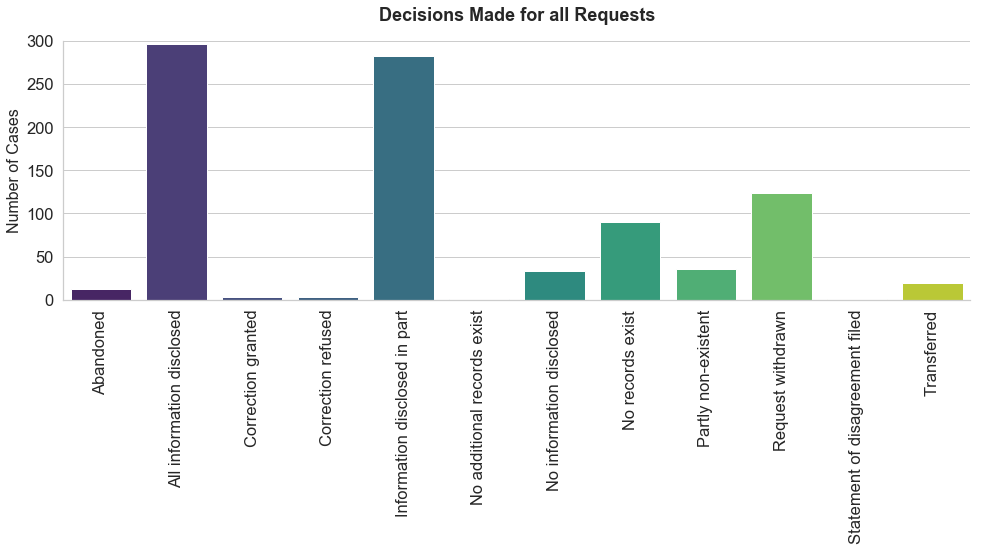

In [139]:
# Bar plot of all decisions made
columns = list(adf_groupby_Decision.index)

fig, ax = plt.subplots(figsize=(14, 8))

sns.set(style="whitegrid")
sns.set_context("notebook", font_scale=1.5)
sns.despine()

ax = sns.barplot(x=columns, y='Source', data=adf_groupby_Decision, palette=("viridis"))
ax.set_title(label='Decisions Made for all Requests', fontweight='bold', size=18, pad=20)
plt.ylabel('Number of Cases', fontsize=16)
plt.xticks(rotation=90)
plt.ylim(0, 300)
plt.tight_layout()
plt.savefig('./img/num_cases_vs_decisions_barplot_all.png')
plt.savefig('./img/num_cases_vs_decisions_barplot_all.pdf')

In [136]:
# As for all the 902 decisions
adf_groupby_Source = adf.groupby('Source').count()[['Decision']]
adf_groupby_Source

Decision
Source                            
Business                       225
Business by Agent               26
Individual                     416
Individual by Agent            208
Individual for dependant         1
Media                           26

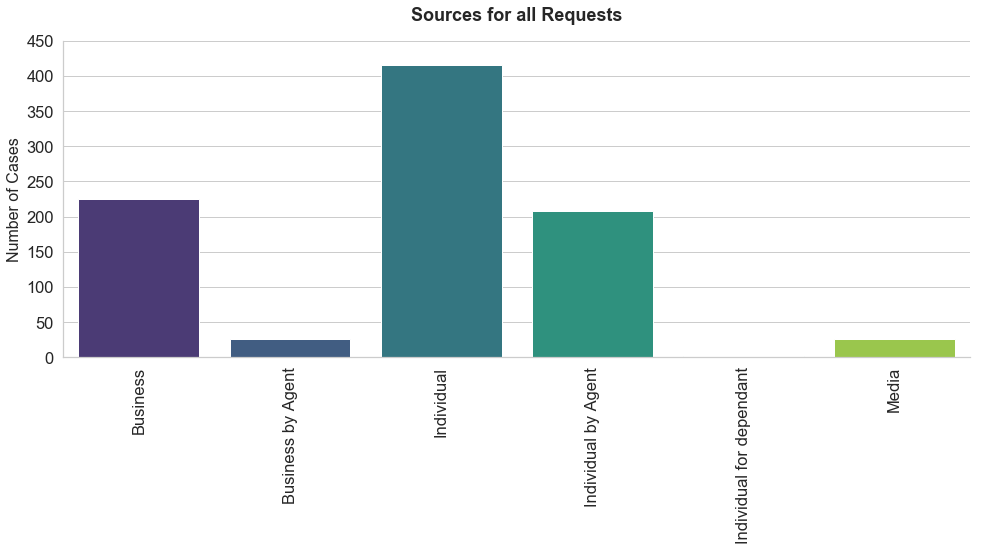

In [141]:
# Bar plot of all decisions made
columns = list(adf_groupby_Source.index)

fig, ax = plt.subplots(figsize=(14, 8))

sns.set(style="whitegrid")
sns.set_context("notebook", font_scale=1.5)
sns.despine()

ax = sns.barplot(x=columns, y='Decision', data=adf_groupby_Source, palette=("viridis"))
ax.set_title(label='Sources for all Requests', fontweight='bold', size=18, pad=20)
plt.ylabel('Number of Cases', fontsize=16)
plt.xticks(rotation=90)
plt.ylim(0, 450)
plt.tight_layout()
plt.savefig('./img/num_cases_vs_sources_barplot_all.png')
plt.savefig('./img/num_cases_vs_sources_barplot_all.pdf')

In [142]:
# Let's create a matrix of Decision vs Source

df_by_Decision = {}

source_types = []
for i in range (0, len(adf.Source.unique())):
    source_types.append(adf.Source.unique()[i])

decision_types = []
for i in range (0, len(adf.Decision.unique())):
    decision_types.append(adf.Decision.unique()[i])

counter = 0

for source in source_types:
    temp_df = adf[adf['Source'] == source].groupby('Decision').count()[['Source']]
    df_by_Decision[counter] = temp_df.T    # Transpose
    if len(df_by_Decision[counter].columns) != len(decision_types):
        for column in decision_types:
            if column not in df_by_Decision[counter].columns:
                df_by_Decision[counter][column] = 0

    df_by_Decision[counter].rename(index={'Source': source}, inplace=True)
    df_by_Decision[counter].rename
    counter += 1

df_by_Decision = pd.concat(df_by_Decision, sort=True)

df_by_Decision


Abandoned  All information disclosed  \
0 Individual                        5                        138   
1 Business                          3                         70   
2 Individual by Agent               4                         80   
3 Media                             0                          3   
4 Business by Agent                 0                          5   
5 Individual for dependant          1                          0   

                            Correction granted  Correction refused  \
0 Individual                                 3                   3   
1 Business                                   0                   0   
2 Individual by Agent                        0                   0   
3 Media                                      0                   0   
4 Business by Agent                          0                   0   
5 Individual for dependant                   0                   0   

                            Information disclosed in part  \
0 Individual                                          150   
1 Business                                             48   
2 Individual by Agent                                  65   
3 Media                                                10   
4 Business by Agent                                     9   
5 Individual for dependant                              0   

                            No additional records exist  \
0 Individual                                          1   
1 Business                                            0   
2 Individual by Agent                                 0   
3 Media                                               0   
4 Business by Agent                                   0   
5 Individual for dependant                            0   

                            No information disclosed  No records exist  \
0 Individual                                      18                20   
1 Business                                         4                45   
2 Individual by Agent                              2                21   
3 Media                                            7                 1   
4 Business by Agent                                2                 3   
5 Individual for dependant                         0                 0   

                            Partly non-existent  Request withdrawn  \
0 Individual                                 18                 48   
1 Business                                   12                 41   
2 Individual by Agent                         5                 24   
3 Media                                       1                  4   
4 Business by Agent                           0                  7   
5 Individual for dependant                    0                  0   

                            Statement of disagreement filed  Transferred  
0 Individual                                              1           11  
1 Business                                                0            2  
2 Individual by Agent                                     0            7  
3 Media                                                   0            0  
4 Business by Agent                                       0            0  
5 Individual for dependant                                0            0

We have now created a multi-index array, let's reset index to be the Source.

In [143]:
df_by_Decision = df_by_Decision.reset_index(level=0, drop=True)

In [144]:
df_by_Decision

Abandoned  All information disclosed  \
Individual                        5                        138   
Business                          3                         70   
Individual by Agent               4                         80   
Media                             0                          3   
Business by Agent                 0                          5   
Individual for dependant          1                          0   

                          Correction granted  Correction refused  \
Individual                                 3                   3   
Business                                   0                   0   
Individual by Agent                        0                   0   
Media                                      0                   0   
Business by Agent                          0                   0   
Individual for dependant                   0                   0   

                          Information disclosed in part  \
Individual                                          150   
Business                                             48   
Individual by Agent                                  65   
Media                                                10   
Business by Agent                                     9   
Individual for dependant                              0   

                          No additional records exist  \
Individual                                          1   
Business                                            0   
Individual by Agent                                 0   
Media                                               0   
Business by Agent                                   0   
Individual for dependant                            0   

                          No information disclosed  No records exist  \
Individual                                      18                20   
Business                                         4                45   
Individual by Agent                              2                21   
Media                                            7                 1   
Business by Agent                                2                 3   
Individual for dependant                         0                 0   

                          Partly non-existent  Request withdrawn  \
Individual                                 18                 48   
Business                                   12                 41   
Individual by Agent                         5                 24   
Media                                       1                  4   
Business by Agent                           0                  7   
Individual for dependant                    0                  0   

                          Statement of disagreement filed  Transferred  
Individual                                              1           11  
Business                                                0            2  
Individual by Agent                                     0            7  
Media                                                   0            0  
Business by Agent                                       0            0  
Individual for dependant                                0            0

And in a nice heatmap format,

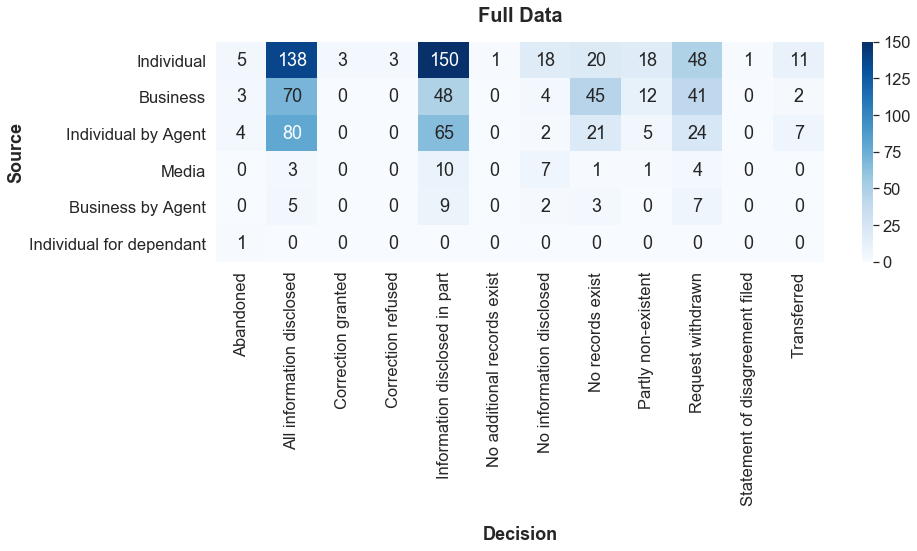

In [145]:
fig, ax = plt.subplots(figsize=(14, 8))
sns.heatmap(df_by_Decision, annot=True, fmt='d', cmap='Blues',
            xticklabels=df_by_Decision.columns, yticklabels=df_by_Decision.index)
plt.ylabel('Source', fontweight='bold', fontsize=18)
plt.xlabel('Decision', fontweight='bold', fontsize=18, labelpad=20)
plt.xticks(rotation=90)
ax.set_title(label='Full Data', fontweight='bold', size=20, pad=20)
plt.tight_layout()
plt.savefig('./img/decisions_vs_source_heatmap_num_cases_all.png')
plt.savefig('./img/decisions_vs_source_heatmap_num_cases_all.pdf')

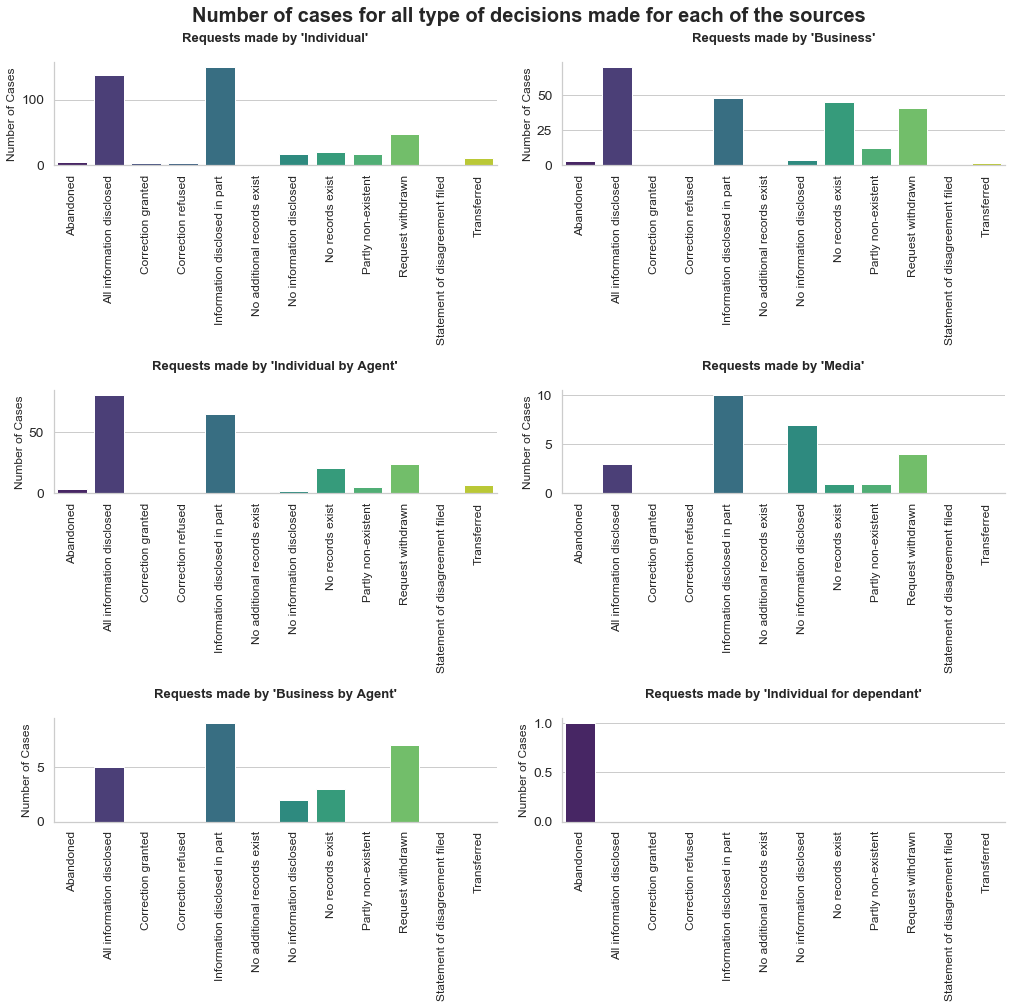

In [146]:
# Visualizing the data just obtained, for each of the sources

fig, axs = plt.subplots(figsize=(15, 15), frameon=False) 
plt.box(False)
plt.axis('off')
plt.subplots_adjust(hspace = 1.6)
counter = 0

sns.set(style="whitegrid")
sns.set_context("notebook", font_scale=1.25)

for source in source_types:
    ax = fig.add_subplot(3, 2, counter+1)
    sns.despine()
    ax = sns.barplot(data=df_by_Decision[counter: counter + 1], palette=("viridis"))
    plt.ylabel('Number of Cases', fontsize=12)
    ax.set_title(label=str('Requests made by ' + '\'' + source + '\''), fontweight='bold', size=13, pad=20)
    plt.xticks(rotation=90, fontsize=12)
    counter += 1

axs.set_title(label='Number of cases for all type of decisions made for each of the sources', 
             fontweight='bold', size=20, pad=40)
plt.tight_layout()
plt.savefig('./img/num_cases_vs_decision_for_each_source_barplot_all.png')
plt.savefig('./img/num_cases_vs_decision_for_each_source_barplot_all.pdf')


Another useful view from the same data is looking at each type of decision for all the sources (the inverse of what we just did above.)

In [147]:
# Let's create a matrix of Source vs Decision

df_by_Entity = {}

for decision in decision_types:
    temp_df = adf[adf['Decision'] == decision].groupby('Source').count()[['Decision']]
    df_by_Entity[counter] = temp_df.T
    if len(df_by_Entity[counter].columns) != len(source_types):
        for column in source_types:
            if column not in df_by_Entity[counter].columns:
                df_by_Entity[counter][column] = 0

    df_by_Entity[counter].rename(index={'Decision': decision}, inplace=True)
    df_by_Entity[counter].rename
    counter += 1
    
df_by_Entity = pd.concat(df_by_Entity, sort=True)


In [148]:
# Resetting index to remove multi-indexing
df_by_Entity = df_by_Entity.reset_index(level=0, drop=True)
df_by_Entity

Business  Business by Agent  Individual  \
All information disclosed              70                  5         138   
Partly non-existent                    12                  0          18   
No information disclosed                4                  2          18   
Information disclosed in part          48                  9         150   
Transferred                             2                  0          11   
No records exist                       45                  3          20   
Request withdrawn                      41                  7          48   
Correction granted                      0                  0           3   
Correction refused                      0                  0           3   
Abandoned                               3                  0           5   
No additional records exist             0                  0           1   
Statement of disagreement filed         0                  0           1   

                                 Individual by Agent  \
All information disclosed                         80   
Partly non-existent                                5   
No information disclosed                           2   
Information disclosed in part                     65   
Transferred                                        7   
No records exist                                  21   
Request withdrawn                                 24   
Correction granted                                 0   
Correction refused                                 0   
Abandoned                                          4   
No additional records exist                        0   
Statement of disagreement filed                    0   

                                 Individual for dependant  Media  
All information disclosed                               0      3  
Partly non-existent                                     0      1  
No information disclosed                                0      7  
Information disclosed in part                           0     10  
Transferred                                             0      0  
No records exist                                        0      1  
Request withdrawn                                       0      4  
Correction granted                                      0      0  
Correction refused                                      0      0  
Abandoned                                               1      0  
No additional records exist                             0      0  
Statement of disagreement filed                         0      0

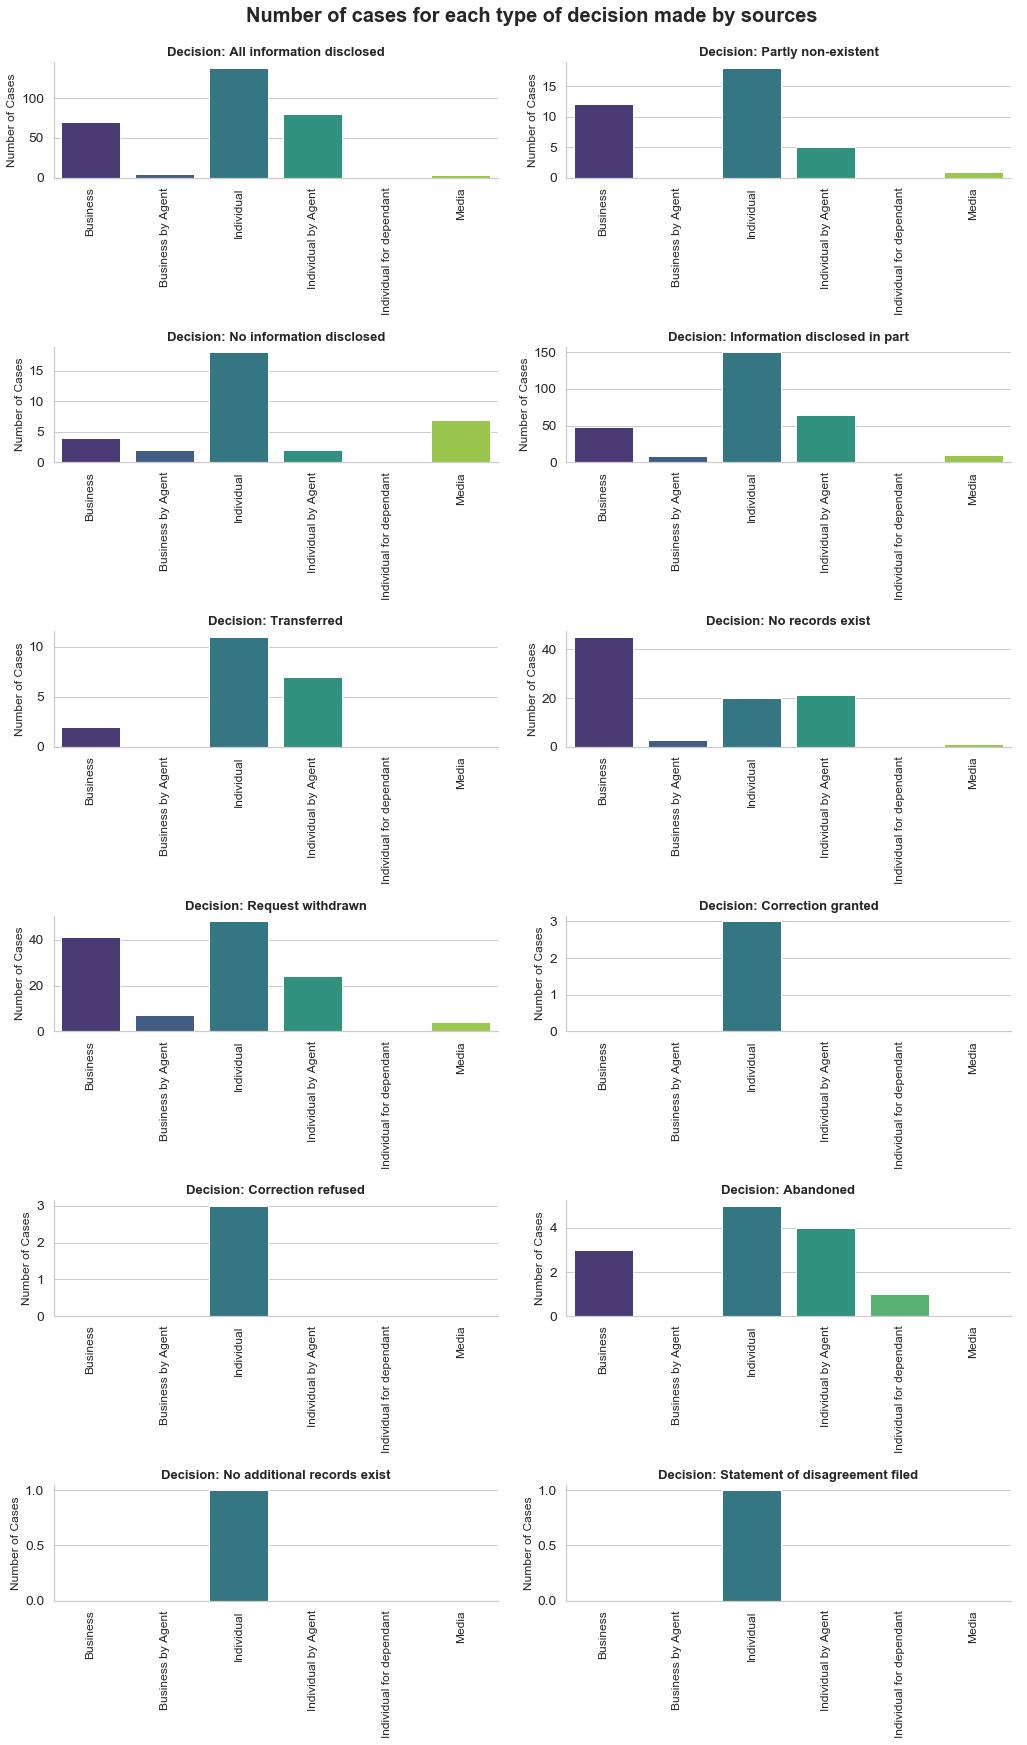

In [149]:
fig, axs = plt.subplots(figsize=(15, 25), frameon=False) 
plt.box(False)
plt.axis('off')
plt.subplots_adjust(hspace = 1.6)
counter = 0

for decision in decision_types:
    sns.set(style="whitegrid")
    sns.set_context("notebook", font_scale=1.25)
    ax = fig.add_subplot(6, 2, counter+1)
    sns.despine()
    ax = sns.barplot(data=df_by_Entity[counter: counter + 1], palette=("viridis"))
    plt.ylabel('Number of Cases', fontsize=12)
    ax.set_title(label=str('Decision: ' + decision), fontweight='bold', size=13)
    plt.xticks(rotation=90, fontsize=12)
    counter += 1

axs.set_title(label='Number of cases for each type of decision made by sources', 
             fontweight='bold', size=20, pad=40)
plt.tight_layout()
plt.savefig('./img/num_cases_vs_sources_for_each_decision_barplot_all.png')
plt.savefig('./img/num_cases_vs_sources_for_each_decision_barplot_all.pdf')

In [150]:
norm_rows_df_by_Decision = df_by_Decision.div(df_by_Decision.sum(axis=1), axis=0).round(decimals=2)

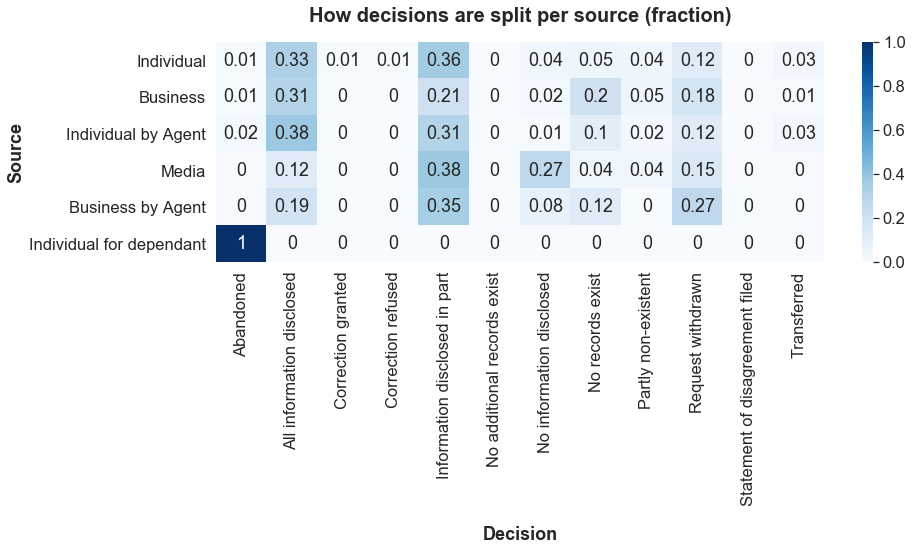

In [472]:
fig, ax = plt.subplots(figsize=(14, 8))
sns.set_context("notebook", font_scale=1.5)
sns.heatmap(norm_rows_df_by_Decision, annot=True, fmt='0.2g', cmap='Blues',
            xticklabels=norm_rows_df_by_Decision.columns, yticklabels=norm_rows_df_by_Decision.index)

plt.ylabel('Source', fontweight='bold', fontsize=18)
plt.xlabel('Decision', fontweight='bold', fontsize=18, labelpad=20)
plt.xticks(rotation=90)
ax.set_title(label='How decisions are split per source (fraction)', fontweight='bold', size=20, pad=20)
plt.tight_layout()
plt.savefig('./img/decisions_split_per_source_all_cases_percent.png')
plt.savefig('./img/decisions_split_per_source_all_cases_percent.pdf')

In [ ]:
sns.set_context("notebook", font_scale=1.5)

In [152]:
norm_cols_df_by_Decision = df_by_Decision.div(df_by_Decision.sum(axis=0), axis=1).round(decimals=2)

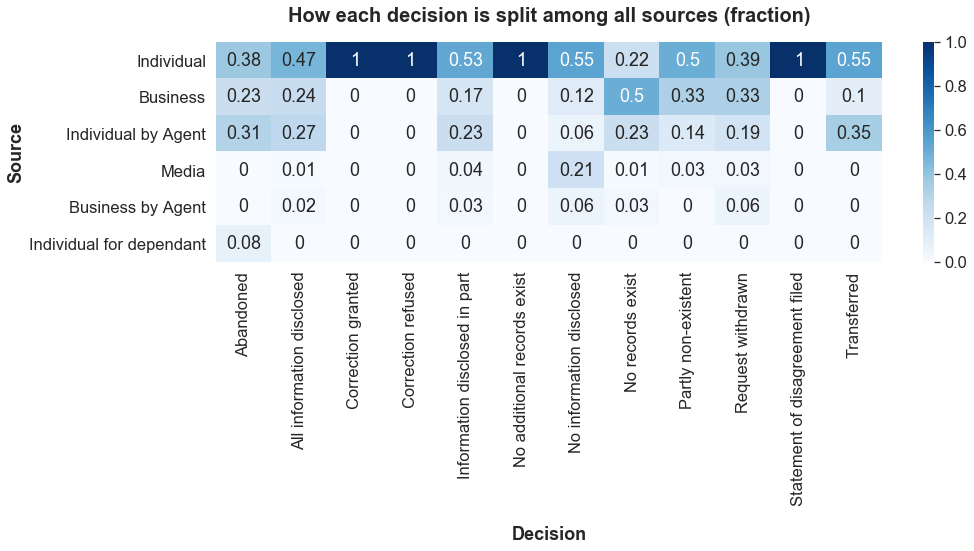

In [153]:
fig, ax = plt.subplots(figsize=(15, 8))
sns.set_context("notebook", font_scale=1.5)
sns.heatmap(norm_cols_df_by_Decision, annot=True, fmt='0.2g', cmap='Blues',
            xticklabels=norm_cols_df_by_Decision.columns, yticklabels=norm_cols_df_by_Decision.index)

plt.ylabel('Source', fontweight='bold', fontsize=18)
plt.xlabel('Decision', fontweight='bold', fontsize=18, labelpad=20)
ax.set_title(label='How each decision is split among all sources (fraction)', fontweight='bold', size=20, pad=20)
plt.tight_layout()
plt.savefig('./img/decision_split_among_sources_all_cases.png')
plt.savefig('./img/decision_split_among_sources_all_cases.pdf')

Another approach could be to drop the columns where there is no decision made. Meaning, when it was not on the hands of the person granting a decision, such as a request withdrawn or abandoned. It is important to note that the subset is still unbalanced.

In [156]:
sub_df_by_Decision = df_by_Decision.drop(columns=['Abandoned', 'Correction granted', 'Correction refused',
                                                'No additional records exist', 'No records exist', 
                                                'Partly non-existent', 'Request withdrawn', 'Transferred',
                                                'Statement of disagreement filed'])


In [157]:
sub_df_by_Decision

All information disclosed  \
Individual                                      138   
Business                                         70   
Individual by Agent                              80   
Media                                             3   
Business by Agent                                 5   
Individual for dependant                          0   

                          Information disclosed in part  \
Individual                                          150   
Business                                             48   
Individual by Agent                                  65   
Media                                                10   
Business by Agent                                     9   
Individual for dependant                              0   

                          No information disclosed  
Individual                                      18  
Business                                         4  
Individual by Agent                              2  
Media                                            7  
Business by Agent                                2  
Individual for dependant                         0

In [158]:
# Normalizing the subset by row - that is, each row (source) adds up to 100%
norm_sub_df_by_Decision = sub_df_by_Decision.div(sub_df_by_Decision.sum(axis=1), axis=0)
norm_sub_df_by_Decision

All information disclosed  \
Individual                                 0.450980   
Business                                   0.573770   
Individual by Agent                        0.544218   
Media                                      0.150000   
Business by Agent                          0.312500   
Individual for dependant                        NaN   

                          Information disclosed in part  \
Individual                                     0.490196   
Business                                       0.393443   
Individual by Agent                            0.442177   
Media                                          0.500000   
Business by Agent                              0.562500   
Individual for dependant                            NaN   

                          No information disclosed  
Individual                                0.058824  
Business                                  0.032787  
Individual by Agent                       0.013605  
Media                                     0.350000  
Business by Agent                         0.125000  
Individual for dependant                       NaN

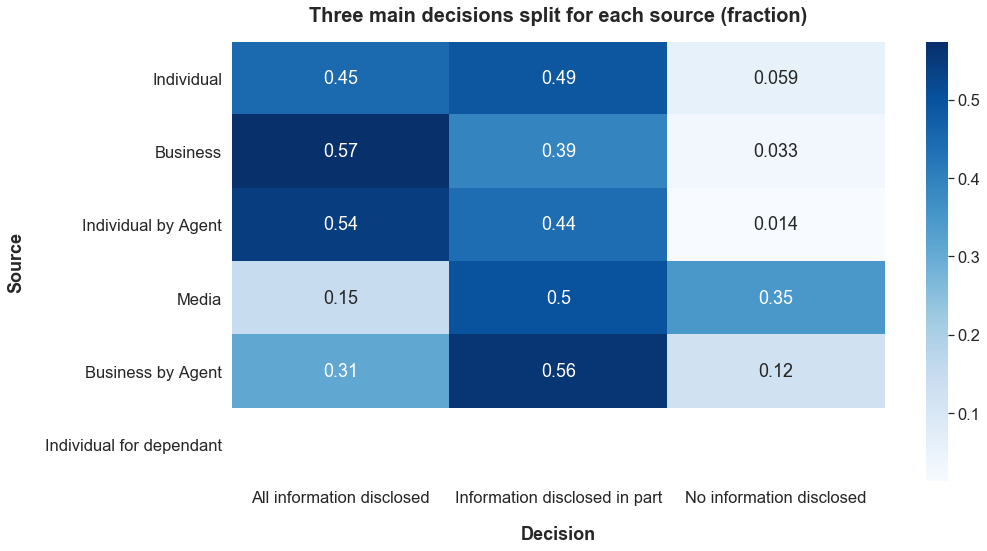

In [159]:
#sns.set_palette("husl")
sns.set_palette("deep")
fig, ax = plt.subplots(figsize=(15, 8))
sns.set_context("notebook", font_scale=1.5)
sns.heatmap(norm_sub_df_by_Decision, annot=True, fmt='0.2g', cmap='Blues',
            xticklabels=norm_sub_df_by_Decision.columns, yticklabels=norm_sub_df_by_Decision.index)

plt.ylabel('Source', fontweight='bold', fontsize=18, labelpad=20)
plt.xlabel('Decision', fontweight='bold', fontsize=18, labelpad=20)
ax.set_title(label='Three main decisions split for each source (fraction)', fontweight='bold', size=20, pad=20)
plt.tight_layout()
plt.savefig('./img/three_main_decisions_split_for_each_source_heatmap.png')
plt.savefig('./img/three_main_decisions_split_for_each_source_heatmap.pdf')


With this view, one sees that business do better, followed by individuals by agent. Media, having few requests, does not do well.

And looking at the same data but with some stacked or grouped bar plots!

In [160]:
norm_sub_df_by_Decision

All information disclosed  \
Individual                                 0.450980   
Business                                   0.573770   
Individual by Agent                        0.544218   
Media                                      0.150000   
Business by Agent                          0.312500   
Individual for dependant                        NaN   

                          Information disclosed in part  \
Individual                                     0.490196   
Business                                       0.393443   
Individual by Agent                            0.442177   
Media                                          0.500000   
Business by Agent                              0.562500   
Individual for dependant                            NaN   

                          No information disclosed  
Individual                                0.058824  
Business                                  0.032787  
Individual by Agent                       0.013605  
Media                                     0.350000  
Business by Agent                         0.125000  
Individual for dependant                       NaN

In [161]:
# Individual for dependent does not have any of these cases.
norm_sub_df_by_Decision = norm_sub_df_by_Decision.drop('Individual for dependant')

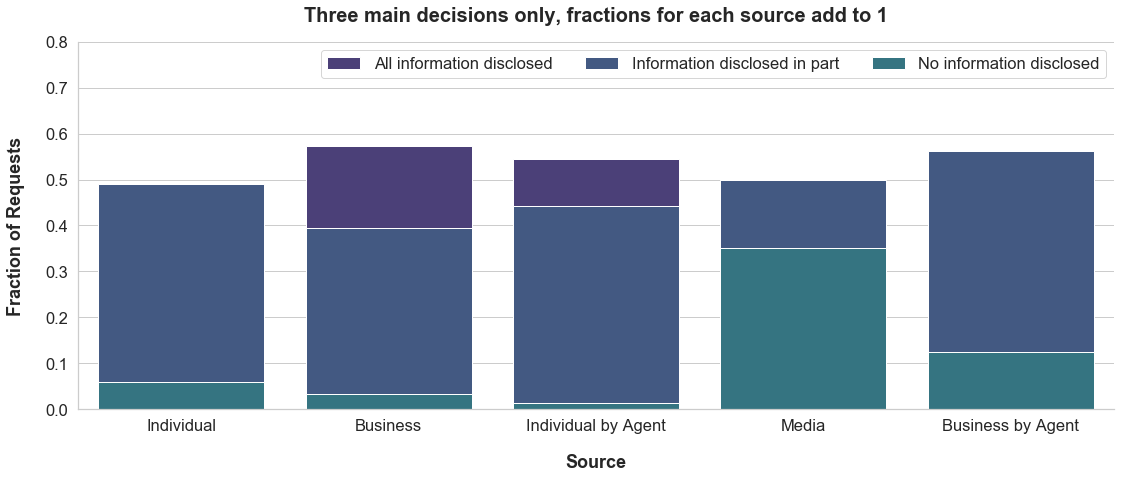

In [162]:
categ = list(norm_sub_df_by_Decision.index)

f, ax = plt.subplots(figsize=(16, 7))

sns.set_context("notebook", font_scale=1.5)
sns.barplot(y='All information disclosed', x=categ, data=norm_sub_df_by_Decision,
            label='All information disclosed', color='#453781FF')

sns.barplot(y='Information disclosed in part', x=categ, data=norm_sub_df_by_Decision,
            label='Information disclosed in part', color='#39568CFF')

sns.barplot(y='No information disclosed', x=categ, data=norm_sub_df_by_Decision,
            label='No information disclosed', color='#287D8EFF')

ax.legend(ncol=3, loc="upper right", frameon=True)
plt.ylabel('Fraction of Requests', fontweight='bold', fontsize=18, labelpad=20)
plt.xlabel('Source', fontweight='bold', fontsize=18, labelpad=20)
ax.set(ylim=(0, 0.8))
ax.set_title(label='Three main decisions only, fractions for each source add to 1', 
             fontweight='bold', size=20, pad=20)
sns.despine(right=True, top=True)

plt.tight_layout()
plt.savefig('./img/three_main_decisions_split_for_each_source_stacked_barplot.png')
plt.savefig('./img/three_main_decisions_split_for_each_source_stacked_barplot.pdf')

In [163]:
norm_sub_df_by_Decision

All information disclosed  Information disclosed in part  \
Individual                            0.450980                       0.490196   
Business                              0.573770                       0.393443   
Individual by Agent                   0.544218                       0.442177   
Media                                 0.150000                       0.500000   
Business by Agent                     0.312500                       0.562500   

                     No information disclosed  
Individual                           0.058824  
Business                             0.032787  
Individual by Agent                  0.013605  
Media                                0.350000  
Business by Agent                    0.125000

In [164]:
norm_sub_df_by_Decision['All information disclosed'].values.tolist()

[0.45098039215686275, 0.5737704918032787, 0.54421768707483, 0.15, 0.3125]

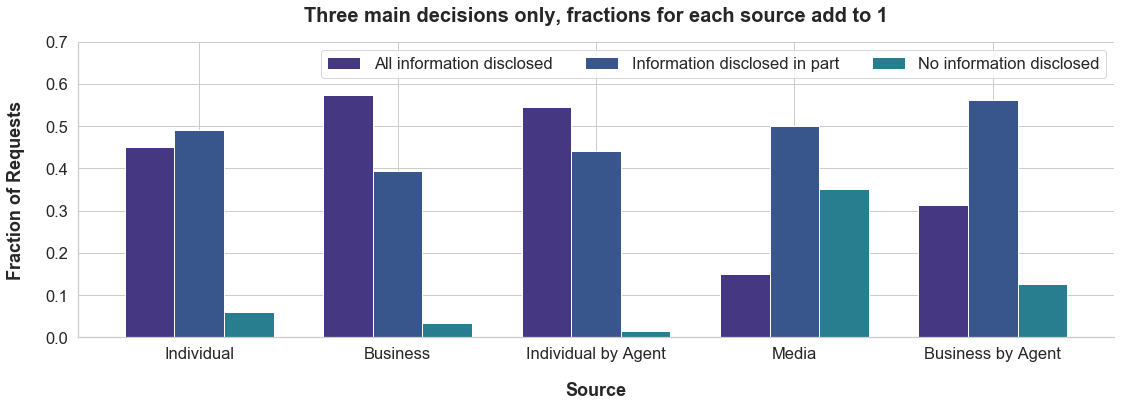

In [166]:
categ = list(norm_sub_df_by_Decision.index)

fig, ax = plt.subplots(figsize=(16, 6))

# Set width of bar
barWidth = 0.25
 
# Set height of bar
bars1 = norm_sub_df_by_Decision['All information disclosed'].values.tolist()
bars2 = norm_sub_df_by_Decision['Information disclosed in part'].values.tolist()
bars3 = norm_sub_df_by_Decision['No information disclosed'].values.tolist()

# Set position of bar on X axis
r1 = np.arange(len(bars1))
r2 = [x + barWidth for x in r1]
r3 = [x + barWidth for x in r2]

# Make the plot
plt.bar(r1, bars1, color='#453781FF', width=barWidth, edgecolor='white', label='All information disclosed')
plt.bar(r2, bars2, color='#39568CFF', width=barWidth, edgecolor='white', label='Information disclosed in part')
plt.bar(r3, bars3, color='#287D8EFF', width=barWidth, edgecolor='white', label='No information disclosed')

# Add xticks on the middle of the group bars
plt.xlabel('Source', fontweight='bold')
plt.xticks([r + barWidth for r in range(len(bars1))], categ)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
 
# Create legend & Show graphic
ax.legend(ncol=3, loc="upper right", frameon=True)
plt.ylabel('Fraction of Requests', fontweight='bold', fontsize=18, labelpad=20)
plt.xlabel('Source', fontweight='bold', fontsize=18, labelpad=20)
ax.set(ylim=(0, 0.7))
ax.set_title(label='Three main decisions only, fractions for each source add to 1',
             fontweight='bold', size=20, pad=20)
sns.despine(right=True, top=True)
plt.tight_layout()
plt.savefig('./img/three_main_decisions_split_for_each_source_sidebyside_barplots.png')
plt.savefig('./img/three_main_decisions_split_for_each_source_sidebyside_barplots.pdf')

There are some interesting features in these plots. 

- Business get the most cases where the information is fully disclosed and the least with no disclosed information.
- Media is the other way around. 
- Individuals by Agent fare better than individuals without one, however, the opposite is true for business and business by agents.



And another view for the same data can be done by exchanging the axes, i.e., by finding the source for each of the decisions. We need to start the table form scratch, to drop the rows where the decision was not made by the clerks.

In [167]:
sub_df_by_Entity = df_by_Entity.drop(['Abandoned', 'Correction granted', 'Correction refused',
                                      'No additional records exist', 'No records exist', 
                                      'Partly non-existent', 'Request withdrawn', 'Transferred',
                                      'Statement of disagreement filed'], axis=0)
sub_df_by_Entity = sub_df_by_Entity.drop(columns='Individual for dependant')

In [168]:
sub_df_by_Entity

Business  Business by Agent  Individual  \
All information disclosed            70                  5         138   
No information disclosed              4                  2          18   
Information disclosed in part        48                  9         150   

                               Individual by Agent  Media  
All information disclosed                       80      3  
No information disclosed                         2      7  
Information disclosed in part                   65     10

In [169]:
# Normalizing by row, i.e, by type of decision. Decisions add up to 100%
norm_sub_df_by_Entity = sub_df_by_Entity.div(sub_df_by_Entity.sum(axis=1), axis=0)

In [170]:
norm_sub_df_by_Entity

Business  Business by Agent  Individual  \
All information disclosed      0.236486           0.016892    0.466216   
No information disclosed       0.121212           0.060606    0.545455   
Information disclosed in part  0.170213           0.031915    0.531915   

                               Individual by Agent     Media  
All information disclosed                 0.270270  0.010135  
No information disclosed                  0.060606  0.212121  
Information disclosed in part             0.230496  0.035461

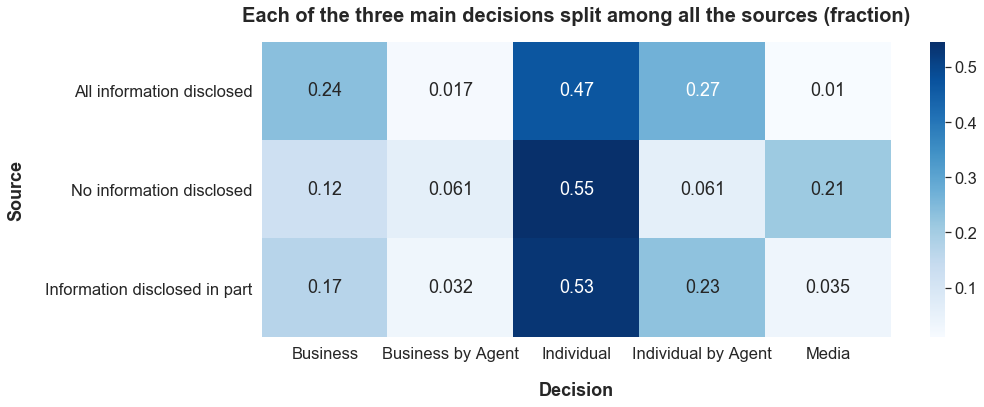

In [171]:
# Decisions add up to 100%
'''
plt.figure(figsize=(10, 6))
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 3.5, "lines.markersize": 12.0})
ax = sns.lineplot(data=norm_sub_df_by_Entity.T, markers=True)
ax.set(ylabel='Number of Cases', title='Each type of Decision adds to 100%')
plt.xticks(rotation=45)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
'''

fig, ax = plt.subplots(figsize=(15, 6))
sns.set_context("notebook", font_scale=1.5)
sns.heatmap(data=norm_sub_df_by_Entity, annot=True, fmt='0.2g', cmap='Blues',
            xticklabels=norm_sub_df_by_Entity.columns, yticklabels=norm_sub_df_by_Entity.index)

plt.ylabel('Source', fontweight='bold', fontsize=18, labelpad=20)
plt.xlabel('Decision', fontweight='bold', fontsize=18, labelpad=20)
ax.set_title(label='Each of the three main decisions split among all the sources (fraction)', 
             fontweight='bold', size=20, pad=20)
plt.tight_layout()
plt.savefig('./img/three_main_decisions_split_among_all_sources_heatmap.png')
plt.savefig('./img/three_main_decisions_split_among_all_sources_heatmap.pdf')



- Of the requests where all the information was disclosed, 47% to belong to individuals, 27% to individuals by agents, and 24% business.
- For partially disclosed information, 53% were for individuals, 23% for individuals by agents, and 17% for businesses. 
- More than 50% of the requests where no information was disclosed were made by individuals, and 21% were made by the media. 

Now, doing a grouped bar plot for all the decisions.

In [172]:
df_by_Decision

Abandoned  All information disclosed  \
Individual                        5                        138   
Business                          3                         70   
Individual by Agent               4                         80   
Media                             0                          3   
Business by Agent                 0                          5   
Individual for dependant          1                          0   

                          Correction granted  Correction refused  \
Individual                                 3                   3   
Business                                   0                   0   
Individual by Agent                        0                   0   
Media                                      0                   0   
Business by Agent                          0                   0   
Individual for dependant                   0                   0   

                          Information disclosed in part  \
Individual                                          150   
Business                                             48   
Individual by Agent                                  65   
Media                                                10   
Business by Agent                                     9   
Individual for dependant                              0   

                          No additional records exist  \
Individual                                          1   
Business                                            0   
Individual by Agent                                 0   
Media                                               0   
Business by Agent                                   0   
Individual for dependant                            0   

                          No information disclosed  No records exist  \
Individual                                      18                20   
Business                                         4                45   
Individual by Agent                              2                21   
Media                                            7                 1   
Business by Agent                                2                 3   
Individual for dependant                         0                 0   

                          Partly non-existent  Request withdrawn  \
Individual                                 18                 48   
Business                                   12                 41   
Individual by Agent                         5                 24   
Media                                       1                  4   
Business by Agent                           0                  7   
Individual for dependant                    0                  0   

                          Statement of disagreement filed  Transferred  
Individual                                              1           11  
Business                                                0            2  
Individual by Agent                                     0            7  
Media                                                   0            0  
Business by Agent                                       0            0  
Individual for dependant                                0            0

In [173]:
# Normalizing the subset by row - that is, each row (source) adds up to 100%
norm_df_by_Decision = df_by_Decision.div(df_by_Decision.sum(axis=1), axis=0)
norm_df_by_Decision = norm_df_by_Decision.drop('Individual for dependant')
norm_df_by_Decision

Abandoned  All information disclosed  Correction granted  \
Individual            0.012019                   0.331731            0.007212   
Business              0.013333                   0.311111            0.000000   
Individual by Agent   0.019231                   0.384615            0.000000   
Media                 0.000000                   0.115385            0.000000   
Business by Agent     0.000000                   0.192308            0.000000   

                     Correction refused  Information disclosed in part  \
Individual                     0.007212                       0.360577   
Business                       0.000000                       0.213333   
Individual by Agent            0.000000                       0.312500   
Media                          0.000000                       0.384615   
Business by Agent              0.000000                       0.346154   

                     No additional records exist  No information disclosed  \
Individual                              0.002404                  0.043269   
Business                                0.000000                  0.017778   
Individual by Agent                     0.000000                  0.009615   
Media                                   0.000000                  0.269231   
Business by Agent                       0.000000                  0.076923   

                     No records exist  Partly non-existent  Request withdrawn  \
Individual                   0.048077             0.043269           0.115385   
Business                     0.200000             0.053333           0.182222   
Individual by Agent          0.100962             0.024038           0.115385   
Media                        0.038462             0.038462           0.153846   
Business by Agent            0.115385             0.000000           0.269231   

                     Statement of disagreement filed  Transferred  
Individual                                  0.002404     0.026442  
Business                                    0.000000     0.008889  
Individual by Agent                         0.000000     0.033654  
Media                                       0.000000     0.000000  
Business by Agent                           0.000000     0.000000

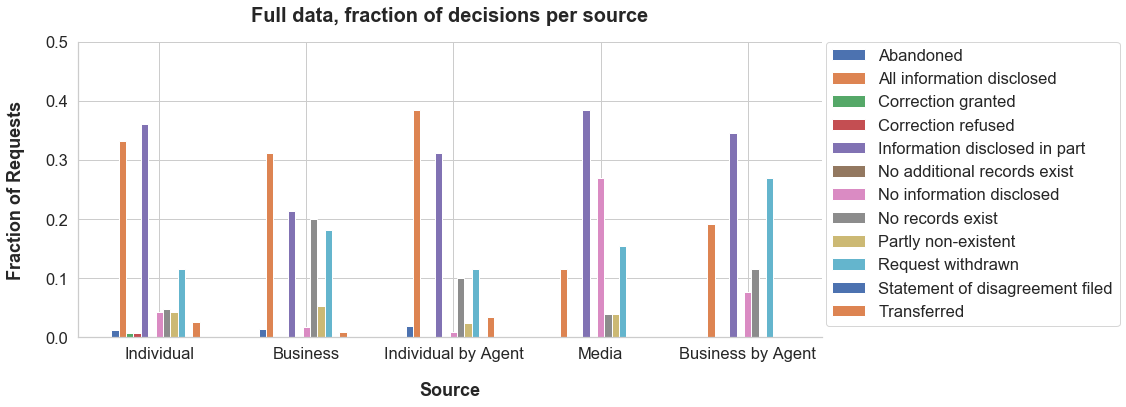

In [174]:
categ = list(norm_df_by_Decision.index)

dec_norm_df_by_Decision = norm_df_by_Decision.columns.values.tolist()

fig, ax = plt.subplots(figsize=(16, 6))

# Set width of bar
barWidth = 0.05

bars = []
 
# Set height of bar
for dec in dec_norm_df_by_Decision:
    bars.append(norm_df_by_Decision[dec])

rs = []
r = np.arange(len(bars[0]))
rs.append(r)
# Set position of bar on X axis
for bw in range(1, len(bars)):
    rn = [x + barWidth for x in r]
    rs.append(rn)
    r = rn
    
# Make the plot
counter = 0

for dec in dec_norm_df_by_Decision:
    plt.bar(rs[counter], bars[counter], width=barWidth, edgecolor='white', label=dec)
    counter += 1

# Add xticks on the middle of the group bars
center_lb = len(dec_norm_df_by_Decision)/2
plt.xticks([r + center_lb*barWidth for r in range(len(bars[0]))], categ)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

 
# Create legend & Show graphic
plt.legend(bbox_to_anchor=(1.005, 1), loc=2, borderaxespad=0.)
plt.xlabel('Source', fontweight='bold', labelpad=20)
plt.ylabel('Fraction of Requests', fontweight='bold', fontsize=18, labelpad=20)
plt.ylim(0, 0.5)
ax.set_title(label='Full data, fraction of decisions per source', fontweight='bold', size=20, pad=20)
plt.tight_layout()
plt.savefig('./img/percentage_decisions_vs_source_barplot_sidebyside_all.png')
plt.savefig('./img/percentage_decisions_vs_source_barplot_sidebyside_all.pdf')


And here is another way to make the same plot, by using pandas.Dataframe.plot().

In [175]:
adf_no_individual_for_dependant = adf[adf['Source'] != 'Individual for dependant']

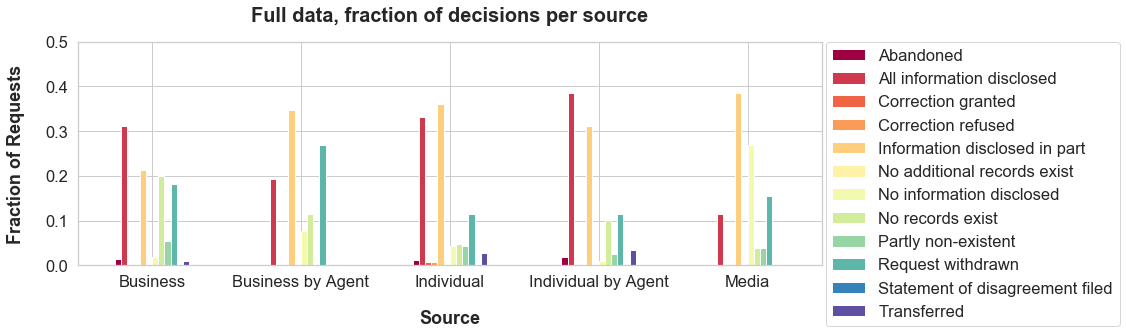

In [176]:
props = adf_no_individual_for_dependant.groupby('Source')['Decision'].value_counts(normalize=True).unstack()
plt1 = props.plot(kind='bar', stacked=False, figsize=(16,5),
                 colormap='Spectral') 

plt.legend(bbox_to_anchor=(1.005, 1), loc=2, borderaxespad=0.)
plt.xlabel('Source', fontweight='bold', fontsize=18, labelpad=20)
plt.xticks(rotation=0)
plt.ylim(0, 0.5)
plt.ylabel('Fraction of Requests', fontweight='bold', fontsize=18, labelpad=20)
plt1.set_title(label='Full data, fraction of decisions per source', fontweight='bold', size=20, pad=20)
plt.tight_layout()
plt.savefig('./img/percentage_decisions_vs_source_not_stacked_barplot_no_dependant.png')
plt.savefig('./img/percentage_decisions_vs_source_not_stacked_barplot_no_dependant.pdf')

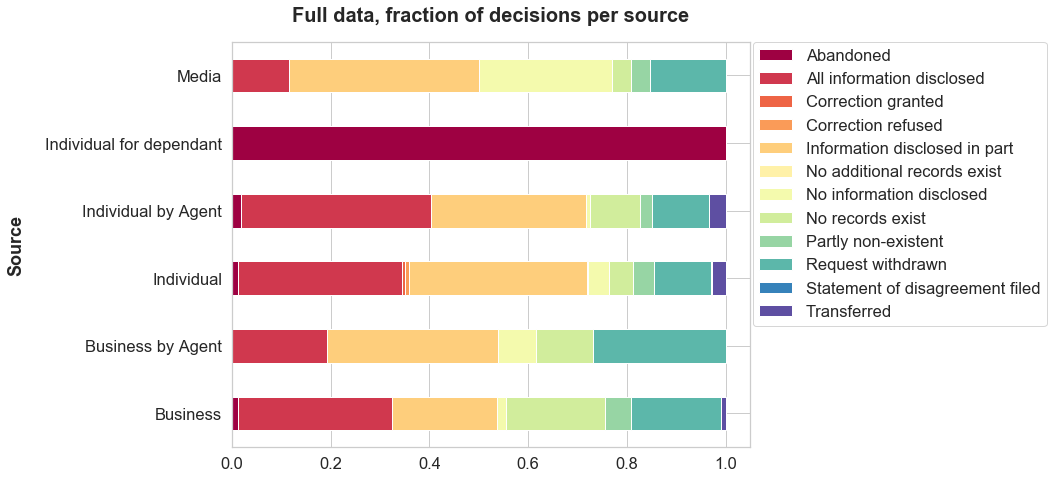

In [177]:
props = adf.groupby('Source')['Decision'].value_counts(normalize=True).unstack()
plt1 = props.plot(kind='barh', stacked=True, figsize=(15,7),
                 colormap='Spectral') 

plt.legend(bbox_to_anchor=(1.005, 1), loc=2, borderaxespad=0.)
plt.ylabel('Source', fontweight='bold', fontsize=18, labelpad=20)
plt1.set_title(label='Full data, fraction of decisions per source', fontweight='bold', size=20, pad=20)
plt.tight_layout()
plt.savefig('./img/percentage_decisions_vs_source_stacked_horizontal_barplot.png')
plt.savefig('./img/percentage_decisions_vs_source_stacked_horizontal_barplot.pdf')

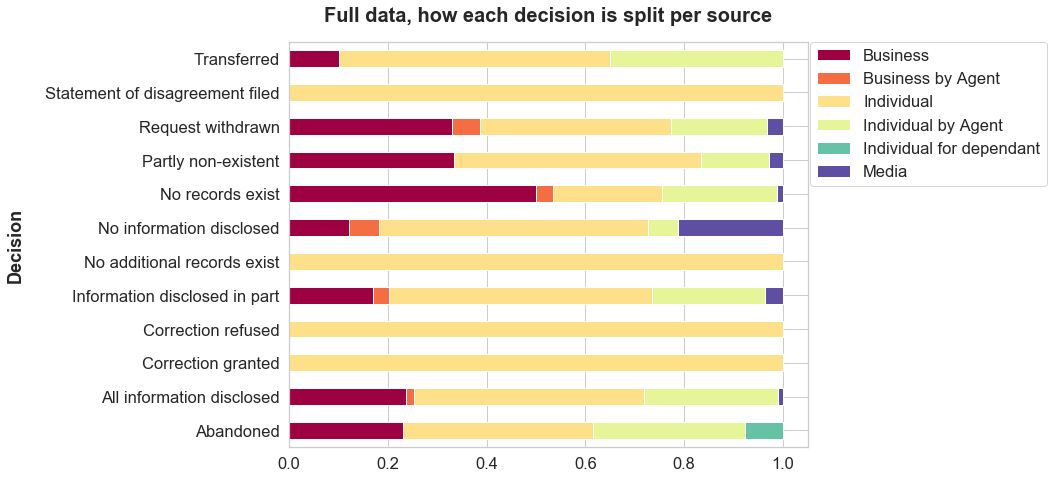

In [178]:
props = adf.groupby('Decision')['Source'].value_counts(normalize=True).unstack()
plt1 = props.plot(kind='barh', stacked=True, figsize=(15,7),
                 colormap='Spectral') 

plt.legend(bbox_to_anchor=(1.005, 1), loc=2, borderaxespad=0.)
plt.ylabel('Decision', fontweight='bold', fontsize=18, labelpad=20)
plt1.set_title(label='Full data, how each decision is split per source', fontweight='bold', size=20, pad=20)
plt.tight_layout()
plt.savefig('./img/percentage_sources_for_each_decision_stacked_horizontal_barplot.png')
plt.savefig('./img/percentage_sources_for_each_decision_stacked_horizontal_barplot.pdf')

And if we drop decisions that have less than 15 instances:

In [179]:
norm_df_by_Decision_over15 = df_by_Decision.copy()

dec_norm_df_by_Decision_over15 = norm_df_by_Decision_over15.columns.values.tolist()

todrop = []

for dec in dec_norm_df_by_Decision_over15:
    if norm_df_by_Decision_over15[dec].sum(axis=0) < 15:
        todrop.append(dec)

for decs in todrop:
    norm_df_by_Decision_over15 = norm_df_by_Decision_over15.drop(columns=decs)

norm_df_by_Decision_over15      
    

All information disclosed  \
Individual                                      138   
Business                                         70   
Individual by Agent                              80   
Media                                             3   
Business by Agent                                 5   
Individual for dependant                          0   

                          Information disclosed in part  \
Individual                                          150   
Business                                             48   
Individual by Agent                                  65   
Media                                                10   
Business by Agent                                     9   
Individual for dependant                              0   

                          No information disclosed  No records exist  \
Individual                                      18                20   
Business                                         4                45   
Individual by Agent                              2                21   
Media                                            7                 1   
Business by Agent                                2                 3   
Individual for dependant                         0                 0   

                          Partly non-existent  Request withdrawn  Transferred  
Individual                                 18                 48           11  
Business                                   12                 41            2  
Individual by Agent                         5                 24            7  
Media                                       1                  4            0  
Business by Agent                           0                  7            0  
Individual for dependant                    0                  0            0

In [180]:
# Normalizing the subset by row - that is, each row (source) adds up to 100%
norm_df_by_Decision_over15 = norm_df_by_Decision_over15.drop('Individual for dependant')
norm_df_by_Decision_over15 = norm_df_by_Decision_over15.div(norm_df_by_Decision_over15.sum(axis=1), axis=0)
norm_df_by_Decision_over15

All information disclosed  Information disclosed in part  \
Individual                            0.342432                       0.372208   
Business                              0.315315                       0.216216   
Individual by Agent                   0.392157                       0.318627   
Media                                 0.115385                       0.384615   
Business by Agent                     0.192308                       0.346154   

                     No information disclosed  No records exist  \
Individual                           0.044665          0.049628   
Business                             0.018018          0.202703   
Individual by Agent                  0.009804          0.102941   
Media                                0.269231          0.038462   
Business by Agent                    0.076923          0.115385   

                     Partly non-existent  Request withdrawn  Transferred  
Individual                      0.044665           0.119107     0.027295  
Business                        0.054054           0.184685     0.009009  
Individual by Agent             0.024510           0.117647     0.034314  
Media                           0.038462           0.153846     0.000000  
Business by Agent               0.000000           0.269231     0.000000

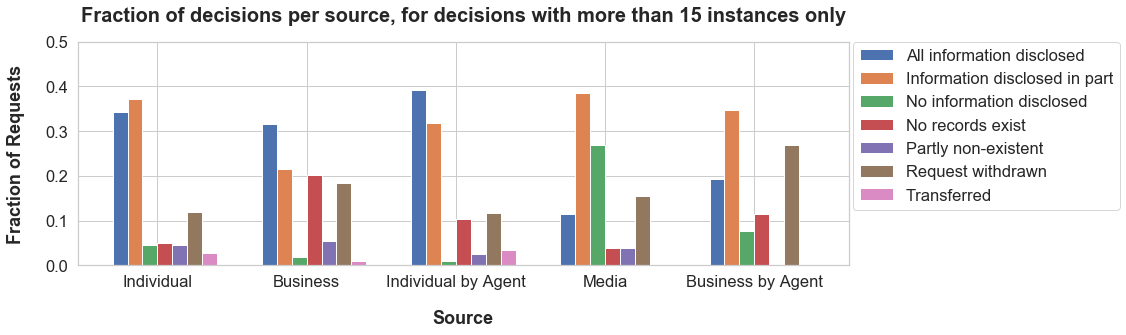

In [181]:
categ = list(norm_df_by_Decision_over15.index)

dec_norm_df_by_Decision_over15 = norm_df_by_Decision_over15.columns.values.tolist()

fig, ax = plt.subplots(figsize=(16, 5))

# Set width of bar
barWidth = 0.1

bars = []
 
# Set height of bar
for dec in dec_norm_df_by_Decision_over15:
    bars.append(norm_df_by_Decision_over15[dec])

rs = []
r = np.arange(len(bars[0]))
rs.append(r)
# Set position of bar on X axis
for bw in range(1, len(bars)):
    rn = [x + barWidth for x in r]
    rs.append(rn)
    r = rn
    
# Make the plot
counter = 0

for dec in dec_norm_df_by_Decision_over15:
    plt.bar(rs[counter], bars[counter], width=barWidth, edgecolor='white', label=dec)
    counter += 1

# Add xticks on the middle of the group bars
plt.xlabel('Source', fontweight='bold')
center_lb = len(norm_df_by_Decision_over15)/2
plt.xticks([r + center_lb*barWidth for r in range(len(bars[0]))], categ)
 
# Create legend & Show graphic
plt.legend(bbox_to_anchor=(1.005, 1), loc=2, borderaxespad=0.)
plt.xlabel('Source', fontweight='bold', labelpad=20)
plt.ylabel('Fraction of Requests', fontweight='bold', fontsize=18, labelpad=20)
plt.ylim(0, 0.5)
ax.set_title(label='Fraction of decisions per source, for decisions with more than 15 instances only',
             fontweight='bold', size=20, pad=20)
plt.tight_layout()
plt.savefig('./img/percentage_decisions_vs_source_barplot_sidebyside_over15_only.png')
plt.savefig('./img/percentage_decisions_vs_source_barplot_sidebyside_over15_only.pdf')


And again, generating the same figure, but this time by using pandas.Dataframe.plot().

In [182]:
adf_over15 = adf.groupby('Decision').filter(lambda x: len(x) >= 15)

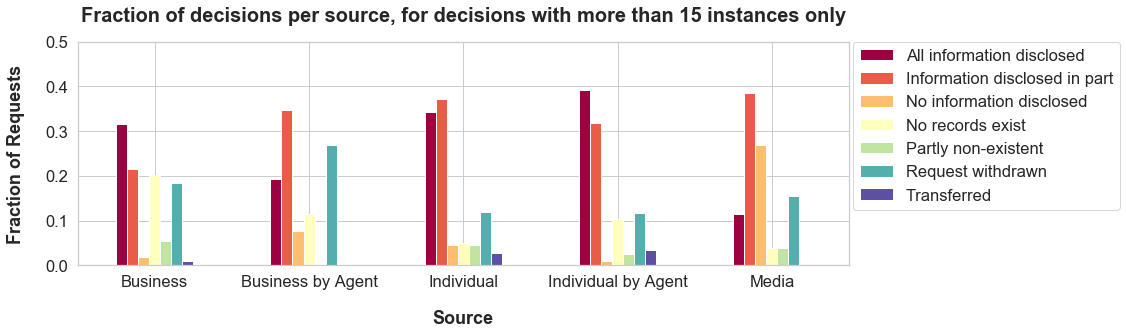

In [183]:
props = adf_over15.groupby('Source')['Decision'].value_counts(normalize=True).unstack()
plt1 = props.plot(kind='bar', stacked=False, figsize=(16,5),
                 colormap='Spectral') 

plt.legend(bbox_to_anchor=(1.005, 1), loc=2, borderaxespad=0.)
plt.xlabel('Source', fontweight='bold', fontsize=18, labelpad=20)
plt.xticks(rotation=0)
plt.ylim(0, 0.5)
plt.ylabel('Fraction of Requests', fontweight='bold', fontsize=18, labelpad=20)
plt1.set_title(label='Fraction of decisions per source, for decisions with more than 15 instances only', fontweight='bold', size=20, pad=20)
plt.tight_layout()
plt.savefig('./img/percentage_decisions_vs_source_not_stacked_barplot_sidebyside_over15_only.png')
plt.savefig('./img/percentage_decisions_vs_source_not_stacked_barplot_sidebyside_over15_only.pdf')

Media is the one with the least success. Let's see what type of requests they make.

In [185]:
media_req = adf[adf['Source'] == 'Media']

for req in range(0, len(media_req)):
    index = media_req.index[req]
    sum_req = media_req.loc[index,'Summary_of_Request']
    dec = media_req.loc[index,'Decision']
    print('Request {0}. Decision: {1}\n{2}\n'.format(req+1, dec, sum_req))

Request 1. Decision: No information disclosed
Ontario Works participating community agencies and number of clients assigned to each.

Request 2. Decision: No information disclosed
Resignation letter, records related to the reason for departure, and severance package details for the termination of {name and position removed}.

Request 3. Decision: All information disclosed
Quantity of pesticide used by Region of Waterloo including invoices for contracted application.

Request 4. Decision: Information disclosed in part
Public Health investigation records regarding {address removed}, Kitchener.

Request 5. Decision: Information disclosed in part
Health Protection and Promotion Act Orders issued against 5 farmers selling unpasteurized milk.

Request 6. Decision: No information disclosed
Reports regarding an investigation of a collision between a pedestrian and GRT bus at Homer Watson Boulevard and Block Line Road roundabout {date removed}.

Request 7. Decision: No information disclosed
Val

In [186]:
media_req = media_req.drop(columns=['Request_Type', 'Source'])
media_req.reset_index(drop=True)

Request_Number                                 Summary_of_Request  \
0            98012  Ontario Works participating community agencies...   
1          2006004  Resignation letter, records related to the rea...   
2          2006007  Quantity of pesticide used by Region of Waterl...   
3          2006021  Public Health investigation records regarding ...   
4          2006023  Health Protection and Promotion Act Orders iss...   
5          2012001  Reports regarding an investigation of a collis...   
6          2012002  Value for money analysis prepared by Deloitte ...   
7          2012012  Assessments and related records concerning sol...   
8          2013010  Records related to the dismissal of {name and ...   
9          2013013  Lease, negotiations and breakdown of costs for...   
10         2007011             Collision database in electronic form.   
11         2007015  Complaint related to food premise inspection r...   
12         2005004  1) Facility Audit; 2) {Company name removed} C...   
13         2005015  1) sign out sheets for buses based at 250 Stra...   
14         2005020  List of all chlorinated solvent sites in the R...   
15         2014003  Records related to the dismissal of {name and ...   
16         2014023  Project agreement between Region of Waterloo a...   
17         2016032  List of all individuals currently restricted i...   
18         2016033  Data on all reported incidents of sexual crime...   
19         2016079  All records related to notices filed in connec...   
20         2009036  Documents submitted to provincial and federal ...   
21           97010  Details of payouts to {name removed} on retire...   
22           97011  Amounts paid for severances, retirements and v...   
23           96025  All records regarding the Family Awareness Cen...   
24           91002  Records pertaining to expenditure on new Regio...   
25           91008                     Restaurant Inspection reports.   

                         Decision  
0        No information disclosed  
1        No information disclosed  
2       All information disclosed  
3   Information disclosed in part  
4   Information disclosed in part  
5        No information disclosed  
6        No information disclosed  
7   Information disclosed in part  
8        No information disclosed  
9   Information disclosed in part  
10  Information disclosed in part  
11            Partly non-existent  
12  Information disclosed in part  
13      All information disclosed  
14               No records exist  
15       No information disclosed  
16  Information disclosed in part  
17  Information disclosed in part  
18  Information disclosed in part  
19       No information disclosed  
20              Request withdrawn  
21              Request withdrawn  
22              Request withdrawn  
23      All information disclosed  
24              Request withdrawn  
25  Information disclosed in part

In [187]:
# Put the info into frame
cols = ['Request_Number',
        'Summary_of_Request',
        'Decision'
        ]

media_req.to_csv('data/csv/media_Requests.csv', encoding='utf-8', index=False, columns = cols)

# NLP

Now we proceed to analyze the actual *Summary_of_Requests*. For this, we turn to Natural Language Processing libraries, such as NLTK and spaCy, and the help of sklearn.

Broadly generalizing, there are few steps one needs to do before analyzing any text:
- Tokenize the text: Break the text in single words, i.e., tokens.
- Remove any unwanted characters, such as returns (\n), and punctuation, such as "-", "...", "”".
- Remove URLs or replace them by a word, say, "URL".
- Remove screen names or replace the '@' by a word, say, "screen_name".
- Remove capitalization of words.
- Remove words with less than 4 characters.
- Remove "stopwords", i.e., words with little meaning. These words probably won't help classifying our text, examples are articles such as 'a', 'the', 'and'. There is no single universal list of stop words.
- Lemmatization, which is the process of grouping together the inflected forms of a word so they can be analyzed as a single item, identified by the word's lemma, or dictionary form.

In [188]:
import string
import re

import nltk
from nltk.corpus import wordnet as wn
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

import spacy
from spacy.lang.en import English

from sklearn.feature_extraction.stop_words import ENGLISH_STOP_WORDS

from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

from collections import Counter    # Look at the most common item in a list

from matplotlib.colors import makeMappingArray

from palettable.colorbrewer.diverging import RdYlBu_4
from palettable.colorbrewer.diverging import Spectral_4
from palettable.colorbrewer.diverging import RdYlGn_4
from palettable.colorbrewer.diverging import PuOr_4
from palettable.colorbrewer.diverging import RdBu_4

from PIL import Image


In [189]:
parser = English()
wordnet_lemmatizer = WordNetLemmatizer()
nltk.download('stopwords')
nlp = spacy.load("en_core_web_sm")

[nltk_data] Downloading package stopwords to /Users/bertaerodriguez-
[nltk_data]     milla/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Generating a larger stop words list, a combination of the stop words of NLTK, scikit-learn, and wordcloud. And adding also a symbols list.

In [190]:
STOPLIST = set(stopwords.words('english') + list(ENGLISH_STOP_WORDS) + list(STOPWORDS))
SYMBOLS = " ".join(string.punctuation).split(" ") + ["-", "...", "”", "``", ",", ".", ":", "''"]

Defining a variety of functions that tokenize, remove white spaces, words with less than three characters, stop words, and other specified symbols. This version also includes the spaCy lemmatizer.

In [191]:
def clean_text(text):
    text = text.strip().replace("\n", " ").replace("\r", " ")
    return text

In [192]:
def parse_text(text):
    parsed = parser(text)
    return parsed

In [193]:
def tokenize(parsed_text):
    tokens = []
    for token in parsed_text:
        if token.orth_.isspace():
            continue
        else:
            tokens.append(token)
    return tokens
    

In [194]:
def replace_urls(tokens):
    tokens_array = []
    for token in tokens:
        if token.like_url:
            new_token = parser('URL')
            tokens_array.append(new_token[0])
        else:
            tokens_array.append(token)
    return tokens_array

In [195]:
def replace_screen_names(tokens):
    tokens_array = []
    for token in tokens:
        if str(token).startswith('@'):
            new_token = parser('SCREEN_NAME')
            tokens_array.append(new_token[0])
        else:
            tokens_array.append(token)
    return tokens_array

In [196]:
def lemmatize_tokens(tokens):
    lemmas = []
    for tok in tokens:    # spaCy lemmatization
        lemmas.append(tok.lemma_.lower().strip() if tok.lemma_ != "-PRON-" else tok.lower_)
    return lemmas

In [197]:
def remove_short_strings(string_array, length):
    array = []
    for word in string_array:
        if len(word) > length:
            array.append(word)
    return array 

In [198]:
def remove_stop_words(string_array):
    array = []
    for word in string_array:
        if word not in STOPLIST:
            array.append(word)
    return array

In [199]:
def remove_symbols(string_array):
    array = []
    for word in string_array:
        if word not in SYMBOLS:
            array.append(word)
    return array

In [200]:
def convert_to_lowercase(tokens):
    low = []
    for tok in tokens:
        low.append(tok.text.lower().strip())
    return low

Function that gets the lemma of a word using NLTK.

In [201]:
# NLTK lemma
def get_lemma(word):
    lemma = wn.morphy(word)
    if lemma is None:
        return word
    else:
        return lemma  

Combining the functions, which parses, tokenizes, cleans, lemmatizes, and removes stop words and short words. This function prepares a text in general for NLP. It will serve for our future analysis using LDA and LSA. 

In [202]:
def prepare_text_tlc(the_text):
    text = clean_text(the_text)
    text = parse_text(text)
    tokens = tokenize(text)
    tokens = replace_urls(tokens)
    tokens = replace_screen_names(tokens)
    tokens = lemmatize_tokens(tokens)
    tokens = remove_short_strings(tokens, 3)
    tokens = remove_stop_words(tokens)
    tokens = remove_symbols(tokens)
    return tokens

And one similar that does not lemmatize or remove stop words and short words from the text.

In [203]:
def prepare_text_for_pos_tagging(the_text):
    text = clean_text(the_text)
    text = parse_text(text)
    tokens = tokenize(text)
    tokens = replace_urls(tokens)
    tokens = replace_screen_names(tokens)
    tokens = convert_to_lowercase(tokens)
    tokens = remove_symbols(tokens)
    return tokens 

And isolating the summary of requests into a panda series, 

In [204]:
all_text = adf['Summary_of_Request']
print(all_text[:10])
print("No. of requests {0}".format(len(all_text)))

0    GWA file, specifically agreements, cheques and...
1    Records related to construction on {company na...
2    Information regarding damage to Regional facil...
3    Identity of the Sunnyside Home employee who wi...
4    Regional Solicitor's file for {name removed} r...
5    Tender and contract for wastewater treatment o...
6    Unit pricing (pages 24-28) of winning bid for ...
7    GWA for {name removed} records from January 1,...
8    Home Child Care Provider file for {name remove...
9    Income Maintenance file for {name removed} nar...
Name: Summary_of_Request, dtype: object
No. of requests 902


In [477]:
tokenized_adf_full = adf.copy()
new_col = []
for index in range(0, len(tokenized_adf_full)):
    current_line = tokenized_adf_full['Summary_of_Request'][index]
    line_tokens = prepare_text_tlc(current_line)

    rejoined_text =  "".join([" " + i if not i.startswith("'") and i not in string.punctuation 
                              else i for i in line_tokens]).strip()
    new_col.append(rejoined_text)
    
tokenized_adf_full['Edited_Summary'] = new_col
tokenized_adf_full.head(5)

Request_Number Request_Type               Source  \
0           98001     Personal           Individual   
1           98002      General           Individual   
2           98003      General             Business   
3           98004      General  Individual by Agent   
4           98005     Personal           Individual   

                                  Summary_of_Request  \
0  GWA file, specifically agreements, cheques and...   
1  Records related to construction on {company na...   
2  Information regarding damage to Regional facil...   
3  Identity of the Sunnyside Home employee who wi...   
4  Regional Solicitor's file for {name removed} r...   

                        Decision  \
0      All information disclosed   
1            Partly non-existent   
2            Partly non-existent   
3       No information disclosed   
4  Information disclosed in part   

                                      Edited_Summary  
0  file specifically agreement cheque monetary in...  
1  records relate construction company remove sit...  
2  information regard damage regional facility se...  
3  identity sunnyside home employee witness motor...  
4  regional solicitor file remove regard employme...

In [206]:
tokenized_adf_full.to_csv('data/csv/tokenized_adf_full.csv', encoding='utf-8', index=False)

## N-grams and Word Clouds

With the purpose of finding out which are the most common words (unigrams) and phrases consisting of 2, 3, or n-words (bigrams, trigrams, and n-grams), it is easier if one combines all the words into a single string.

In [478]:
# Merging all the requests into a single line
all_text_merged = ''
for lines in range(0, len(all_text)):
    all_text_merged = all_text_merged + ' ' + all_text[lines]

Now that we have a single string, let's get the unigrams, bigrams (two consecutive words), and trigrams (three consecutive words.)

In [479]:
# Preparing text and getting unigrams, bigrams, and trigrams
tokens = prepare_text_tlc(all_text_merged)
unigrams = tokens
bigrams = nltk.bigrams(unigrams)
trigrams = nltk.trigrams(unigrams)

In [480]:
len(tokens)

8151

In [209]:
def display_top_grams(gram, gram_length, num_grams):
    '''
    Displays the top num_grams(number) most frequent 
    occurrences of the gram array. 
    Since I will use this function for nltk ngrams,
    I want to know the length of the ngram (gram_length),
    e.g., if we are passing bigrams, the length is 2
    '''
    
    gram_counter = Counter(gram)
    
    if gram_length is 1:
        name = 'unigrams'
    elif gram_length is 2:
        name = 'bigrams'
    elif gram_length is 3:
        name = 'trigrams'
    else:
        name = str(gram_length) + '-grams'
        
    print("No. of unique {0}: {1}".format(name, len(gram_counter)))

    for grams in gram_counter.most_common(num_grams):
        print(grams)
    return None


And showing the top ten most common grams,

In [210]:
display_top_grams(unigrams, 1, 10)

No. of unique unigrams: 1339
('remove', 407)
('file', 295)
('removed}.', 201)
('regard', 146)
('record', 136)
('information', 136)
('waterloo', 134)
('copy', 132)
('address', 131)
('ontario', 122)


In [211]:
display_top_grams(bigrams, 2, 10)

No. of unique bigrams: 4481
(('file', 'removed}.'), 122)
(('address', 'remove'), 113)
(('client', 'file'), 104)
(('ontario', 'works'), 103)
(('environmental', 'site'), 99)
(('site', 'assessment'), 98)
(('phase', 'environmental'), 98)
(('complete', 'copy'), 97)
(('assessment', 'address'), 83)
(('copy', 'ontario'), 81)


In [212]:
display_top_grams(trigrams, 3, 10)

No. of unique trigrams: 5812
(('environmental', 'site', 'assessment'), 98)
(('phase', 'environmental', 'site'), 97)
(('site', 'assessment', 'address'), 82)
(('assessment', 'address', 'remove'), 80)
(('client', 'file', 'removed}.'), 80)
(('copy', 'ontario', 'works'), 79)
(('complete', 'copy', 'ontario'), 72)
(('ontario', 'works', 'client'), 67)
(('works', 'client', 'file'), 66)
(('personal', 'information', 'remove'), 37)


In [213]:
def generating_WordCloud(gram, num_words, collocations_TF, mask_icon, color_palette, u_background_color,
                         color_grad_orientation):
    
    gradient_orientation = color_grad_orientation

    icon = Image.open(mask_icon).convert("RGBA")
    mask = Image.new("RGBA", icon.size, (255,255,255))
    mask.paste(icon, icon)
    mask_wordcloud = np.array(mask)

    # Create a linear gradient using the matplotlib color map
    imgsize = icon.size

    if gradient_orientation == "vertical":
        N_elem = imgsize[0]
    else:
        N_elem = imgsize[1]
        
    palette_colormap = str(color_palette + '.mpl_colormap')


    if color_palette == 'Spectral':
        palette = makeMappingArray(N_elem, Spectral_4.mpl_colormap)   # interpolates colors
    elif color_palette == 'RdYlBu':
        palette = makeMappingArray(N_elem, RdYlBu_4.mpl_colormap)
    elif color_palette == 'RdYlGn':
        palette = makeMappingArray(N_elem, RdYlGn_4.mpl_colormap)
    elif color_palette == 'PuOr':
        palette = makeMappingArray(N_elem, PuOr_4.mpl_colormap)
    elif color_palette == 'RdBu':
        palette = makeMappingArray(N_elem, RdBu_4.mpl_colormap)
    else:
        print ("No such palette")
        return None

    for y in range(imgsize[1]):
        for x in range(imgsize[0]):
            if mask.getpixel((x,y)) != (255,255,255):   # Only change nonwhite pixels of icon
                color = palette[x] if gradient_orientation is "vertical" else palette[y]

                # matplotlib color maps are from range of (0,1). Convert to RGB.
                r = int(color[0] * 255)
                g = int(color[1] * 255)
                b = int(color[2] * 255)

                mask.putpixel((x, y), (r, g, b))

    # create coloring from image
    image_colors = ImageColorGenerator(np.array(mask))

    grams_upper = []
    for token in gram:
        grams_upper.append(token.upper())

    wc = WordCloud(
                   font_path = "/Library/Fonts/DIN Condensed Bold.ttf",
                   mask=mask_wordcloud,
                   stopwords=STOPLIST,
                   background_color=u_background_color,
                   width=2500,
                   height=1750,
                   collocations=collocations_TF,
                   max_words=num_words,
                   #max_font_size=100,
                   ).generate(" ".join(grams_upper))

    # generate word cloud
    wc.recolor(color_func=image_colors)
    plt.figure(figsize=(10, 7))
    plt.imshow(wc, interpolation="bilinear", aspect='auto')
    plt.axis('off')
    
    return wc

Here is a test of the generating_WordCloud function and its usage for up to 200 unigrams and bigrams, with Spectral palette and white background.

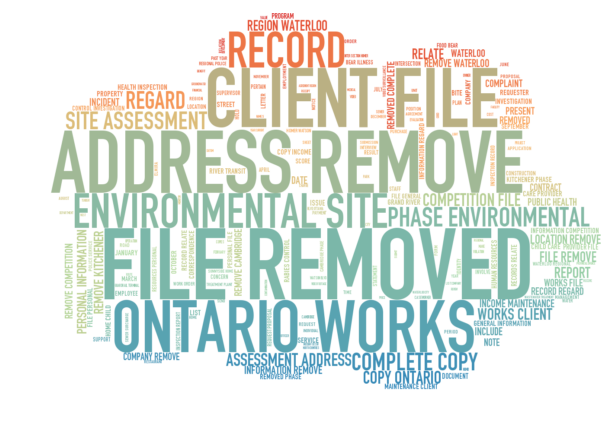

In [215]:
wc = generating_WordCloud(unigrams, 200, True, "img/cloud_mask.png", 'Spectral', 'white',
                         'horizontal')
wc.to_file("img/wordclouds/wordcloud_200_words_with_bigrams_white_Spectral.png")
wc.to_file("img/wordclouds/wordcloud_200_words_with_bigrams_white_Spectral.pdf")

Here is a similar function, the differences are that this time, it adds a title and it returns a plot, not a wordcloud.

In [216]:
def generating_WordCloud_with_title(gram, num_words, collocations_TF, mask_icon, color_palette, u_background_color,
                         color_grad_orientation, plot_title):
    
    gradient_orientation = color_grad_orientation

    icon = Image.open(mask_icon).convert("RGBA")
    mask = Image.new("RGBA", icon.size, (255,255,255))
    mask.paste(icon, icon)
    mask_wordcloud = np.array(mask)

    # Create a linear gradient using the matplotlib color map
    imgsize = icon.size

    if gradient_orientation == "vertical":
        N_elem = imgsize[0]
    else:
        N_elem = imgsize[1]
        
    palette_colormap = str(color_palette + '.mpl_colormap')


    if color_palette == 'Spectral':
        palette = makeMappingArray(N_elem, Spectral_4.mpl_colormap)   # interpolates colors
    elif color_palette == 'RdYlBu':
        palette = makeMappingArray(N_elem, RdYlBu_4.mpl_colormap)
    elif color_palette == 'RdYlGn':
        palette = makeMappingArray(N_elem, RdYlGn_4.mpl_colormap)
    elif color_palette == 'PuOr':
        palette = makeMappingArray(N_elem, PuOr_4.mpl_colormap)
    elif color_palette == 'RdBu':
        palette = makeMappingArray(N_elem, RdBu_4.mpl_colormap)
    else:
        print ("No such palette")
        return None

    for y in range(imgsize[1]):
        for x in range(imgsize[0]):
            if mask.getpixel((x,y)) != (255,255,255):   # Only change nonwhite pixels of icon
                color = palette[x] if gradient_orientation is "vertical" else palette[y]

                # matplotlib color maps are from range of (0,1). Convert to RGB.
                r = int(color[0] * 255)
                g = int(color[1] * 255)
                b = int(color[2] * 255)

                mask.putpixel((x, y), (r, g, b))

    # create coloring from image
    image_colors = ImageColorGenerator(np.array(mask))

    grams_upper = []
    for token in gram:
        grams_upper.append(token.upper())

    wc = WordCloud(
                   font_path = "/Library/Fonts/DIN Condensed Bold.ttf",
                   mask=mask_wordcloud,
                   stopwords=STOPLIST,
                   background_color=u_background_color,
                   width=2500,
                   height=1750,
                   collocations=collocations_TF,
                   max_words=num_words,
                   #max_font_size=100,
                   ).generate(" ".join(grams_upper))

    # generate word cloud
    wc.recolor(color_func=image_colors)
    plt.figure(figsize=(10, 7))
    plt.title(plot_title, fontsize=20, fontweight='bold', y=-0.2)
    plt.imshow(wc, interpolation="bilinear", aspect='auto')
    plt.axis('off')
    
    return plt

Visualizing word clouds with a *cloud* mask, maximum of 200 words, with Spectral palette and white background.

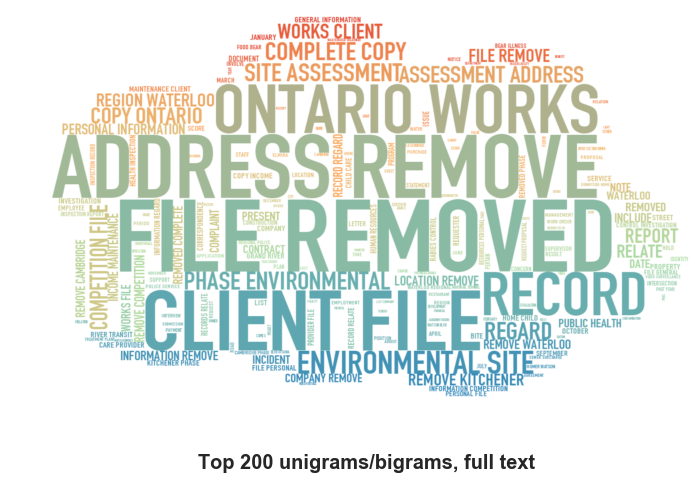

In [217]:
plt = generating_WordCloud_with_title(unigrams, 200, True, "img/cloud_mask.png", 'Spectral', 'white',
                         'horizontal', "Top 200 unigrams/bigrams, full text")
plt.tight_layout()
plt.savefig('./img/wordclouds/wordcloud_200_words_with_bigrams_white_Spectral_with_title.png')
plt.savefig('./img/wordclouds/wordcloud_200_words_with_bigrams_white_Spectral_with_title.pdf')

And with no collocations, this is, with no bigrams, we get something that features the word "remove" quite prominently.

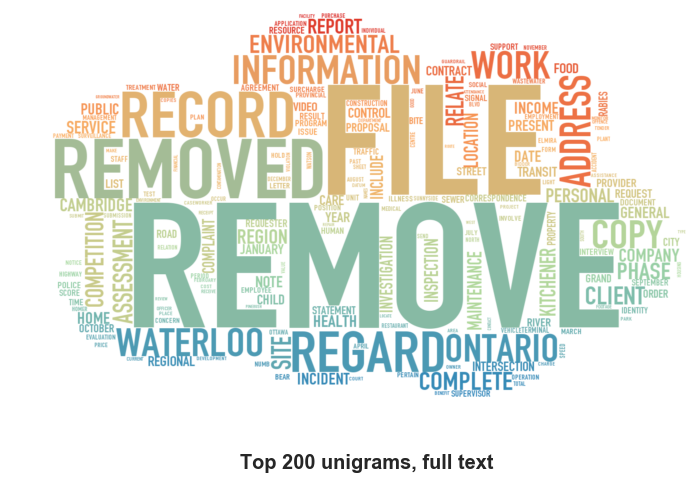

In [218]:
plt = generating_WordCloud_with_title(unigrams, 200, False, "img/cloud_mask.png", 'Spectral', 'white',
                         'horizontal', "Top 200 unigrams, full text")
plt.tight_layout()
plt.savefig('./img/wordclouds/wordcloud_200_words_no_bigrams_white_Spectral_with_title.png')
plt.savefig('./img/wordclouds/wordcloud_200_words_no_bigrams_white_Spectral_with_title.pdf')

## N-grams and Word Clouds after removing phrases that include *"{ ... removed}"*

So, why is the word "remove" so important? It turns out, many of these requests have names of people or locations that needed to be removed for privacy reasons. So, let's reprocess the text taking this into account by using regular expressions.

In [219]:
# {address removed}, {name removed} {names removed} {location removed} {company name removed}
# {intersection removed}
# {request number removed}

new_stop_words = []
regex_phrase = r'(?:\{\w+\s*\w*\s*\w*\s*\w*\s*\w*\s*\w*\}|\(\w+\s*\w*\s*\w*\s*\w*\s*\w*\s*\w*\}|\{\w+\s*\w*\s*\w*\s*\w*\s*\w*\s*\w*\)|\(\w+\s*removed\)|\{\w+\s*\w*\s*\w*\s*\w*\s*\w*\s*\w*\{)'
'''
# Somehow splitting the regEx chain changes the output!
regex_phrase = r'(?:\{\w+\s*\w*\s*\w*\s*\w*\s*\w*\s*\w*\}|\
                  \(\w+\s*\w*\s*\w*\s*\w*\s*\w*\s*\w*\}|\
                  \{\w+\s*\w*\s*\w*\s*\w*\s*\w*\s*\w*\)|\
                  \{\w+\s*\w*\s*\w*\s*\w*\s*\w*\s*\w*\{|\(\w+\s*removed\)|\
                  )'
'''

matches = re.findall(regex_phrase, all_text_merged)
for match in matches:
    #print(match)
    new_stop_words.append(match)

# Change array to a set to remove duplicates
new_stop_words = set(new_stop_words)
# Turn back to a list
new_stop_words = list(new_stop_words)
print("No. of phrases to be removed: {0}".format(len(new_stop_words)))   # 33
print(new_stop_words)
    
    

No. of phrases to be removed: 33
['{intersection removed}', '{company names removed}', '(address removed}', '{address removed}', '(location removed)', '{street name removed}', '{request number removed}', '{addresses removed}', '{institutions removed}', '{location removed}', '{developer removed}', '{facility removed}', '{locations removed}', '{name removed{', '{name and position removed}', '{organization name removed}', '{orgnization name removed}', '{company removed}', '{business removed}', '{company name removed}', '{address}', '{companies removed}', '{restaurant removed}', '(name removed)', '{company name and address removed}', '{Name removed}', '{individual by agent}', '{name removed}', '{date removed}', '{Company name removed}', '{names removed}', '{restaurant name removed}', '(name removed}']


In [220]:
all_text_merged_removed = all_text_merged

# Replace new stop phrases with nothing
for stop in new_stop_words:
    all_text_merged_removed = all_text_merged_removed.replace(stop, '')
    

So, let's find the unigrams, bigrams, trigrams, and n-grams (4-5 words), and their most common occurrences, for this new text.

In [481]:
tokens_rm = prepare_text_tlc(all_text_merged_removed)
unigrams_rm = tokens_rm
bigrams_rm = nltk.bigrams(unigrams_rm)
trigrams_rm = nltk.trigrams(unigrams_rm)
everygrams_rm_4 = nltk.everygrams(unigrams_rm, min_len=4, max_len=4)
everygrams_rm_5 = nltk.everygrams(unigrams_rm, min_len=4, max_len=5)

In [482]:
display_top_grams(unigrams_rm, 1, 10)

No. of unique unigrams: 1331
('file', 295)
('regard', 146)
('record', 136)
('information', 136)
('waterloo', 134)
('copy', 132)
('ontario', 122)
('environmental', 118)
('complete', 117)
('assessment', 113)


In [483]:
display_top_grams(bigrams_rm, 2, 20)

No. of unique bigrams: 4352
(('client', 'file'), 104)
(('ontario', 'works'), 103)
(('environmental', 'site'), 99)
(('site', 'assessment'), 98)
(('phase', 'environmental'), 98)
(('complete', 'copy'), 97)
(('copy', 'ontario'), 84)
(('works', 'client'), 67)
(('competition', 'file'), 64)
(('information', 'competition'), 58)
(('region', 'waterloo'), 51)
(('personal', 'information'), 47)
(('income', 'maintenance'), 39)
(('works', 'file'), 33)
(('public', 'health'), 32)
(('file', 'complete'), 32)
(('record', 'regard'), 31)
(('assessment', 'kitchener'), 30)
(('assessment', 'waterloo'), 25)
(('general', 'information'), 24)


In [484]:
display_top_grams(trigrams_rm, 3, 35)

No. of unique trigrams: 5475
(('environmental', 'site', 'assessment'), 98)
(('phase', 'environmental', 'site'), 97)
(('copy', 'ontario', 'works'), 81)
(('complete', 'copy', 'ontario'), 74)
(('ontario', 'works', 'client'), 67)
(('works', 'client', 'file'), 66)
(('information', 'competition', 'file'), 46)
(('personal', 'information', 'competition'), 35)
(('ontario', 'works', 'file'), 33)
(('site', 'assessment', 'kitchener'), 30)
(('file', 'complete', 'copy'), 28)
(('home', 'child', 'care'), 23)
(('site', 'assessment', 'waterloo'), 22)
(('maintenance', 'client', 'file'), 22)
(('income', 'maintenance', 'client'), 22)
(('site', 'assessment', 'cambridge'), 22)
(('grand', 'river', 'transit'), 21)
(('general', 'information', 'competition'), 21)
(('kitchener', 'phase', 'environmental'), 20)
(('file', 'personal', 'information'), 19)
(('assessment', 'kitchener', 'phase'), 18)
(('public', 'health', 'inspection'), 18)
(('child', 'care', 'provider'), 18)
(('competition', 'file', 'personal'), 18)
(('

In [485]:
display_top_grams(everygrams_rm_4, 4, 20)

No. of unique 4-grams: 5995
(('phase', 'environmental', 'site', 'assessment'), 97)
(('complete', 'copy', 'ontario', 'works'), 72)
(('ontario', 'works', 'client', 'file'), 66)
(('copy', 'ontario', 'works', 'client'), 59)
(('environmental', 'site', 'assessment', 'kitchener'), 30)
(('personal', 'information', 'competition', 'file'), 27)
(('income', 'maintenance', 'client', 'file'), 22)
(('environmental', 'site', 'assessment', 'waterloo'), 22)
(('environmental', 'site', 'assessment', 'cambridge'), 22)
(('file', 'complete', 'copy', 'ontario'), 22)
(('copy', 'ontario', 'works', 'file'), 22)
(('kitchener', 'phase', 'environmental', 'site'), 20)
(('home', 'child', 'care', 'provider'), 18)
(('site', 'assessment', 'kitchener', 'phase'), 18)
(('assessment', 'kitchener', 'phase', 'environmental'), 18)
(('complete', 'copy', 'income', 'maintenance'), 17)
(('client', 'file', 'complete', 'copy'), 17)
(('general', 'information', 'competition', 'file'), 17)
(('competition', 'file', 'personal', 'informat

In [486]:
display_top_grams(everygrams_rm_5, 5, 20)

No. of unique 5-grams: 12327
(('phase', 'environmental', 'site', 'assessment'), 97)
(('complete', 'copy', 'ontario', 'works'), 72)
(('ontario', 'works', 'client', 'file'), 66)
(('copy', 'ontario', 'works', 'client'), 59)
(('copy', 'ontario', 'works', 'client', 'file'), 59)
(('complete', 'copy', 'ontario', 'works', 'client'), 51)
(('phase', 'environmental', 'site', 'assessment', 'kitchener'), 30)
(('environmental', 'site', 'assessment', 'kitchener'), 30)
(('personal', 'information', 'competition', 'file'), 27)
(('environmental', 'site', 'assessment', 'waterloo'), 22)
(('file', 'complete', 'copy', 'ontario'), 22)
(('copy', 'ontario', 'works', 'file'), 22)
(('file', 'complete', 'copy', 'ontario', 'works'), 22)
(('phase', 'environmental', 'site', 'assessment', 'waterloo'), 22)
(('phase', 'environmental', 'site', 'assessment', 'cambridge'), 22)
(('environmental', 'site', 'assessment', 'cambridge'), 22)
(('income', 'maintenance', 'client', 'file'), 22)
(('complete', 'copy', 'ontario', 'works

And just for the fun of visualizing it, wordclouds!

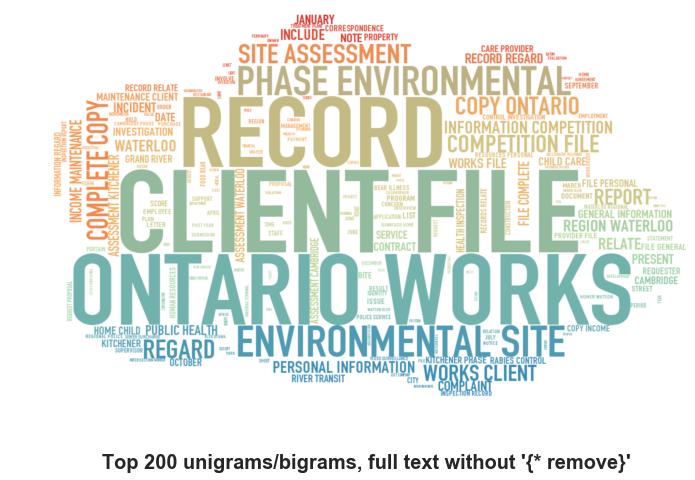

In [246]:
plt = generating_WordCloud_with_title(unigrams_rm, 200, True, "img/cloud_mask.png", 'Spectral', 'white',
                         'horizontal', "Top 200 unigrams/bigrams, full text without \'{* remove}\'")
plt.tight_layout()
plt.savefig('./img/wordclouds/wordcloud_200_words_removed_with_bigrams_white_Spectral_with_title.png')
plt.savefig('./img/wordclouds/wordcloud_200_words_removed_with_bigrams_white_Spectral_with_title.pdf')

And without bigrams:

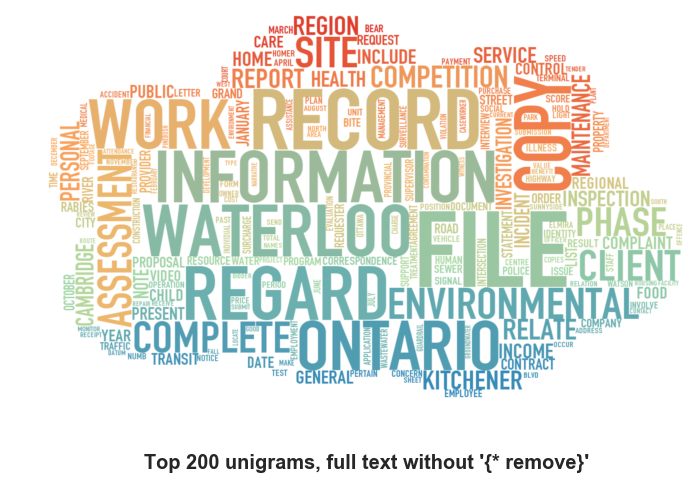

In [247]:
plt = generating_WordCloud_with_title(unigrams_rm, 200, False, "img/cloud_mask.png", 'Spectral', 'white',
                         'horizontal', "Top 200 unigrams, full text without \'{* remove}\'")
plt.tight_layout()
plt.savefig('./img/wordclouds/wordcloud_200_words_removed_no_bigrams_white_Spectral_with_title.png')
plt.savefig('./img/wordclouds/wordcloud_200_words_removed_no_bigrams_white_Spectral_with_title.pdf')

## Most-used Phrases and Decisions

Looking at the n-grams, one finds phrases that commonly appear throughout the requests:

- "ontario works" appears in 9 out of the top 20 n-grams.
- "environmental site (assessment)" as "environmental site" or "site assessment" appears in 9 of the top 20. 

... And those word combinations make up the top 50!

Using bigrams, other few phrases come to light:

- "grand river transit" as "grand river" or "river transit"
- "rabies control" or "control investigation"
- "(public) health inspection"
- "home child care" or "home childcare"
- "food bear" or "bear illness" (Lemmatized version of "Food-borne illness")



Based on these phrases, we try to find if there is a pattern concerning the *Decision*. 

Since we will be working with prepared and processed text, we will just add that cleaned, tokenized, and lemmatized text as a column, called "Edited_Summary" to a new dataframe. 

In [248]:
tokenized_adf = adf.copy()

In [249]:
new_col = []
for index in range(0, len(tokenized_adf)):
    current_line = tokenized_adf['Summary_of_Request'][index]
    for stop in new_stop_words:
        if stop in current_line:
            current_line = current_line.replace(stop, '')
    line_tokens = prepare_text_tlc(current_line)

    rejoined_text =  "".join([" " + i if not i.startswith("'") and i not in string.punctuation 
                              else i for i in line_tokens]).strip()
    new_col.append(rejoined_text)
    
tokenized_adf['Edited_Summary'] = new_col

In [250]:
tokenized_adf.head(5)

Request_Number Request_Type               Source  \
0           98001     Personal           Individual   
1           98002      General           Individual   
2           98003      General             Business   
3           98004      General  Individual by Agent   
4           98005     Personal           Individual   

                                  Summary_of_Request  \
0  GWA file, specifically agreements, cheques and...   
1  Records related to construction on {company na...   
2  Information regarding damage to Regional facil...   
3  Identity of the Sunnyside Home employee who wi...   
4  Regional Solicitor's file for {name removed} r...   

                        Decision  \
0      All information disclosed   
1            Partly non-existent   
2            Partly non-existent   
3       No information disclosed   
4  Information disclosed in part   

                                      Edited_Summary  
0  file specifically agreement cheque monetary in...  
1         records relate construction site 1996 1997  
2  information regard damage regional facility se...  
3  identity sunnyside home employee witness motor...  
4  regional solicitor file regard employment wate...

In [251]:
tokenized_adf.to_csv('data/csv/tokenized_adf_removed.csv', encoding='utf-8', index=False)

While looking at the n-grams, we noted that there are few recurrent phrases and its variations:

* 'ontario works', 'complete copy ontario works client file'
* 'environmental site', 'site assessment', 'environmental site assessment'
* 'grand river', 'river transit', 'grand river transit'
* 'public health', 'health inspection', 'public health inspection'
* 'rabies control', 'control investigation', 'rabies control investigation'
* 'child care', 'care provider', 'child care provider'
* 'food bear', 'bear illness', 'food bear illness'

So, if we are to determine a decision probability based on these phrases, which ones are we going to use?

For the first one, 'ontario works' will encompass most of the requests. For the others, let's find out which phrase represents the majority.



In [252]:
def find_phrase_that_includes_most_requests(string1, string2, string3, df, summary_col, req_col):
    '''
    We will be comparing only three strings this time.
    Function will create three sets containing the request numbers 
    that contain such string in the column summary_col
    of the dataframe df.
    It will compare those sets and print the differences
    '''

    # Find out if the df has both columns 
    assert summary_col in  df, "Column '{0}' not in dataframe".format(summary_col)
    assert req_col in  df, "Column '{0}' not in dataframe".format(req_col)
       
    # Arrays to store the 'Request_Number's
    s1_array = []
    s2_array  = []
    s3_array  = []

    for index in range(0, len(df)):
        current_line = df[summary_col][index]
        if string1 in current_line:
            s1_array.append(df[req_col][index])
        if string2 in current_line:
            s2_array.append(df[req_col][index])
        if string3 in current_line:
            s3_array.append(df[req_col][index])

    s1_set = set(s1_array) 
    s2_set = set(s2_array) 
    s3_set = set(s3_array) 

    if s1_set != s2_set:
        print("set('{0}') is not equal to set('{1}')".format(string1, string2))
    else:
        print("set('{0}') is equal to set('{1}')".format(string1, string2))
    if s2_set != s3_set:
        print("set('{0}') is not equal to set('{1}')".format(string2, string3))
    else:
        print("set('{0}') is equal to set('{1}')".format(string2, string3))
    if s1_set != s3_set:
        print("set('{0}') is not equal to set('{1}')".format(string1, string3))
    else:
        print("Set('{0}') is equal to set('{1}')".format(string1, string3))

    diff_set_12 = s1_set.symmetric_difference(s2_set)
    diff_set_23 = s2_set.symmetric_difference(s3_set) 
    diff_set_13 = s1_set.symmetric_difference(s3_set)

    if diff_set_12:
        print("\nDifferences between set('{0}') and set('{1}') are:".format(string1, string2))
        for index in range(0, len(df)):
            rn = df[req_col][index]
            if rn in diff_set_12:
                print("Request Number: {0}; text: {1}".format(rn, df[summary_col][index]))
        if diff_set_23:
            print("\nDifferences between set('{0}') and set('{1}') are:".format(string2, string3))
            for index in range(0, len(df)):
                rn = df[req_col][index]
                if rn in diff_set_23:
                    print("Request Number: {0}; text: {1}".format(rn, df[summary_col][index]))
            if diff_set_13:
                print("\nDifferences between set('{0}') and set('{1}') are:".format(string1, string3))
                for index in range(0, len(df)):
                    rn = df[req_col][index]
                    if rn in diff_set_13:
                        print("Request Number: {0}; text: {1}".format(rn, df[summary_col][index]))
    elif diff_set_23:
        print("\nDifferences between set('{0}') and set('{1}') are:".format(string2, string3))
        for index in range(0, len(df)):
            rn = df[req_col][index]
            if rn in diff_set_23:
                print("Request Number: {0}; text: {1}".format(rn, df[summary_col][index]))
        if diff_set_13:
            print("\nDifferences between set('{0}') and set('{1}') are:".format(string1, string3))
            for index in range(0, len(df)):
                rn = df[req_col][index]
                if rn in diff_set_13:
                    print("Request Number: {0}; text: {1}".format(rn, df[summary_col][index]))
          
    return None



In [253]:
find_phrase_that_includes_most_requests('environmental site', 'site assessment', 'environmental site assessment',
                                        tokenized_adf, 'Edited_Summary', 'Request_Number')

set('environmental site') is not equal to set('site assessment')
set('site assessment') is equal to set('environmental site assessment')
set('environmental site') is not equal to set('environmental site assessment')

Differences between set('environmental site') and set('site assessment') are:
Request Number: 2016077; text: record environmental concern regard elmsdale drive include information contain environmental site information index


*'environmental site'* is the one that includes the most requests, so let's use that phrase.

In [254]:
find_phrase_that_includes_most_requests('grand river', 'river transit', 'grand river transit',
                                        tokenized_adf, 'Edited_Summary', 'Request_Number')

set('grand river') is equal to set('river transit')
set('river transit') is equal to set('grand river transit')
Set('grand river') is equal to set('grand river transit')


All options give the same result, so let's use the the full phrase, *'grand river transit'*.

In [255]:
find_phrase_that_includes_most_requests('public health', 'health inspection', 'public health inspection',
                                        tokenized_adf, 'Edited_Summary', 'Request_Number')

set('public health') is not equal to set('health inspection')
set('health inspection') is not equal to set('public health inspection')
set('public health') is not equal to set('public health inspection')

Differences between set('public health') and set('health inspection') are:
Request Number: 2006009; text: public health record regard contamination investigation
Request Number: 2006021; text: public health investigation record regard kitchener
Request Number: 2007001; text: public health investigation file regard coli 0157 outbreak requester home care
Request Number: 2007005; text: public health investigation record regard requester daughter coli 0157 infection home child care operate
Request Number: 2015032; text: investigation file note natan somer public health inspector regard investigation salmonella poison
Request Number: 2015040; text: report compile public health inspector carolyn biglow bite place night october 2015
Request Number: 2003002; text: information regard public he

*'public health'* seems to include more requests, so, let's use it.

In [256]:
find_phrase_that_includes_most_requests('rabies control', 'control investigation', 'rabies control investigation',
                                        tokenized_adf, 'Edited_Summary', 'Request_Number')

set('rabies control') is not equal to set('control investigation')
set('control investigation') is equal to set('rabies control investigation')
set('rabies control') is not equal to set('rabies control investigation')

Differences between set('rabies control') and set('control investigation') are:
Request Number: 99013; text: rabies control record relate bite affect report bite involve
Request Number: 2012037; text: rabies control inspection record incident occur
Request Number: 2007023; text: rabies control inspection record involve august 2007
Request Number: 2003011; text: rabies control record incident occur january 2003 kitchener
Request Number: 2003012; text: rabies control record incident occur deal halton public health


Let's use *'rabies control'*.

In [257]:
find_phrase_that_includes_most_requests('food bear', 'bear illness', 'food bear illness',
                                        tokenized_adf, 'Edited_Summary', 'Request_Number')

set('food bear') is equal to set('bear illness')
set('bear illness') is equal to set('food bear illness')
Set('food bear') is equal to set('food bear illness')


All sets are the same, so let's use 'food bear illness'.

In [268]:
find_phrase_that_includes_most_requests('child care', 'home child', 'home child care',
                                        tokenized_adf, 'Edited_Summary', 'Request_Number')

set('child care') is not equal to set('home child')
set('home child') is not equal to set('home child care')
set('child care') is not equal to set('home child care')

Differences between set('child care') and set('home child') are:
Request Number: 2011011; text: receipt provide ontario works client child care november december 2010
Request Number: 94040; text: correction item home childcare provider file

Differences between set('home child') and set('home child care') are:
Request Number: 94040; text: correction item home childcare provider file

Differences between set('child care') and set('home child care') are:
Request Number: 2011011; text: receipt provide ontario works client child care november december 2010


Let's use both 'home child'.

Now that we know which phrases to use, let's analyze the decisions based on those.

In [271]:
# Looking at acceptance rates based on the following phrases
# 'ontario works'
# 'environmental site'
# 'grand river transit'
# 'rabies control'
# 'public health inspection'
# 'food bear illness'
# 'home child'

list_common_phrases = {'ontario works', 'environmental site', 
                       'grand river transit', 'public health', 
                       'rabies control', 'food bear illness',
                       'home child'}


Making a matrix of the number of decisions for each of these phrases,

In [272]:
# Defining the unique decisions as our rows of our new dataframe
counter_rows = np.append(tokenized_adf.Decision.unique(), 'All')

# Starting a dataframe with such rows, and the common phrases as columns. Set initial values of zero
counter_df = pd.DataFrame(0, index=counter_rows, columns=list_common_phrases)

# Changing values to occurrences based on decisions
for index in range(0, len(tokenized_adf)):
    current_line = tokenized_adf['Edited_Summary'][index]
    current_decision = tokenized_adf['Decision'][index]
    for phrase in list_common_phrases:
        if phrase in current_line:
            counter_df[phrase]['All'] = counter_df[phrase]['All'] + 1
            counter_df[phrase][current_decision] = counter_df[phrase][current_decision] + 1
    
counter_df

food bear illness  rabies control  \
All information disclosed                        7               3   
Partly non-existent                              0               0   
No information disclosed                         0               0   
Information disclosed in part                    4              15   
Transferred                                      0               1   
No records exist                                 2               0   
Request withdrawn                                0               0   
Correction granted                               0               0   
Correction refused                               0               0   
Abandoned                                        0               0   
No additional records exist                      0               0   
Statement of disagreement filed                  0               0   
All                                             13              19   

                                 ontario works  home child  \
All information disclosed                   41           1   
Partly non-existent                          5           0   
No information disclosed                     1           2   
Information disclosed in part               31          15   
Transferred                                  1           0   
No records exist                            11           0   
Request withdrawn                           10           3   
Correction granted                           0           2   
Correction refused                           0           0   
Abandoned                                    3           0   
No additional records exist                  0           0   
Statement of disagreement filed              0           0   
All                                        103          23   

                                 environmental site  grand river transit  \
All information disclosed                        24                   10   
Partly non-existent                               7                    0   
No information disclosed                          0                    0   
Information disclosed in part                     5                    4   
Transferred                                       0                    0   
No records exist                                 41                    0   
Request withdrawn                                22                    1   
Correction granted                                0                    0   
Correction refused                                0                    0   
Abandoned                                         0                    2   
No additional records exist                       0                    0   
Statement of disagreement filed                   0                    0   
All                                              99                   17   

                                 public health  
All information disclosed                    7  
Partly non-existent                          0  
No information disclosed                     1  
Information disclosed in part               16  
Transferred                                  2  
No records exist                             2  
Request withdrawn                            4  
Correction granted                           0  
Correction refused                           0  
Abandoned                                    0  
No additional records exist                  0  
Statement of disagreement filed              0  
All                                         32

What fraction of entries have these phrases?

In [275]:
# Total number of requests with this phrases
end = len(counter_df)

total_w_phrases = counter_df[end-1:end].sum(axis=1)
total_w_phrases/tokenized_adf.shape[0]

All    0.339246
dtype: float64

So, 34% of the requests made over 26 years involve one of the following phrases: 'ontario works', 'environmental site', 'grand river transit', 'public health inspection', 'rabies control', 'hone child', or 'food bear illness'. 

In order to normalize the results, we should remove the "All" column.

In [276]:
counter_df_Dec = counter_df.drop('All')

In [277]:
counter_df_Dec_by_Decision = counter_df_Dec.div(counter_df_Dec.sum(axis=0), axis=1)
counter_df_Dec_by_Decision

food bear illness  rabies control  \
All information disclosed                 0.538462        0.157895   
Partly non-existent                       0.000000        0.000000   
No information disclosed                  0.000000        0.000000   
Information disclosed in part             0.307692        0.789474   
Transferred                               0.000000        0.052632   
No records exist                          0.153846        0.000000   
Request withdrawn                         0.000000        0.000000   
Correction granted                        0.000000        0.000000   
Correction refused                        0.000000        0.000000   
Abandoned                                 0.000000        0.000000   
No additional records exist               0.000000        0.000000   
Statement of disagreement filed           0.000000        0.000000   

                                 ontario works  home child  \
All information disclosed             0.398058    0.043478   
Partly non-existent                   0.048544    0.000000   
No information disclosed              0.009709    0.086957   
Information disclosed in part         0.300971    0.652174   
Transferred                           0.009709    0.000000   
No records exist                      0.106796    0.000000   
Request withdrawn                     0.097087    0.130435   
Correction granted                    0.000000    0.086957   
Correction refused                    0.000000    0.000000   
Abandoned                             0.029126    0.000000   
No additional records exist           0.000000    0.000000   
Statement of disagreement filed       0.000000    0.000000   

                                 environmental site  grand river transit  \
All information disclosed                  0.242424             0.588235   
Partly non-existent                        0.070707             0.000000   
No information disclosed                   0.000000             0.000000   
Information disclosed in part              0.050505             0.235294   
Transferred                                0.000000             0.000000   
No records exist                           0.414141             0.000000   
Request withdrawn                          0.222222             0.058824   
Correction granted                         0.000000             0.000000   
Correction refused                         0.000000             0.000000   
Abandoned                                  0.000000             0.117647   
No additional records exist                0.000000             0.000000   
Statement of disagreement filed            0.000000             0.000000   

                                 public health  
All information disclosed              0.21875  
Partly non-existent                    0.00000  
No information disclosed               0.03125  
Information disclosed in part          0.50000  
Transferred                            0.06250  
No records exist                       0.06250  
Request withdrawn                      0.12500  
Correction granted                     0.00000  
Correction refused                     0.00000  
Abandoned                              0.00000  
No additional records exist            0.00000  
Statement of disagreement filed        0.00000

Now we can make a plot of the results.

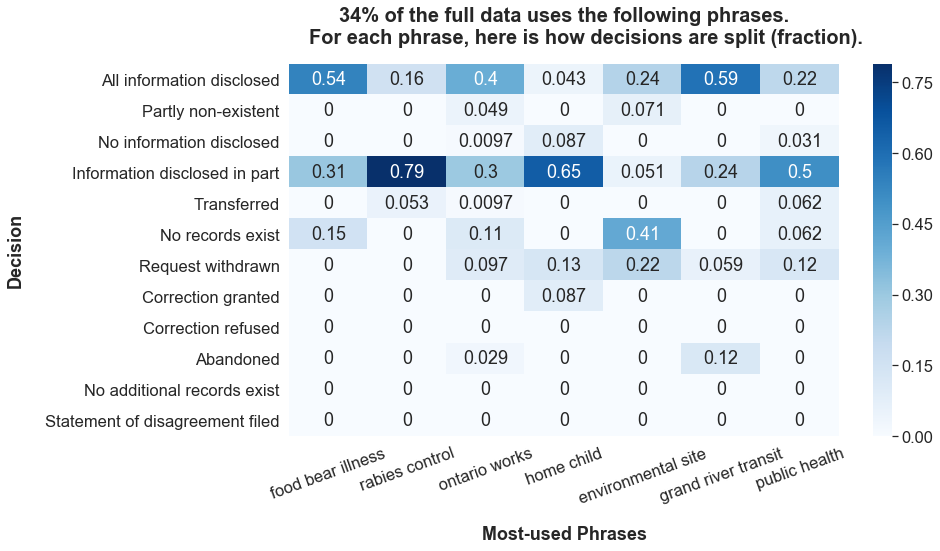

In [285]:
fig, ax = plt.subplots(figsize=(14, 8))
sns.set_context("notebook", font_scale=1.5)
sns.heatmap(counter_df_Dec_by_Decision, annot=True, fmt='0.2g', cmap='Blues',
            xticklabels=counter_df_Dec_by_Decision.columns, yticklabels=counter_df_Dec_by_Decision.index)

plt.ylabel('Decision', fontweight='bold', fontsize=18, labelpad=20)
plt.xlabel('Most-used Phrases', fontweight='bold', fontsize=18, labelpad=20)
plt.xticks(rotation=20)
ax.set_title(label='34% of the full data uses the following phrases.\n \
       For each phrase, here is how decisions are split (fraction).', fontweight='bold', size=20, pad=20)
plt.tight_layout()
plt.savefig('./img/decisions_vs_most_used_phrases_heatmap_half_data.png')
plt.savefig('./img/decisions_vs_most_used_phrases_heatmap_half_data.pdf')

It is interesting to note that for these phrases, "No information disclosed" decision was minimal, except perhaps for "home child care'. In summary, 34% of all of our data contains these phrases, and of those phrases,

- *"food bear illness"*: 85% of the cases got full or partial information disclosed, with 15% where no information exists.
- *"environmental site"*: there was no information for 42% of the cases, for 22% of the cases the request was withdrawn. Full or partial information was given to 29%, while the remaining 7% had partially non-existent information.  
- *"ontario works"*: 70% got full or partial information disclosed, 13% of the cases were abandoned or withdrawn, information did not exist for 11%, while 5% had only partial existing information, and 1% got transferred.
- *"grand river transit"*: 82% of cases got a full or partial information disclosed, while 18% of the cases were abandoned or withdrawn.
- *"rabies control"* got about 95% with all or partially information disclosed, and 5% of the cases were transferred.
- *"public health"*: 72% got full or partial information disclosed, 12% of the requests were withdrawn, 6% had no records, 6% were transferred,  and 3% got no information disclosed.

Visualizing same data in pie charts:

In [286]:
def display_donut_charts(df, title, figsize_x, figsize_y, n_subplot_x, n_subplot_y):
    '''
    Displays donut charts for data in a pandas dataframe df
    Each column in the df is a chart, whose labels are the indices of the df.
        
    plt.subplots(figsize=(figsize_x, figsize_y)
    fig.add_subplot(n_subplot_y, n_subplot_x, counter+1)
    '''

    colormap_viridis_sub = np.array([
    "#20A387FF", "#3CBB75FF", "#73D055FF", "#B8DE29FF", "#FDE725FF",
    "#1F968BFF", "#29AF7FFF", "#55C667FF", "#95D840FF", "#DCE319FF",
    "#440154FF", "#482677FF", "#404788FF", "#33638DFF", "#287D8EFF",
    "#481567FF", "#453781FF", "#39568CFF", "#2D708EFF", "#238A8DFF",
     ])
    
    fig, axs = plt.subplots(figsize=(figsize_x, figsize_y), frameon=False) 
    plt.box(False)
    plt.axis('off')

    plt.title(title, fontweight='bold', size=22, pad=40)
    plt.subplots_adjust(hspace = 1.4)

    counter = 0
    for col in df.columns:
        labels = []
        sizes = []

        nitems = len(df)

        for item in range(0, nitems):
            label = df.index[item]
            size = df.loc[label, col]
            if size > 0:
                labels.append(label)
                sizes.append(size)

        axs = fig.add_subplot(n_subplot_y, n_subplot_x, counter+1)

        axs.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90, pctdistance=0.85,
               labeldistance = 1.05, textprops={'fontsize': 12},colors=colormap_viridis_sub)

        #draw circle
        centre_circle = plt.Circle((0,0), 0.70, fc='white')
        fig = plt.gcf()
        fig.gca().add_artist(centre_circle) 
        axs.set_title(label=col, fontweight='bold', size=18)
        counter += 1

    plt.show()
    return fig, axs

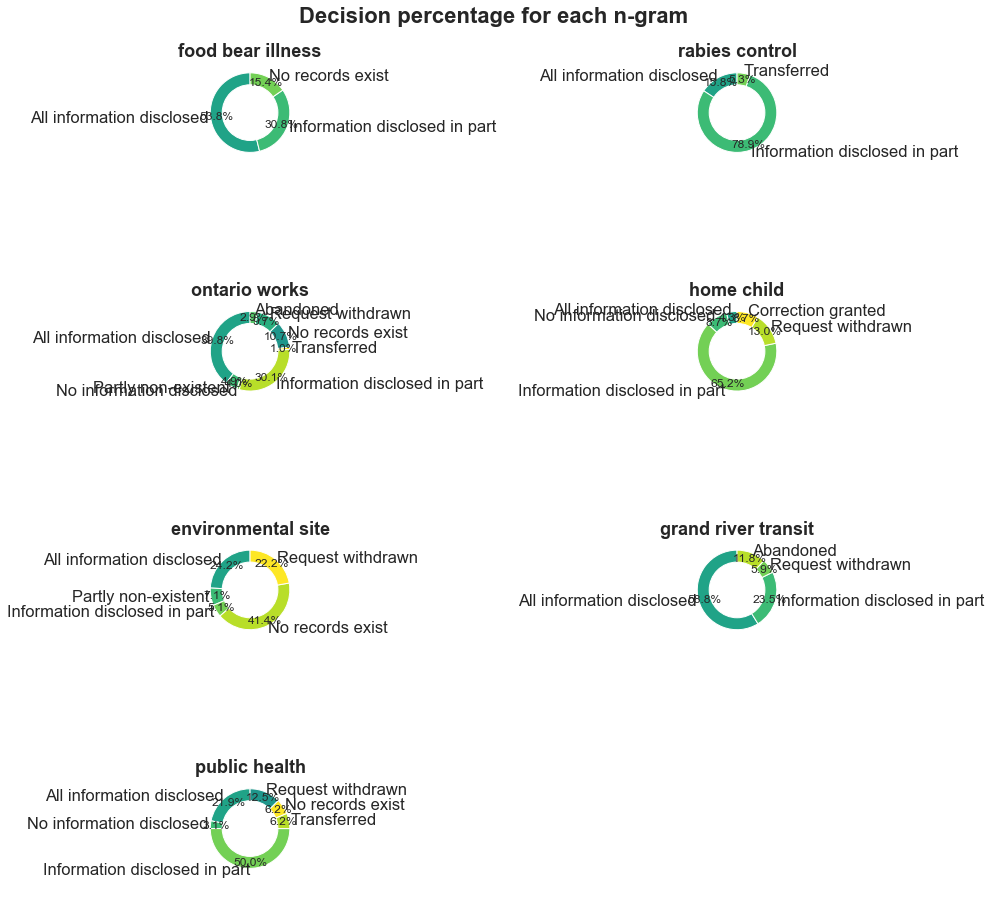

In [288]:
fig, axs = display_donut_charts(counter_df_Dec_by_Decision, 'Decision percentage for each n-gram',
                     16, 15, 2, 4)
fig.tight_layout()
fig.savefig('./img/decision_percentage_most_used_phrases_donuts.png')
fig.savefig('./img/decision_percentage_most_used_phrases_donuts.pdf')

In [291]:
counter_df_Dec_by_Decision_inv = counter_df_Dec.T
counter_df_by_Source_inv = counter_df_Dec_by_Decision_inv.div(counter_df_Dec_by_Decision_inv.sum(axis=0), axis=1)
counter_df_by_Source_inv = counter_df_by_Source_inv.dropna(axis=1)
counter_df_by_Source_inv

All information disclosed  Partly non-existent  \
food bear illness                     0.075269             0.000000   
rabies control                        0.032258             0.000000   
ontario works                         0.440860             0.416667   
home child                            0.010753             0.000000   
environmental site                    0.258065             0.583333   
grand river transit                   0.107527             0.000000   
public health                         0.075269             0.000000   

                     No information disclosed  Information disclosed in part  \
food bear illness                        0.00                       0.044444   
rabies control                           0.00                       0.166667   
ontario works                            0.25                       0.344444   
home child                               0.50                       0.166667   
environmental site                       0.00                       0.055556   
grand river transit                      0.00                       0.044444   
public health                            0.25                       0.177778   

                     Transferred  No records exist  Request withdrawn  \
food bear illness           0.00          0.035714              0.000   
rabies control              0.25          0.000000              0.000   
ontario works               0.25          0.196429              0.250   
home child                  0.00          0.000000              0.075   
environmental site          0.00          0.732143              0.550   
grand river transit         0.00          0.000000              0.025   
public health               0.50          0.035714              0.100   

                     Correction granted  Abandoned  
food bear illness                   0.0        0.0  
rabies control                      0.0        0.0  
ontario works                       0.0        0.6  
home child                          1.0        0.0  
environmental site                  0.0        0.0  
grand river transit                 0.0        0.4  
public health                       0.0        0.0

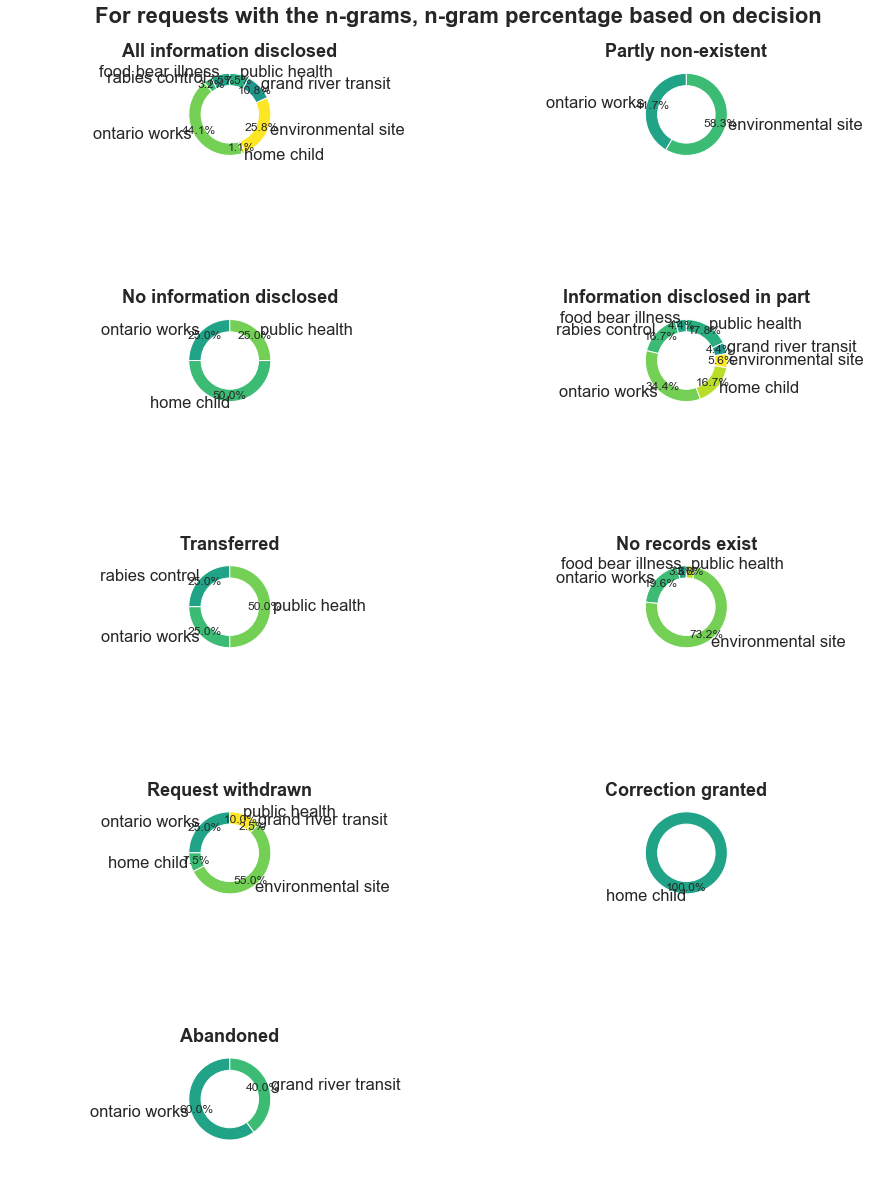

In [293]:
fig, axs = display_donut_charts(counter_df_by_Source_inv, 
                     'For requests with the n-grams, n-gram percentage based on decision',
                     15, 20, 2, 5)

fig.tight_layout()
fig.savefig('./img/ngrams_percentage_for_each_decision_most_used_phrases_donuts.png')
fig.savefig('./img/ngrams_percentage_for_each_decision_most_used_phrases_donuts.pdf')

In [294]:
# tokenized_adf[tokenized_adf['Edited_Summary'].str.contains('environmental')]

## *Summary_of_Request* Statistics

It is be also interesting to see with how much data our ML algorithm would be working. This is, what is the length of those "Summary_of_Request". Remember we don't get the full version submitted for review, but the summary made by the clerk. 

First, let's examine the full text we obtained directly from the files.

In [295]:
num_chars = []
num_words = []
counter = 0

for index in range(0, len(all_text)):
    chars_num = len(all_text[index])
    words_num = len(parser(all_text[index]))
    num_chars.append(chars_num)
    num_words.append(words_num)
    if words_num > 100:
        counter += 1
        print(all_text[index])
        print("Number of characters: {0}".format(chars_num))
        number_words = parser(all_text[index])
        print("Number of words: {0} \n".format(words_num))
print("Total number of entries with more than 100 words: {0}".format(counter))


1. A copy of the successful proposal in response to the RFP C2014-39 for Tender Preparation, Contract Administration and Construction Inspection Services for the Construction of the Waterloo Spur Line Trail from Regina Street in the City of Waterloo to Ahrens Street in the City of Kitchener issued by the Regional Municipality of Waterloo on October 15, 2014.� Please exclude any promotional material that may have been submitted with the proposal and may be considered proprietary. 2. The total number of submissions and the dollar value of the top three submissions for RFP C2014-39.
Number of characters: 586
Number of words: 106 

1) Records for the past two years up to most current for the inspection, testing and maintaining of the traffic control signal system sub-systems at the intersection of Homer Watson Blvd. and Ottawa St. pursuant to "ONTARIO REGULATION 239/02 MINIMUM MAINTENANCE STANDARDS FOR MUNICIPAL HIGHWAYS", section 14 subsection (1).  2) Records for the past two years up to

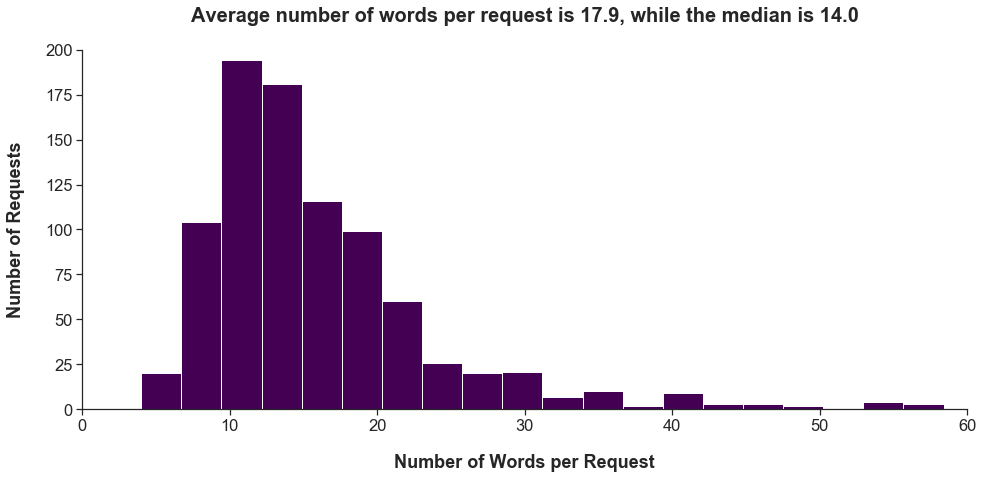

In [299]:
np_num_words = np.array(num_words)
mean_words = np_num_words.mean()
median_words = np.median(num_words)

sns.set_style("ticks")
sns.set_context("notebook", font_scale=1.5)

fig = plt.figure(figsize=(14, 7))
plt.xlim(0, 60)
plt.ylim(0, 200)
plt.xlabel('Number of Words per Request', fontweight='bold', fontsize=18, labelpad=20)
plt.ylabel('Number of Requests', fontweight='bold', fontsize=18, labelpad=20)
sns.distplot(num_words, bins=100, kde=False, hist_kws={"alpha": 1, "color": "#440154FF"}, )
sns.despine()

plot_title = "Average number of words per request is {0:.1f}, while the median is {1}\n".\
              format(mean_words, median_words)
plt.title(plot_title, fontweight='bold', size=20)
plt.tight_layout()
plt.savefig('./img/histogram_num_of_words_requests_full_text.png')
plt.savefig('./img/histogram_num_of_words_requests_full_text.pdf')

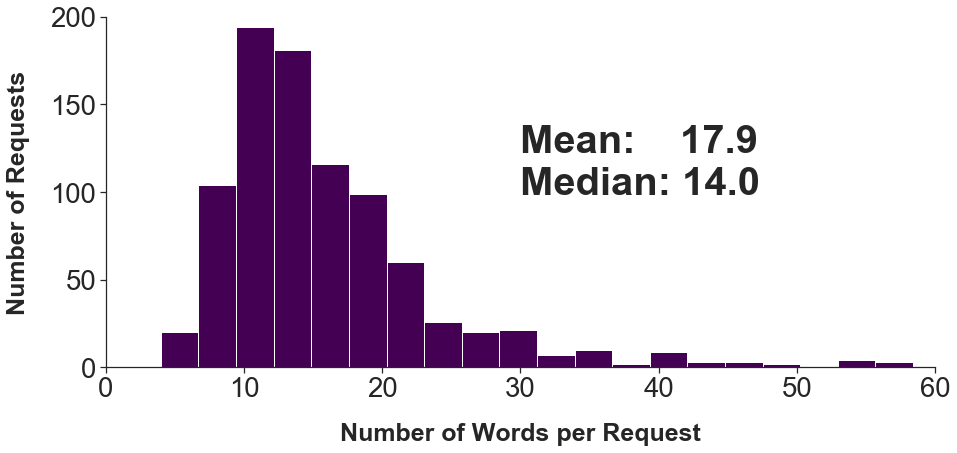

In [300]:
np_num_words = np.array(num_words)
mean_words = np_num_words.mean()
median_words = np.median(num_words)

sns.set_style("ticks")
sns.set_context("notebook", font_scale=2.5)

fig = plt.figure(figsize=(14, 7))
plt.xlim(0, 60)
plt.ylim(0, 200)
plt.xlabel('Number of Words per Request', fontweight='bold', fontsize=25, labelpad=20)
plt.ylabel('Number of Requests', fontweight='bold', fontsize=25, labelpad=20)
sns.distplot(num_words, bins=100, kde=False, hist_kws={"alpha": 1, "color": "#440154FF"}, )
sns.despine()

plot_title = "Mean:    {0:.1f} \nMedian: {1}\n".\
              format(mean_words, median_words)
plt.text(30, 75, plot_title, fontsize=40, fontweight='bold')
plt.tight_layout()
plt.savefig('./img/histogram_num_of_words_requests_full_text_mu.pdf')
plt.savefig('./img/histogram_num_of_words_requests_full_text_mu.png')

As for the tokenized version of it:

In [301]:
all_text_tokenized = tokenized_adf['Edited_Summary']

# Merging all the requests into a single line
all_text_tokenized_merged = ''
for lines in range(0, len(all_text_tokenized)):
    all_text_tokenized_merged = all_text_tokenized_merged + ' ' + all_text_tokenized[lines]


In [312]:
num_chars_t = []
num_words_t = []
small_req = []
counter = 0
counter_sm = 0

for index in range(0, len(all_text_tokenized)):
    chars_num_t = len(all_text_tokenized[index])
    words_num_t = len(parser(all_text_tokenized[index]))
    num_chars_t.append(chars_num_t)
    num_words_t.append(words_num_t)
    if words_num_t > 100:
        counter += 1
        print(all_text_tokenized[index])
        print("Number of characters: {0}".format(chars_num_t))
        number_words = parser(all_text_tokenized[index])
        print("Number of words: {0} \n".format(words_num_t))
    if words_num_t < 6:
        small_req.append(all_text_tokenized[index])
        counter_sm += 1
        
print("Total number of entries with more than 100 words: ", counter)
print("Total number of entries with less than 6 words: {0}, which is\
     {1:.2f}% of the total number of requests".format(counter_sm,\
      (100.*counter_sm / len(all_text_tokenized))))


records past year current inspection test maintain traffic control signal intersection homer watson blvd ottawa pursuant ontario regulation 239/02 minimum maintenance standards municipal highways section subsection records past year current inspection test maintain conflict monitor(s intersection homer watson blvd ottawa pursuant ontario regulation 239/02 minimum maintenance standards municipal highways section subsection records past year current inspection test maintenance light camera intersection homer watson blvd ottawa records past year current year corrective maintenance need place traffic control signal intersection homer watson blvd ottawa records past year current year corrective maintenance need place conflict monitor(s intersection homer watson blvd ottawa records past year current year corrective maintenance need place light camera intersection homer watson blvd ottawa
Number of characters: 894
Number of words: 114 

Total number of entries with more than 100 words:  1
Tot

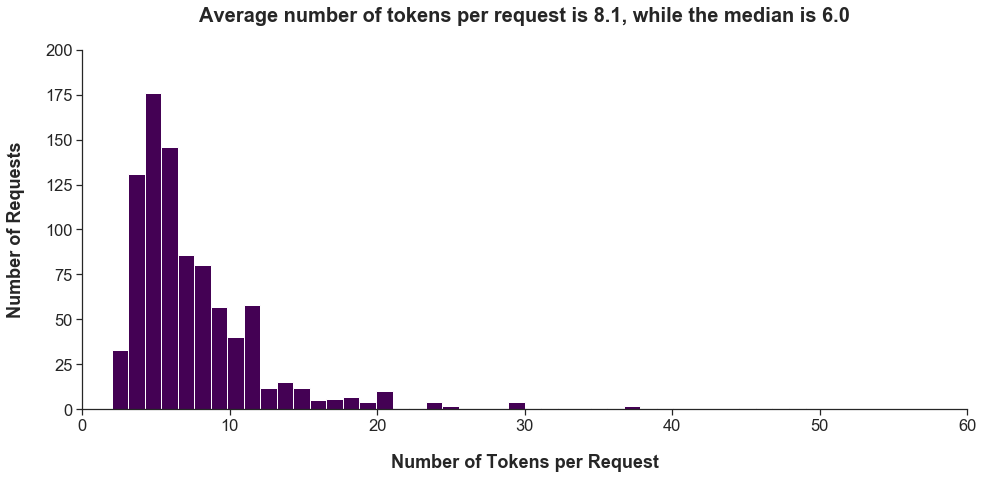

In [318]:
np_num_words_t = np.array(num_words_t)
mean_words_t = np_num_words_t.mean()
median_words_t = np.median(num_words_t)

sns.set_style("ticks")
sns.set_context("notebook", font_scale=1.5)
fig = plt.figure(figsize=(14, 7))
plt.xlim(0, 60)
plt.ylim(0, 200)
plt.xlabel('Number of Tokens per Request', fontweight='bold', fontsize=18, labelpad=20)
plt.ylabel('Number of Requests', fontweight='bold', fontsize=18, labelpad=20)
sns.distplot(num_words_t, bins=100, kde=False, hist_kws={"alpha": 1, "color": "#440154FF"},)
sns.despine()
plot_title = "Average number of tokens per request is {0:.1f}, while the median is {1}\n".\
              format(mean_words_t, median_words_t)
plt.title(plot_title, fontweight='bold', size=20)
plt.tight_layout()
plt.savefig('./img/histogram_num_of_tokens_requests_full_text.png')
plt.savefig('./img/histogram_num_of_tokens_requests_full_text.pdf')


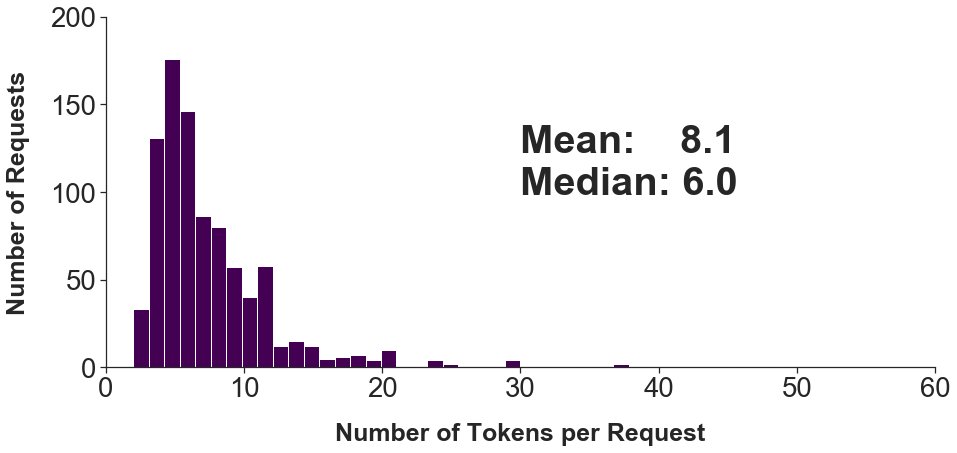

In [319]:
np_num_words_t = np.array(num_words_t)
mean_words_t = np_num_words_t.mean()
median_words_t = np.median(num_words_t)

sns.set_style("ticks")
sns.set_context("notebook", font_scale=2.5)
fig = plt.figure(figsize=(14, 7))
plt.xlim(0, 60)
plt.ylim(0, 200)
plt.xlabel('Number of Tokens per Request', fontweight='bold', fontsize=25, labelpad=20)
plt.ylabel('Number of Requests', fontweight='bold', fontsize=25, labelpad=20)
sns.distplot(num_words_t, bins=100, kde=False, hist_kws={"alpha": 1, "color": "#440154FF"},)
sns.despine()
plot_title = "Mean:    {0:.1f} \nMedian: {1}\n".\
              format(mean_words_t, median_words_t)
plt.text(30, 75, plot_title, fontsize=40, fontweight='bold')
plt.tight_layout()
plt.savefig('./img/histogram_num_of_tokens_requests_full_text_mu.pdf')
plt.savefig('./img/histogram_num_of_tokens_requests_full_text_mu.png')


In [305]:
sns.set_context("notebook", font_scale=1.5)

Seven words (6!), the median, is not much with which to work...

38% of the requests have 5 words or less. They are listed below.

In [313]:
small_req[:20]

['unit price page contract',
 'various record regard voice radio',
 'home child care provider file',
 'records regard filter material supply',
 'environmental enforcement services file hamburg',
 'salary hire competition record relate',
 'investigative report plumb apartment',
 'records relate complaint cambridge',
 'personnel file period 1990/10/01 1999/10/31',
 'rabies control investigation file',
 'phase environmental site assessment cambridge',
 'phase environmental site assessment cambridge',
 'winning blueprinting service 2012',
 'phase environmental site assessment cambridge',
 'phase environmental site assessment waterloo',
 'phase environmental site assessment elmira',
 'phase environmental site assessment kitchener',
 'phase environmental site assessment cambridge',
 'rabies control investigation record',
 'phase environmental site assessment cambridge']

In [314]:
df_small_req = pd.DataFrame({'Tokenized_Requests_lt_6': small_req})


Of those 340 *small requests*, some are the same type of requests. We break down the number and phases below. We only show those with more than 2 cases. 

In [315]:
#df_small_req['Tokenized_Requests_lt_6'].unique()
print("Number of unique values: ", df_small_req['Tokenized_Requests_lt_6'].nunique())
df_small_req['Tokenized_Requests_lt_6'].value_counts().head(12)


Number of unique values:  158


phase environmental site assessment kitchener    30
personal information competition file            23
phase environmental site assessment waterloo     22
phase environmental site assessment cambridge    22
complete copy ontario works file                 21
general information competition file             16
human resources personal file                    10
complete ontario works file                       7
home child care provider file                     7
phase environmental site assessment elmira        6
personal information competition files            4
client file                                       4
Name: Tokenized_Requests_lt_6, dtype: int64

## POS Tagging

How about tag types? For this we will use spaCy.

One can do the analysis including empty spaces and punctuation. Instead, we chose to remove them first, therefore, we need to tokenize the text and then remove unwanted characters and symbols.  


However, the *nlp( )* function of spaCy, the one that will provide the tags, requires a string. We will need to stitch back together the tokens.

We will also use the text *all_text_merged_removed* instead of *all_text_merged* for this analysis. Comparing both outputs, strings such as *{name removed}* or *{location removed}* make up to 2% of the noun and verb POS tags.

In [316]:
# Tokenizing text, while removing symbols
full_text_tok = prepare_text_for_pos_tagging(all_text_merged_removed)
print(len(full_text_tok))

# Merging all the tokens into a single line
full_text = ''
for words in range(0, len(full_text_tok)):
    full_text = full_text + ' ' + full_text_tok[words]


12102


In [317]:
full_text_nlp = nlp(full_text)    # spaCy nlp()

tags = []    # Array where the spacy tags will be stored

for token in full_text_nlp:
    tags.append(token.tag_)

tags_df = pd.DataFrame(data=tags, columns=['Tags'])

print("Number of unique tag values: {0}".format(tags_df['Tags'].nunique()))
print("Total number of words: {0}".format(len(tags_df['Tags'])))

# Make a dataframe out of unique values
tags_value_counts = tags_df['Tags'].value_counts(dropna=True, sort=True)
tags_value_counts_df = tags_value_counts.rename_axis('Unique_Values').reset_index(name='Counts')

# And normalizing the count values
tags_value_counts_df['Normalized_Count'] = tags_value_counts_df['Counts'] / len(tags_df['Tags'])

tags_value_counts_df.head(10)


Number of unique tag values: 37
Total number of words: 12133


Unique_Values  Counts  Normalized_Count
0            NN    4126          0.340064
1            IN    2203          0.181571
2           NNS    1170          0.096431
3            JJ    1138          0.093794
4            CD     895          0.073766
5            DT     662          0.054562
6            CC     467          0.038490
7           VBG     343          0.028270
8           VBN     287          0.023654
9            VB     120          0.009890

Now, for those who can't remember what all of those tags mean, let's add the explanation as a new column called "Decoded" by using spaCy's function *explain( )*.

In [320]:
uv_decoded = []

for val in tags_value_counts_df['Unique_Values']:
    uv_decoded.append(spacy.explain(val))

tags_value_counts_df['Decoded'] = uv_decoded
tags_value_counts_df

Unique_Values  Counts  Normalized_Count  \
0             NN    4126          0.340064   
1             IN    2203          0.181571   
2            NNS    1170          0.096431   
3             JJ    1138          0.093794   
4             CD     895          0.073766   
5             DT     662          0.054562   
6             CC     467          0.038490   
7            VBG     343          0.028270   
8            VBN     287          0.023654   
9             VB     120          0.009890   
10           VBP     112          0.009231   
11           PRP     104          0.008572   
12            TO      91          0.007500   
13            RB      76          0.006264   
14           VBD      58          0.004780   
15           VBZ      51          0.004203   
16           POS      38          0.003132   
17           WDT      37          0.003050   
18           NNP      36          0.002967   
19             .      30          0.002473   
20            MD      26          0.002143   
21          PRP$      12          0.000989   
22            RP      11          0.000907   
23           WRB       9          0.000742   
24            WP       5          0.000412   
25            FW       4          0.000330   
26           JJS       4          0.000330   
27           RBS       4          0.000330   
28           AFX       3          0.000247   
29            UH       2          0.000165   
30            EX       2          0.000165   
31            XX       2          0.000165   
32           JJR       1          0.000082   
33            LS       1          0.000082   
34           PDT       1          0.000082   
35            ''       1          0.000082   
36                     1          0.000082   

                                      Decoded  
0                      noun, singular or mass  
1   conjunction, subordinating or preposition  
2                                noun, plural  
3                                   adjective  
4                             cardinal number  
5                                  determiner  
6                   conjunction, coordinating  
7          verb, gerund or present participle  
8                       verb, past participle  
9                             verb, base form  
10      verb, non-3rd person singular present  
11                          pronoun, personal  
12                             infinitival to  
13                                     adverb  
14                           verb, past tense  
15          verb, 3rd person singular present  
16                          possessive ending  
17                              wh-determiner  
18                      noun, proper singular  
19          punctuation mark, sentence closer  
20                      verb, modal auxiliary  
21                        pronoun, possessive  
22                           adverb, particle  
23                                  wh-adverb  
24                       wh-pronoun, personal  
25                               foreign word  
26                     adjective, superlative  
27                        adverb, superlative  
28                                      affix  
29                               interjection  
30                          existential there  
31                                    unknown  
32                     adjective, comparative  
33                           list item marker  
34                              predeterminer  
35                     closing quotation mark  
36                                       None

Given the range of values, it does not make much sense to plot anything under 30 occurrences.

In [321]:
tags_value_counts_df_gt20 = tags_value_counts_df[tags_value_counts_df['Counts'] > 30]

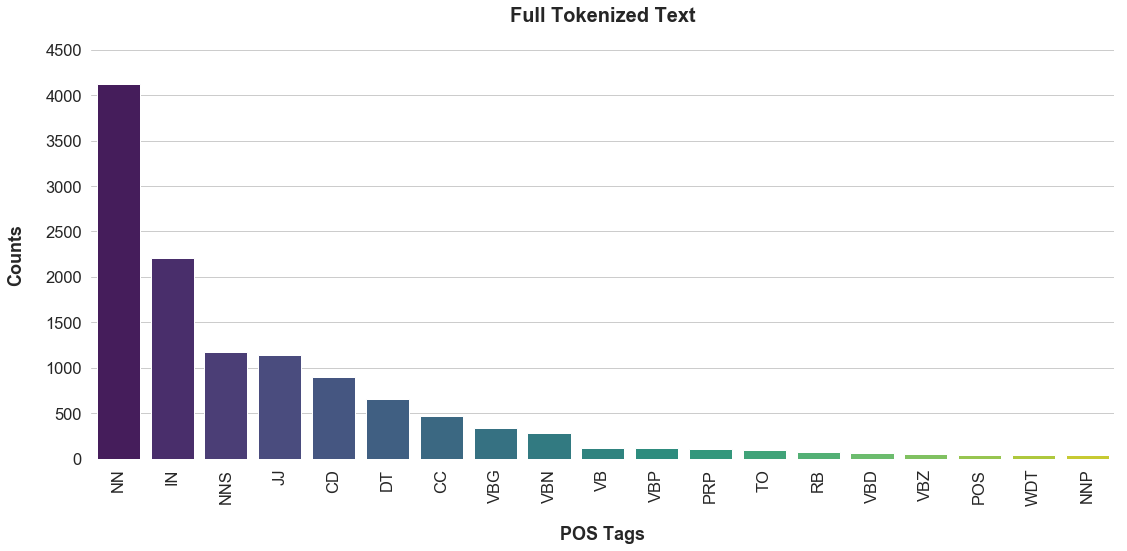

In [331]:
categ = list(tags_value_counts_df_gt20['Unique_Values'])

sns.set_style("whitegrid")
sns.set_context("notebook", font_scale=1.5)

f, ax = plt.subplots(figsize=(16, 8))

sns.barplot(y=tags_value_counts_df_gt20['Counts'], x=categ, palette=("viridis"))
ax.set(ylim=(0, 4500))
plt.xticks(rotation=90)
sns.despine(left=True, bottom=True)

plt.xlabel('POS Tags', fontweight='bold', fontsize=18, labelpad=20)
plt.ylabel('Counts', fontweight='bold', fontsize=18, labelpad=20)
plot_title = "Full Tokenized Text\n"
plt.title(plot_title, fontweight='bold', size=20)
plt.tight_layout()
plt.savefig('./img/histogram_pos_tags_full_text.png')
plt.savefig('./img/histogram_pos_tags_full_text.pdf')

And to be more explicit, let's write the descriptions instead.

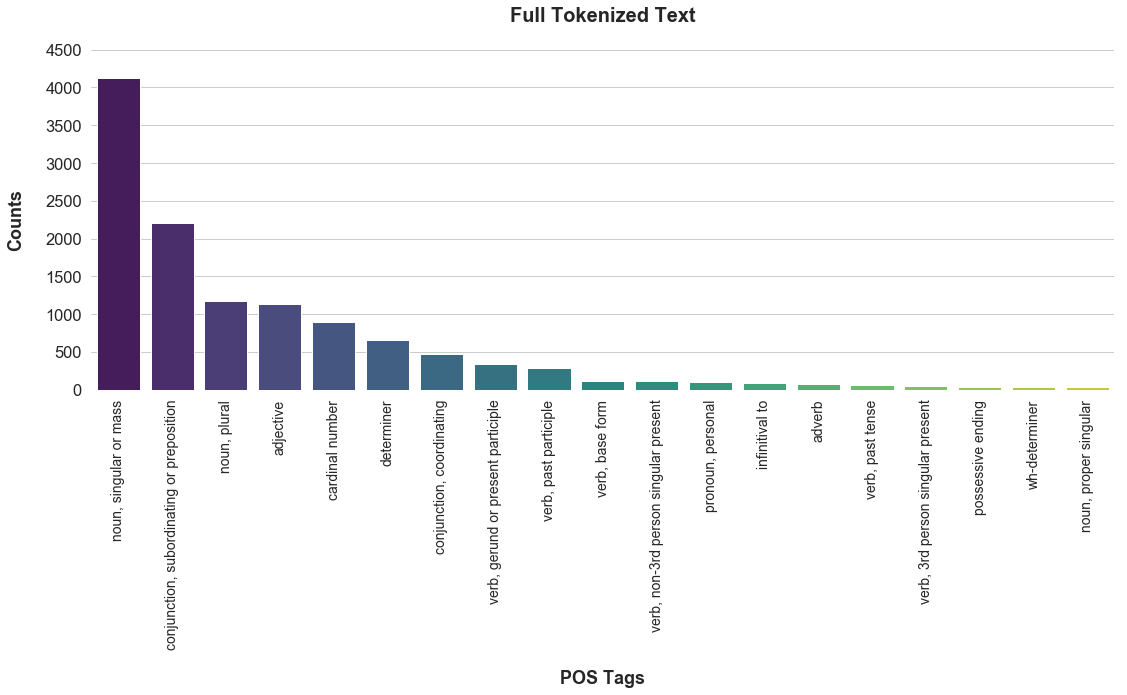

In [332]:
categ = list(tags_value_counts_df_gt20['Decoded'])

sns.set_style("whitegrid")
sns.set_context("notebook", font_scale=1.5)

f, ax = plt.subplots(figsize=(16, 10))

sns.barplot(y=tags_value_counts_df_gt20['Counts'], x=categ, palette=("viridis"))
ax.set(ylim=(0, 4500))
plt.xticks(rotation=90, fontsize=14)
sns.despine(left=True, bottom=True)
plt.xlabel('POS Tags', fontweight='bold', fontsize=18, labelpad=20)
plt.ylabel('Counts', fontweight='bold', fontsize=18, labelpad=20)
plot_title = "Full Tokenized Text\n"
plt.title(plot_title, fontweight='bold', size=20)
plt.tight_layout()
plt.savefig('./img/histogram_full_pos_tags_full_text.png')
plt.savefig('./img/histogram_full_pos_tags_full_text.pdf')

And with normalized values (0 to 1),

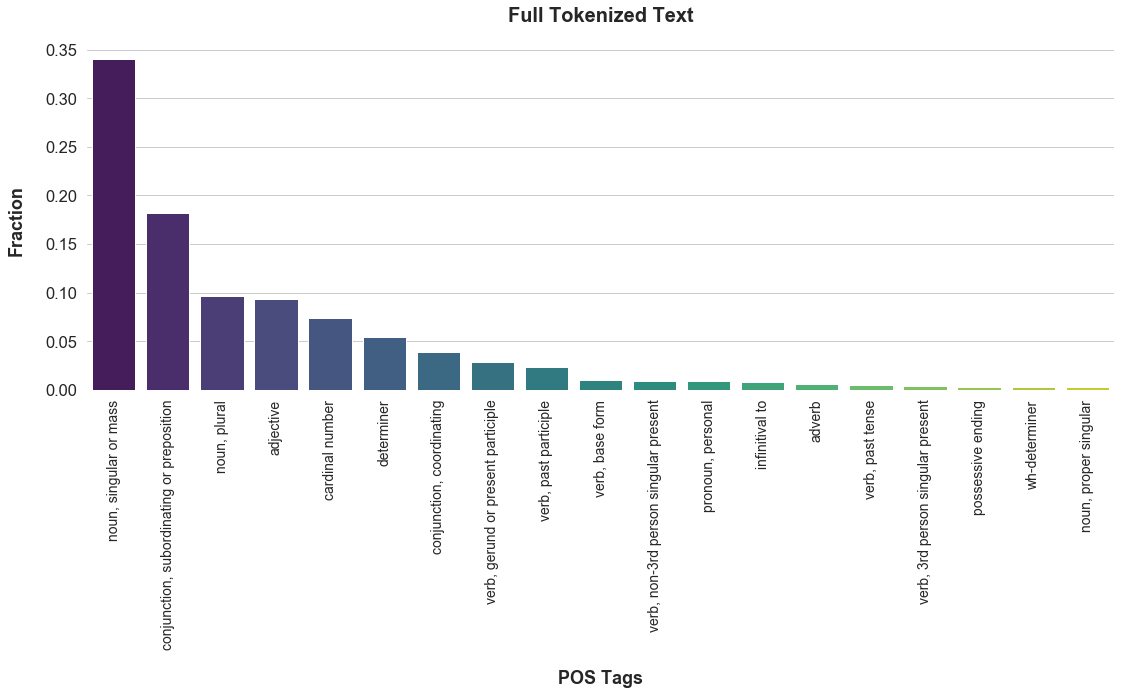

In [334]:
categ = list(tags_value_counts_df_gt20['Decoded'])

sns.set_style("whitegrid")
sns.set_context("notebook", font_scale=1.5)

f, ax = plt.subplots(figsize=(16, 10))

sns.barplot(y=tags_value_counts_df_gt20['Normalized_Count'], x=categ, palette=("viridis"))
ax.set(ylim=(0, 0.35))
plt.xticks(rotation=90, fontsize=14)
sns.despine(left=True, bottom=True)
plt.xlabel('POS Tags', fontweight='bold', fontsize=18, labelpad=20)
plt.ylabel('Fraction', fontweight='bold', fontsize=18, labelpad=20)
plot_title = "Full Tokenized Text\n"
plt.title(plot_title, fontweight='bold', size=20)
plt.tight_layout()
plt.savefig('./img/histogram_full_pos_tags_full_text_percentage.pdf')
plt.savefig('./img/histogram_full_pos_tags_full_text_percentage.png')


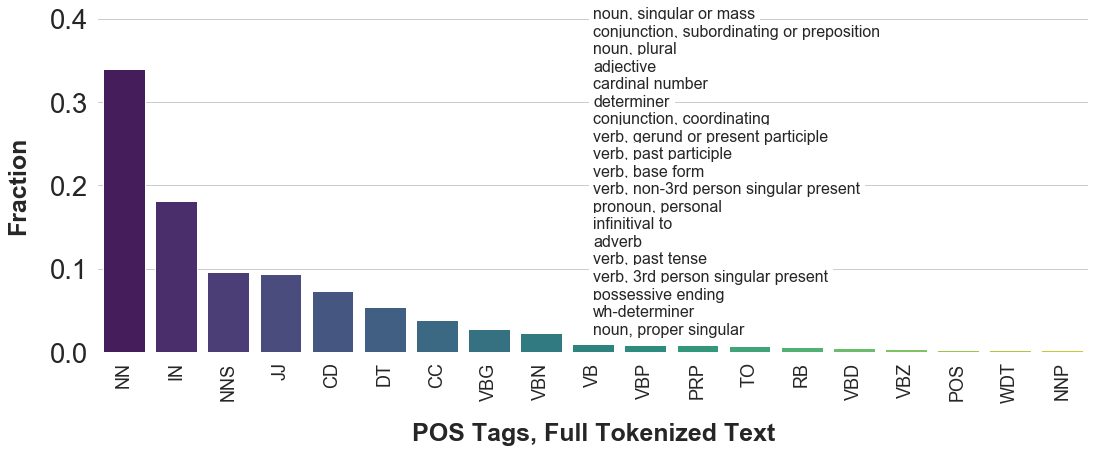

In [495]:
# Same plot but for the meetup presentation
#categ = list(tags_value_counts_df_gt20['Decoded'])
categ = list(tags_value_counts_df_gt20['Unique_Values'])

legend = tags_value_counts_df_gt20['Decoded']

sns.set_style("whitegrid")
sns.set_context("notebook", font_scale=2.5)

f, ax = plt.subplots(figsize=(16, 7))

sns.barplot(y=tags_value_counts_df_gt20['Normalized_Count'], x=categ, palette=("viridis"))
ax.set(ylim=(0, 0.4))
plt.xticks(rotation=90, fontsize=18)
sns.despine(left=True, bottom=True)
plt.xlabel('POS Tags, Full Tokenized Text', fontweight='bold', fontsize=25, labelpad=20)
plt.ylabel('Fraction', fontweight='bold', fontsize=25, labelpad=20)
#plot_title = "Full Tokenized Text\n"
#plt.title(plot_title, fontweight='bold', size=20)
ypos = 0.4
for item in legend:
    plt.text(9, ypos, item, fontsize=16, bbox=dict(facecolor='white',))
    #print(ypos)
    ypos -= 0.021
#plt.text(5, 0.3, [item for item in legend], fontsize=10, fontweight='bold')
plt.tight_layout()
plt.savefig('./img/histogram_full_pos_tags_full_text_percentage_mu_legends.pdf')
plt.savefig('./img/histogram_full_pos_tags_full_text_percentage_mu_legends.png')

In [341]:
tags_value_counts_df_gt20.to_csv('data/csv/post_tags.csv', encoding='utf-8', index=False)

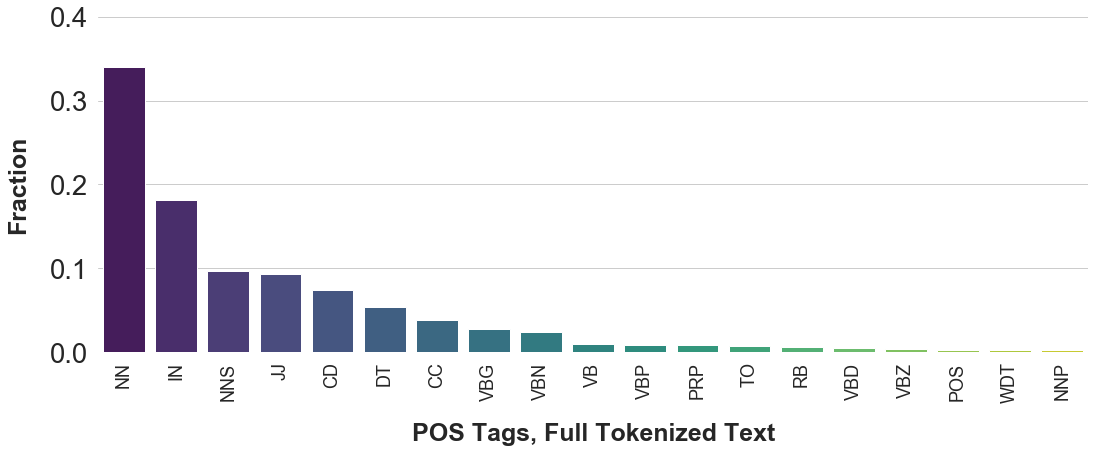

In [343]:
# Same plot but for the meetup presentation
#categ = list(tags_value_counts_df_gt20['Decoded'])
categ = list(tags_value_counts_df_gt20['Unique_Values'])

legend = tags_value_counts_df_gt20['Decoded']


sns.set_style("whitegrid")
sns.set_context("notebook", font_scale=2.5)

f, ax = plt.subplots(figsize=(16, 7))

sns.barplot(y=tags_value_counts_df_gt20['Normalized_Count'], x=categ, palette=("viridis"))
ax.set(ylim=(0, 0.4))
plt.xticks(rotation=90, fontsize=18)
sns.despine(left=True, bottom=True)
plt.xlabel('POS Tags, Full Tokenized Text', fontweight='bold', fontsize=25, labelpad=20)
plt.ylabel('Fraction', fontweight='bold', fontsize=25, labelpad=20)
#plot_title = "Full Tokenized Text\n"
#plt.title(plot_title, fontweight='bold', size=20)
plt.tight_layout()
plt.savefig('./img/histogram_full_pos_tags_full_text_percentage_mu.pdf')
plt.savefig('./img/histogram_full_pos_tags_full_text_percentage_mu.png')

In [344]:
sns.set_context("notebook", font_scale=1.5)

It is interesting to see how much text is composed of nouns (singular, plural,...), verbs (present, past,...), numbers, conjunctions, pronouns, adverbs, and adjectives.

In [345]:
pos_types = ['noun', 'pronoun', 'verb', 'adjective', 'adverb', 'conjunction', 'cardinal']

tag_tag = []
tag_count = []
tag_percent = []

for tag in pos_types:
    # Adding the columns that fit the constraint
    tag_array = tags_value_counts_df[(tags_value_counts_df['Decoded'].str.startswith(tag, na=False))].sum(axis=0)
    tag_tag.append(tag)
    # tag_array: [0]=Unique_Values, [1]=Counts, [2]=Normalized_Count, [3]=Decoded
    tag_count.append(tag_array[1])
    tag_percent.append(tag_array[2])

d = {'Tags':tag_tag, 'Counts':tag_count, 'Normalized_Count':tag_percent}

tags_df = pd.DataFrame(d)
tags_df = tags_df.sort_values(by='Counts', ascending=False)
tags_df

Counts  Normalized_Count         Tags
0    5332          0.439463         noun
5    2670          0.220061  conjunction
3    1143          0.094206    adjective
2     997          0.082173         verb
6     895          0.073766     cardinal
1     116          0.009561      pronoun
4      91          0.007500       adverb

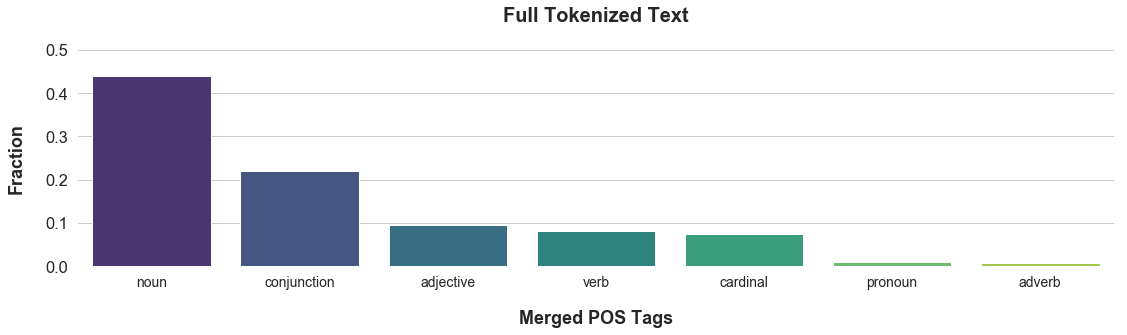

In [346]:
categ = list(tags_df['Tags'])

sns.set_style("whitegrid")
sns.set_context("notebook", font_scale=1.5)

f, ax = plt.subplots(figsize=(16, 5))

sns.barplot(y=tags_df['Normalized_Count'], x=categ, palette=("viridis"))
ax.set(ylim=(0, 0.5))
plt.xticks(rotation=0, fontsize=14)
sns.despine(left=True, bottom=True)
plt.xlabel('Merged POS Tags', fontweight='bold', fontsize=18, labelpad=20)
plt.ylabel('Fraction', fontweight='bold', fontsize=18, labelpad=20)
plot_title = "Full Tokenized Text\n"
plt.title(plot_title, fontweight='bold', size=20)
plt.tight_layout()
plt.savefig('./img/histogram_merged_pos_tags_full_text_percentage.png')


In summary, our corpus includes 43% nouns, 22% conjunctions, 10% adjectives, 8% verbs, 6% numbers, 1% pronouns, among others (9%).

## LSA and LDA Analysis using Bokeh, scikit-learn, and t-SNE

Following Susan Li's posts. We present here LSA and LDA analysis of the text.

In [359]:
from sklearn.manifold import TSNE

# LSA
from sklearn.decomposition import TruncatedSVD

# LDA
from sklearn.decomposition import LatentDirichletAllocation

# Vectorizers
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

In [360]:
from bokeh.plotting import figure, output_file, show
from bokeh.io import output_notebook
from bokeh.io import export_png
from bokeh.models import Label
from bokeh.models import Range1d

output_notebook()

Loading BokehJS ...

In [361]:
import matplotlib.patheffects as path_effects

In [362]:
# Susan Li's predefined functions

def get_keys(topic_matrix):
    '''
    returns an integer list of predicted topic 
    categories for a given topic matrix
    '''
    keys = topic_matrix.argmax(axis=1).tolist()
    return keys

def keys_to_counts(keys):
    '''
    returns a tuple of topic categories and their 
    accompanying magnitudes for a given list of keys
    '''
    count_pairs = Counter(keys).items()
    categories = [pair[0] for pair in count_pairs]
    counts = [pair[1] for pair in count_pairs]
    return (categories, counts)
    
def get_top_n_words(n, n_topics, keys, document_term_matrix, tfidf_vectorizer):
    '''
    returns a list of n_topic strings, where each string contains the n most common 
    words in a predicted category, in order
    '''
    top_word_indices = []
    for topic in range(n_topics):
        temp_vector_sum = 0
        for i in range(len(keys)):
            if keys[i] == topic:
                temp_vector_sum += document_term_matrix[i]
        temp_vector_sum = temp_vector_sum.toarray()
        top_n_word_indices = np.flip(np.argsort(temp_vector_sum)[0][-n:],0)
        top_word_indices.append(top_n_word_indices)   
    top_words = []
    for topic in top_word_indices:
        topic_words = []
        for index in topic:
            temp_word_vector = np.zeros((1,document_term_matrix.shape[1]))
            temp_word_vector[:, index] = 1
            the_word = tfidf_vectorizer.inverse_transform(temp_word_vector)[0][0]
            topic_words.append(the_word.encode('ascii').decode('utf-8'))
        top_words.append(", ".join(topic_words))         
    return top_words

def get_mean_topic_vectors(n_topics, keys, two_dim_vectors):
    '''
    returns a list of centroid vectors from each predicted topic category
    '''
    mean_topic_vectors = []
    for t in range(n_topics):
        reviews_in_that_topic = []
        for i in range(len(keys)):
            if keys[i] == t:
                reviews_in_that_topic.append(two_dim_vectors[i])    
        
        reviews_in_that_topic = np.vstack(reviews_in_that_topic)
        mean_review_in_that_topic = np.mean(reviews_in_that_topic, axis=0)
        mean_topic_vectors.append(mean_review_in_that_topic)
    return mean_topic_vectors

def get_median_topic_vectors(n_topics, keys, two_dim_vectors):
    '''
    returns a list of median-centroid vectors from each predicted topic category
    '''
    median_topic_vectors = []
    for t in range(n_topics):
        reviews_in_that_topic = []
        for i in range(len(keys)):
            if keys[i] == t:
                reviews_in_that_topic.append(two_dim_vectors[i])    
        
        reviews_in_that_topic = np.vstack(reviews_in_that_topic)
        median_review_in_that_topic = np.median(reviews_in_that_topic, axis=0)
        median_topic_vectors.append(median_review_in_that_topic)
    return median_topic_vectors

In [496]:
def compose_filename(plot_title):
    filename = plot_title.replace(" ", "")
    filename = filename.replace(",", "_")
    filename = filename.replace("\n", "")
    filename = './img/' + filename + '.png'
    return filename

In [501]:
def display_model_outputs(df, df_col, n_topics, num_top_n_words,
                          la_model, model_seed, 
                          vectorizer_name, 
                          barplot_title, 
                          title_tsne_plot, tsne_plot_range_x_x, tsne_plot_range_x_y,
                          tsne_plot_range_y_x, tsne_plot_range_y_y):
    '''
    Creates a LSA or LDA model by using either TruncatedSVD()
    or LatentDirichletAllocation() for n topics
    
    Takes only two vectorizers, TfidfVectorizer() as tfidf_vectorizer or 
    CountVectorizer() as count_vectorizer
    
    df_col must be the column in which there is the tokenized text.
    
    num_top_n_words: number of words to display
    '''
    colormap = np.array([
    "#1f77b4", "#aec7e8", "#ff7f0e", "#ffbb78", "#2ca02c",
    "#98df8a", "#d62728", "#ff9896", "#9467bd", "#c5b0d5",
    "#8c564b", "#c49c94", "#e377c2", "#f7b6d2", "#7f7f7f",
    "#c7c7c7", "#bcbd22", "#dbdb8d", "#17becf", "#9edae5" ])
    colormap = colormap[:n_topics]
    
    reindexed_data = df[df_col]
    reindexed_data = reindexed_data.values
    
    if vectorizer_name == 'tfidf_vectorizer':
        vectorizer = TfidfVectorizer(use_idf=True, smooth_idf=True)
    elif vectorizer_name == 'count_vectorizer':
        vectorizer = CountVectorizer(ngram_range=(1, 5))
    else:
        print("No such vectorizer")
        return None
    
    document_term_matrix = vectorizer.fit_transform(reindexed_data)
    
    if la_model == 'LSA':
        model = TruncatedSVD(n_components=n_topics, random_state=model_seed)
    elif la_model == "LDA":
        model = LatentDirichletAllocation(n_components=n_topics,
                                          random_state=model_seed, verbose=0)
    else: 
        print("No such model")
        return None
    
    topic_matrix = model.fit_transform(document_term_matrix)

    keys = get_keys(topic_matrix)
    categories, counts = keys_to_counts(keys)
    top_n_words = get_top_n_words(num_top_n_words, n_topics, keys, document_term_matrix, vectorizer)

    for i in range(len(top_n_words)):
        print("Topic {}: ".format(i + 1), top_n_words[i])

    # Plotting
    labels = ['Topic {}: \n'.format(i + 1) + top_n_words[i] for i in categories]
    fig, ax = plt.subplots(figsize=(16, 8))
    sns.despine(left=True, bottom=True)
    sns.set_context("notebook", font_scale=1.5)
    sns.barplot(y=counts, x=categories, palette=("viridis"))
    #ax.set_xticks(categories);
    ax.set_xticklabels(labels);
    plt.ylabel('Number of Requests', fontweight='bold', fontsize=18, labelpad=20)
    ax.set_title(barplot_title, fontweight='bold', size=20, pad=20);
    ax.grid(False, which='major', axis='x')
    plt.xticks(rotation=40, fontsize=14)
    plt.show();
    fig.tight_layout()
    filename = compose_filename(barplot_title)
    fig.savefig(filename)


    #Bokeh and t-SNE
    tsne_model = TSNE(n_components=2, perplexity=50, learning_rate=100, 
                            n_iter=2000, verbose=1, random_state=42, angle=0.75)
    tsne_vectors = tsne_model.fit_transform(topic_matrix)

    mean_topic_vectors = get_mean_topic_vectors(n_topics, keys, tsne_vectors)

    plot = figure(title=title_tsne_plot.format(n_topics), 
                  plot_width=700, plot_height=700, 
                  x_range=[tsne_plot_range_x_x, tsne_plot_range_x_y],
                  y_range=[tsne_plot_range_y_x, tsne_plot_range_y_y],
                  )

    plot.scatter(x=tsne_vectors[:,0], y=tsne_vectors[:,1], color=colormap[keys])
    plot.title.text_font_size = '18pt'
    plot.xaxis.major_label_text_font_size = "12pt"
    plot.yaxis.major_label_text_font_size = "12pt"
    filename_bokeh = './img/' + title_tsne_plot.format(n_topics).replace(" ", "") + '.png'

    for t in range(n_topics):
        label = Label(x=mean_topic_vectors[t][0], y=mean_topic_vectors[t][1], 
                      text=top_n_words[t], text_color=colormap[t], text_font_size='14pt')
        plot.add_layout(label)

    show(plot)
    export_png(plot, filename=filename_bokeh)
    
    return None
    

In [498]:
def display_model_outputs_mu(df, df_col, n_topics, num_top_n_words,
                             la_model, model_seed, 
                             vectorizer_name, 
                             barplot_title, 
                             title_tsne_plot, tsne_plot_range_x_x, tsne_plot_range_x_y,
                             tsne_plot_range_y_x, tsne_plot_range_y_y):
    '''
    Creates a LSA or LDA model by using either TruncatedSVD()
    or LatentDirichletAllocation() for n topics
    
    Takes only two vectorizers, TfidfVectorizer() as tfidf_vectorizer or 
    CountVectorizer() as count_vectorizer
    
    df_col must be the column in which there is the tokenized text.
    
    num_top_n_words: number of words to display
    '''
    colormap = np.array([
    "#1f77b4", "#aec7e8", "#ff7f0e", "#ffbb78", "#2ca02c",
    "#98df8a", "#d62728", "#ff9896", "#9467bd", "#c5b0d5",
    "#8c564b", "#c49c94", "#e377c2", "#f7b6d2", "#7f7f7f",
    "#c7c7c7", "#bcbd22", "#dbdb8d", "#17becf", "#9edae5" ])
    colormap = colormap[:n_topics]
    
    reindexed_data = df[df_col]
    reindexed_data = reindexed_data.values
    
    if vectorizer_name == 'tfidf_vectorizer':
        vectorizer = TfidfVectorizer(use_idf=True, smooth_idf=True)
    elif vectorizer_name == 'count_vectorizer':
        vectorizer = CountVectorizer(ngram_range=(1, 5))
    else:
        print("No such vectorizer")
        return None
    
    document_term_matrix = vectorizer.fit_transform(reindexed_data)
    
    if la_model == 'LSA':
        model = TruncatedSVD(n_components=n_topics, random_state=model_seed)
    elif la_model == "LDA":
        model = LatentDirichletAllocation(n_components=n_topics,
                                          random_state=model_seed, verbose=0)
    else: 
        print("No such model")
        return None
    
    topic_matrix = model.fit_transform(document_term_matrix)

    keys = get_keys(topic_matrix)
    categories, counts = keys_to_counts(keys)
    top_n_words = get_top_n_words(num_top_n_words, n_topics, keys, document_term_matrix, vectorizer)

    for i in range(len(top_n_words)):
        print("Topic {}: ".format(i + 1), top_n_words[i])

    # Plotting
    labels = ['Topic {}: \n'.format(i + 1) + top_n_words[i] for i in categories]
    fig, ax = plt.subplots(figsize=(16, 12))
    sns.despine(left=True, bottom=True)
    sns.set_context("notebook", font_scale=2.5)
    sns.barplot(y=counts, x=categories, palette=("viridis"))
    #ax.set_xticks(categories);
    ax.set_xticklabels(labels);
    plt.ylabel('Number of Requests', fontweight='bold', fontsize=24, labelpad=20)
    ax.set_title(barplot_title, fontweight='bold', size=26, pad=20);
    ax.grid(False, which='major', axis='x')
    plt.xticks(rotation=90, fontsize=22)
    plt.show();
    fig.tight_layout()
    filename = compose_filename(barplot_title)
    fig.savefig(filename)


    #Bokeh and t-SNE
    tsne_model = TSNE(n_components=2, perplexity=50, learning_rate=100, 
                            n_iter=2000, verbose=1, random_state=42, angle=0.75)
    tsne_vectors = tsne_model.fit_transform(topic_matrix)

    mean_topic_vectors = get_mean_topic_vectors(n_topics, keys, tsne_vectors)

    plot = figure(title=title_tsne_plot.format(n_topics), 
                  plot_width=700, plot_height=700, 
                  x_range=[tsne_plot_range_x_x, tsne_plot_range_x_y],
                  y_range=[tsne_plot_range_y_x, tsne_plot_range_y_y],
                  )

    plot.scatter(x=tsne_vectors[:,0], y=tsne_vectors[:,1], color=colormap[keys])
    plot.title.text_font_size = '18pt'
    plot.xaxis.major_label_text_font_size = "12pt"
    plot.yaxis.major_label_text_font_size = "12pt"
    filename_bokeh = './img/' + title_tsne_plot.format(n_topics).replace(" ", "") + '.png'

    for t in range(n_topics):
        label = Label(x=mean_topic_vectors[t][0], y=mean_topic_vectors[t][1], 
                      text=top_n_words[t], text_color=colormap[t], text_font_size='14pt')
        plot.add_layout(label)

    show(plot)
    export_png(plot, filename=filename_bokeh)
    
    return None
    

## LSA - scikit-learn - tf-idf vectorizer

Of the 10 topics found, five of the previously seven discussed common phrases are included, except for *"Public Health Inspection"*.


Topic 1:  complete, copy, works, ontario
Topic 2:  site, environmental, assessment, phase
Topic 3:  competition, information, personal, file
Topic 4:  maintenance, income, note, supervisor
Topic 5:  record, regard, waterloo, relate
Topic 6:  resources, human, personal, file
Topic 7:  home, child, care, provider
Topic 8:  control, rabies, investigation, bite
Topic 9:  health, kitchener, public, inspection
Topic 10:  cambridge, records, river, relate


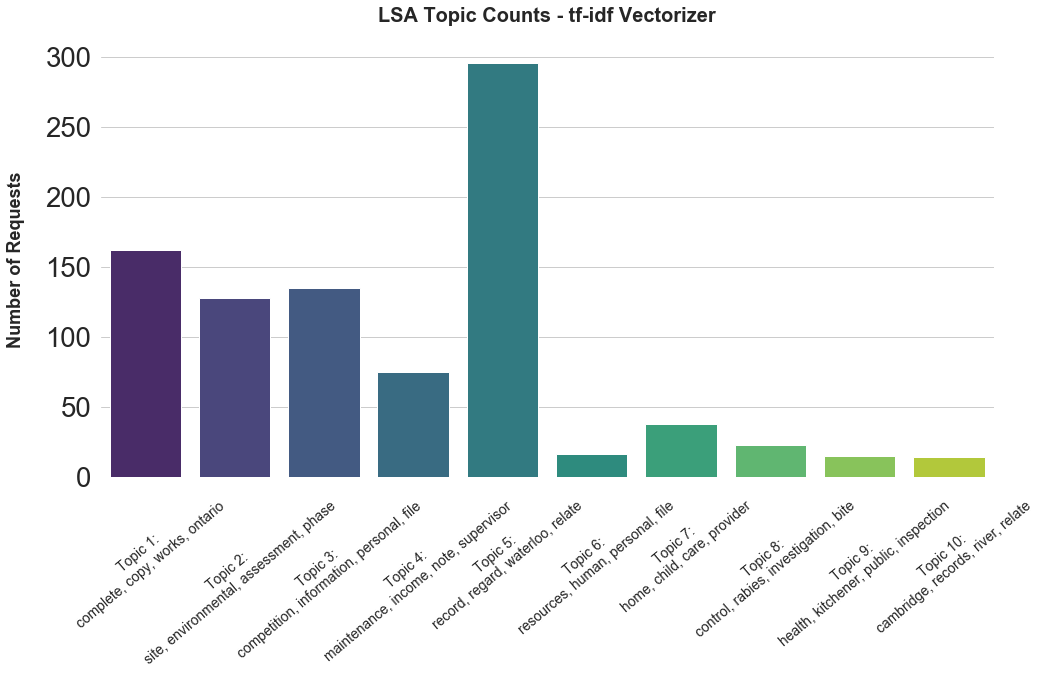

[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 902 samples in 0.001s...
[t-SNE] Computed neighbors for 902 samples in 0.035s...
[t-SNE] Computed conditional probabilities for sample 902 / 902
[t-SNE] Mean sigma: 0.059673
[t-SNE] KL divergence after 250 iterations with early exaggeration: 55.990883
[t-SNE] KL divergence after 2000 iterations: 0.345818


In [502]:
display_model_outputs(tokenized_adf, 'Edited_Summary', 10, 4,
                      'LSA', 42, 
                      'tfidf_vectorizer', 
                      'LSA Topic Counts - tf-idf Vectorizer', 
                      "t-SNE Clustering of {} LSA Topics - tf-idf Vectorizer",
                       -30, 50,
                       -40, 30)

Topic 1:  complete, copy, works, ontario
Topic 2:  site, environmental, assessment, phase
Topic 3:  competition, information, personal, file
Topic 4:  maintenance, income, note, supervisor
Topic 5:  record, regard, waterloo, relate
Topic 6:  resources, human, personal, file
Topic 7:  home, child, care, provider
Topic 8:  control, rabies, investigation, bite
Topic 9:  health, kitchener, public, inspection
Topic 10:  cambridge, records, river, relate


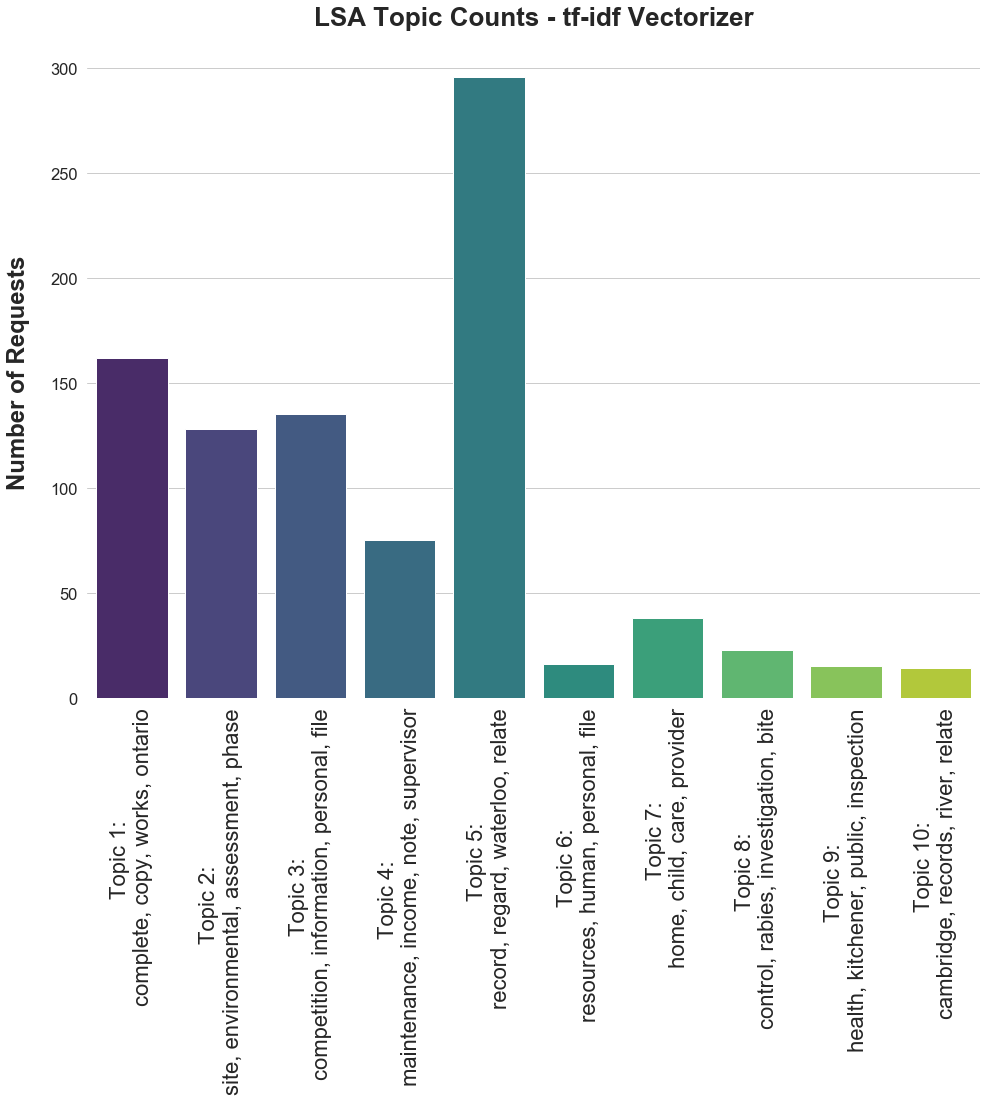

[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 902 samples in 0.000s...
[t-SNE] Computed neighbors for 902 samples in 0.032s...
[t-SNE] Computed conditional probabilities for sample 902 / 902
[t-SNE] Mean sigma: 0.059673
[t-SNE] KL divergence after 250 iterations with early exaggeration: 55.990883
[t-SNE] KL divergence after 2000 iterations: 0.345818


In [500]:
display_model_outputs_mu(tokenized_adf, 'Edited_Summary', 10, 4,
                      'LSA', 42, 
                      'tfidf_vectorizer', 
                      'LSA Topic Counts - tf-idf Vectorizer', 
                      "t-SNE Clustering of {} LSA Topics - tf-idf Vectorizer",
                       -30, 50,
                       -40, 30)

While there seems to be defined clusters for *home child care*, *ontario works*, and *environmental site*, many other topics overlap.

In [368]:
sns.set_context("notebook", font_scale=1.5)

## LDA - scikit-learn - tf-idf vectorizer

Of the 10 topics found, LDA found four of the previously seven discussed common phrases.

Topic 1:  sewer, company, information, regard
Topic 2:  regional, regard, record, waterloo
Topic 3:  inspection, investigation, health, record
Topic 4:  record, transit, grand, river
Topic 5:  complete, copy, works, ontario
Topic 6:  maintenance, income, record, file
Topic 7:  general, competition, file, information
Topic 8:  phase, assessment, site, environmental
Topic 9:  personal, competition, information, file
Topic 10:  note, service, interview, blueprinting


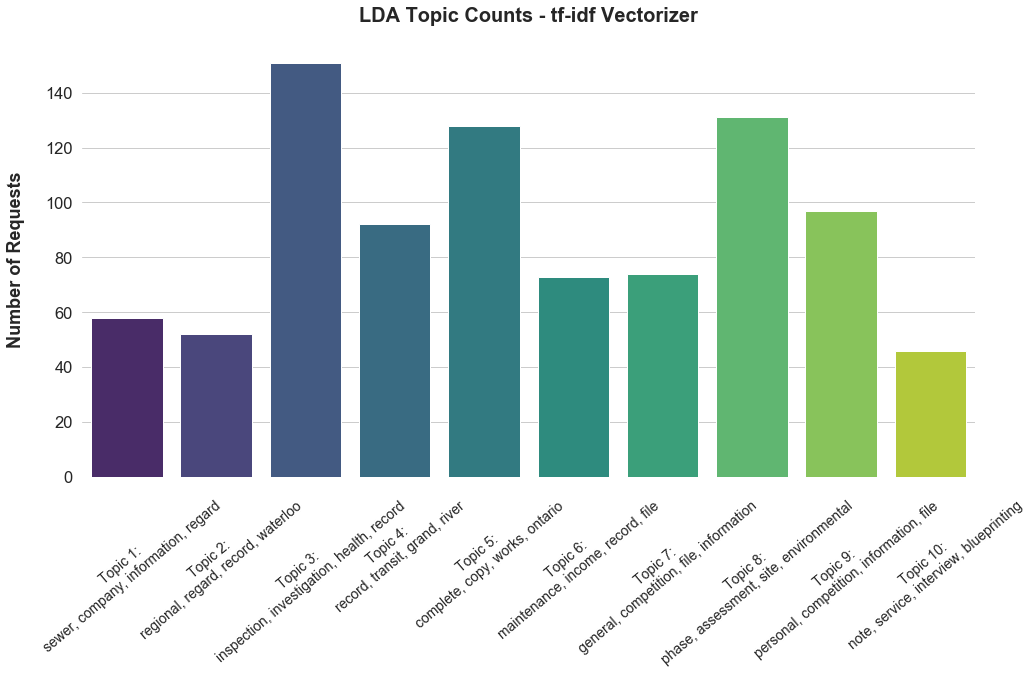

[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 902 samples in 0.000s...
[t-SNE] Computed neighbors for 902 samples in 0.037s...
[t-SNE] Computed conditional probabilities for sample 902 / 902
[t-SNE] Mean sigma: 0.001048
[t-SNE] KL divergence after 250 iterations with early exaggeration: 45.105892
[t-SNE] KL divergence after 1850 iterations: 0.200238


In [370]:
display_model_outputs(tokenized_adf, 'Edited_Summary', 10, 4,
                      'LDA', 42, 
                      'tfidf_vectorizer', 
                      'LDA Topic Counts - tf-idf Vectorizer', 
                      "t-SNE Clustering of {} LDA Topics - tf-idf Vectorizer",
                       -30, 50,
                       -40, 50)

t-SNE for LDA with tf-idf provides more defined clusters compared to LSA. 

## LSA - scikit-learn - CountVectorizer

It seems like LSA + CountVectorizer does not give better results. It could not process more than 7 topics. It did find two of the topics, but t-SNE gives overlapping clusters and the top topics include bigrams, too. And while the word *Waterloo* is present in many requests, as expected, it is probably not a good idea for those to be topics themselves.

Topic 1:  year, maintenance, records, past
Topic 2:  file, copy, complete, ontario
Topic 3:  environmental, site, assessment, phase
Topic 4:  waterloo, region, region waterloo, record
Topic 5:  report, centre, city centre, waterloo city centre
Topic 6:  regard, information, record, competition
Topic 7:  january, signal, time, support


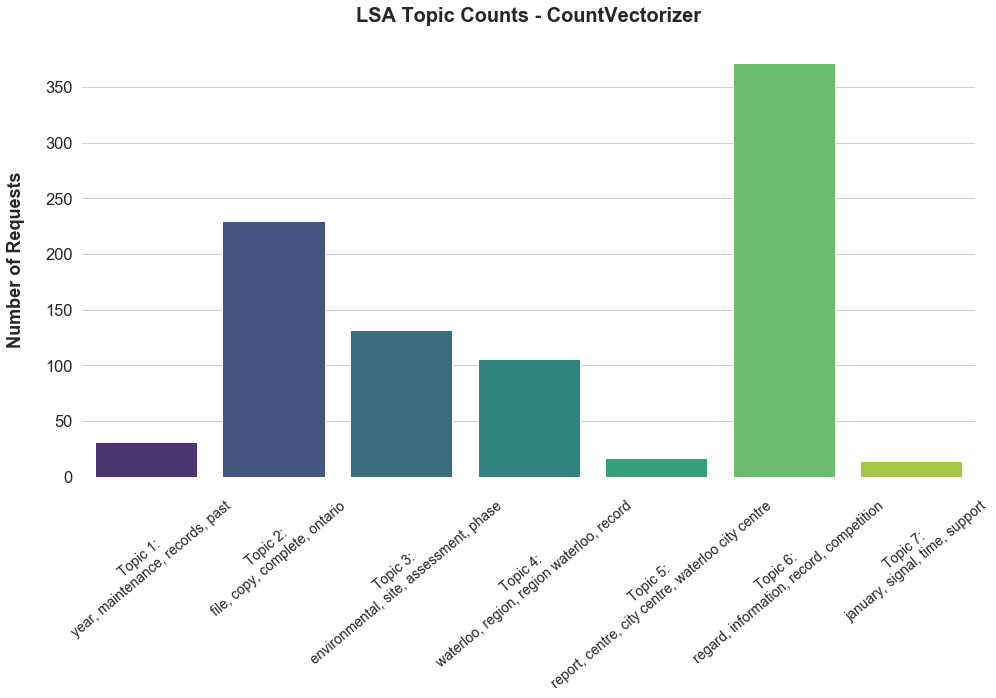

[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 902 samples in 0.001s...
[t-SNE] Computed neighbors for 902 samples in 0.027s...
[t-SNE] Computed conditional probabilities for sample 902 / 902
[t-SNE] Mean sigma: 0.116363
[t-SNE] KL divergence after 250 iterations with early exaggeration: 51.862091
[t-SNE] KL divergence after 2000 iterations: 0.326777


In [382]:
display_model_outputs(tokenized_adf, 'Edited_Summary', 7, 4,
                      'LSA', 42, 
                      'count_vectorizer', 
                      'LSA Topic Counts - CountVectorizer', 
                      "t-SNE Clustering of {} LSA Topics - CountVectorizer",
                       -30, 60,
                       -50, 30)

## LDA - scikit-learn - CountVectorizer

While t-DNE gives more defined clusters for LSA + CountVectorizer, it is obvious by looking at the topics that this is not a good model for our data.

Topic 1:  record, relate, file, waterloo
Topic 2:  regard, home, file, care
Topic 3:  assessment, environmental, phase, site
Topic 4:  file, client, waterloo, client file
Topic 5:  file, ontario, regard, relate
Topic 6:  competition, file, information, information competition
Topic 7:  incident, record, regard, file
Topic 8:  file, ontario, ontario works, works
Topic 9:  record, regard, record regard, control
Topic 10:  file, records, human, personal


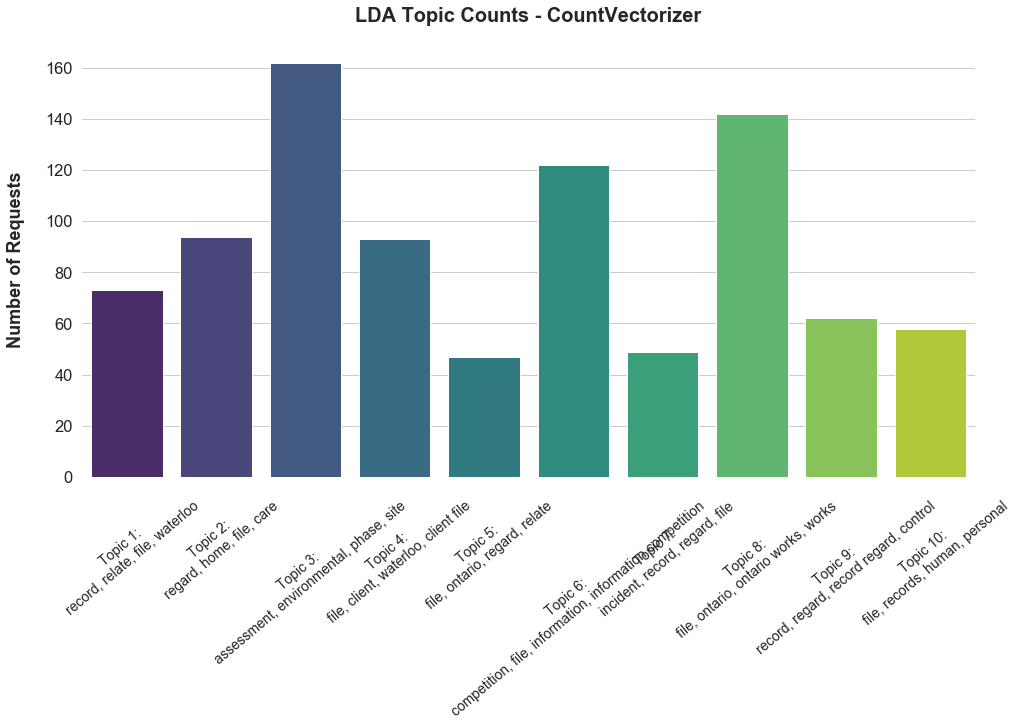

[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 902 samples in 0.000s...
[t-SNE] Computed neighbors for 902 samples in 0.037s...
[t-SNE] Computed conditional probabilities for sample 902 / 902
[t-SNE] Mean sigma: 0.000000
[t-SNE] KL divergence after 250 iterations with early exaggeration: 40.283985
[t-SNE] KL divergence after 2000 iterations: 0.076107


In [374]:
display_model_outputs(tokenized_adf, 'Edited_Summary', 10, 4,
                      'LDA', 42, 
                      'count_vectorizer', 
                      'LDA Topic Counts - CountVectorizer', 
                      "t-SNE Clustering of {} LDA Topics - CountVectorizer",
                       -40, 60,
                       -40, 40)

## LDA Analysis using Gensim and pyLDAvis

### Gensim
Another tool for LDA analysis is gensim, an open-source library for unsupervised topic modeling and natural language processing. Gensim is specifically designed to handle large text collections using data streaming and incremental online algorithms, which differentiates it from most other machine learning software packages that target only in-memory processing.

In [383]:
import gensim
from gensim import corpora

import pyLDAvis.gensim    # To visualize our output


In [384]:
import warnings 
warnings.filterwarnings('ignore')

In [385]:
# 'Edited_Summary' has the tokens already, no need to preprocess or prepare the text

text_data = []
for index in range(0, len(tokenized_adf)):
    current_line = tokenized_adf['Edited_Summary'][index]
    line_tokens = prepare_text_tlc(current_line)
    text_data.append(line_tokens)

In [386]:
#Convert document into the bag-of-words format 
dictionary = corpora.Dictionary(text_data)
corpus = [dictionary.doc2bow(text) for text in text_data]

# To be able to save model to hard drive
import pickle
pickle.dump(corpus, open('data/corpus/corpus.pkl', 'wb'))
dictionary.save('data/gensim/dictionary.gensim')

Let's try extracting a different number of topics, from 3 to 15, and print the top 5 words of each.

In [387]:
NUM_TOPICS = 3
ldamodel = gensim.models.ldamodel.LdaModel(corpus, num_topics=NUM_TOPICS, id2word=dictionary, passes=15)
ldamodel.save('data/gensim/model3.gensim')
topics = ldamodel.print_topics(num_words=5)
for topic in topics:
    print(topic)

(0, '0.089*"file" + 0.043*"copy" + 0.038*"ontario" + 0.037*"work" + 0.036*"complete"')
(1, '0.039*"record" + 0.030*"regard" + 0.020*"relate" + 0.015*"incident" + 0.014*"include"')
(2, '0.046*"environmental" + 0.044*"site" + 0.044*"assessment" + 0.039*"phase" + 0.033*"waterloo"')


In [388]:
NUM_TOPICS = 5
ldamodel = gensim.models.ldamodel.LdaModel(corpus, num_topics=NUM_TOPICS, id2word=dictionary, passes=15)
ldamodel.save('data/gensim/model5.gensim')
topics = ldamodel.print_topics(num_words=5)
for topic in topics:
    print(topic)

(0, '0.035*"report" + 0.029*"regard" + 0.028*"record" + 0.021*"inspection" + 0.020*"waterloo"')
(1, '0.124*"file" + 0.051*"copy" + 0.047*"complete" + 0.047*"ontario" + 0.045*"client"')
(2, '0.077*"environmental" + 0.075*"assessment" + 0.074*"site" + 0.066*"phase" + 0.025*"waterloo"')
(3, '0.036*"waterloo" + 0.028*"region" + 0.024*"regard" + 0.016*"record" + 0.014*"relate"')
(4, '0.026*"record" + 0.014*"intersection" + 0.014*"relate" + 0.013*"regard" + 0.012*"signal"')


In [389]:
NUM_TOPICS = 10
ldamodel = gensim.models.ldamodel.LdaModel(corpus, num_topics=NUM_TOPICS, id2word=dictionary, passes=15)
ldamodel.save('data/gensim/model10.gensim')
topics = ldamodel.print_topics(num_words=5)
for topic in topics:
    print(topic)

(0, '0.095*"file" + 0.068*"environmental" + 0.067*"ontario" + 0.067*"complete" + 0.066*"copy"')
(1, '0.038*"regard" + 0.023*"record" + 0.022*"video" + 0.021*"transit" + 0.020*"river"')
(2, '0.097*"information" + 0.092*"file" + 0.078*"competition" + 0.069*"personal" + 0.020*"resource"')
(3, '0.029*"file" + 0.028*"service" + 0.027*"competition" + 0.027*"regard" + 0.022*"waterloo"')
(4, '0.050*"health" + 0.039*"regard" + 0.038*"public" + 0.037*"inspection" + 0.029*"record"')
(5, '0.019*"present" + 0.018*"proposal" + 0.017*"request" + 0.015*"assistance" + 0.014*"waterloo"')
(6, '0.045*"home" + 0.043*"child" + 0.043*"care" + 0.032*"provider" + 0.027*"file"')
(7, '0.033*"information" + 0.023*"service" + 0.019*"requester" + 0.017*"regard" + 0.015*"region"')
(8, '0.052*"record" + 0.029*"relate" + 0.028*"regard" + 0.026*"investigation" + 0.026*"rabies"')
(9, '0.045*"maintenance" + 0.043*"record" + 0.042*"income" + 0.023*"relate" + 0.023*"file"')


In [390]:
NUM_TOPICS = 15
ldamodel = gensim.models.ldamodel.LdaModel(corpus, num_topics=NUM_TOPICS, id2word=dictionary, passes=15)
ldamodel.save('data/gensim/model15.gensim')
topics = ldamodel.print_topics(num_words=5)
for topic in topics:
    print(topic)

(0, '0.029*"time" + 0.026*"signal" + 0.022*"record" + 0.021*"2004" + 0.019*"skill"')
(1, '0.075*"health" + 0.057*"public" + 0.048*"inspection" + 0.043*"record" + 0.041*"regard"')
(2, '0.030*"waterloo" + 0.018*"region" + 0.017*"incident" + 0.015*"regard" + 0.014*"plan"')
(3, '0.094*"home" + 0.078*"child" + 0.074*"care" + 0.058*"provider" + 0.058*"file"')
(4, '0.083*"maintenance" + 0.082*"income" + 0.068*"file" + 0.025*"regard" + 0.025*"client"')
(5, '0.024*"assistance" + 0.024*"1992" + 0.021*"january" + 0.019*"application" + 0.019*"1995"')
(6, '0.041*"service" + 0.034*"company" + 0.032*"note" + 0.025*"regional" + 0.025*"sewer"')
(7, '0.033*"waterloo" + 0.033*"regard" + 0.020*"record" + 0.019*"centre" + 0.018*"price"')
(8, '0.027*"waterloo" + 0.027*"region" + 0.019*"record" + 0.017*"service" + 0.016*"property"')
(9, '0.050*"video" + 0.049*"transit" + 0.046*"grand" + 0.046*"river" + 0.044*"record"')
(10, '0.129*"environmental" + 0.120*"site" + 0.118*"assessment" + 0.110*"phase" + 0.049*"c

### pyLDAvis

pyLDAvis is a python library for interactive topic model visualization. It is designed to help users interpret the topics in a topic model that has been fit to a corpus of text data. The package extracts information from a fitted LDA topic model to inform an interactive web-based visualization.



In [391]:
pyLDAvis.enable_notebook()

In [392]:
# We can load the dictionary and corpus from the files we already stored in the hard drive. 
dictionary = gensim.corpora.Dictionary.load('data/gensim/dictionary.gensim')
corpus = pickle.load(open('data/corpus/corpus.pkl', 'rb'))


Let's now visualize our data for all the models, which range from 3 to 15 topics. It seems that perhaps 3-5 topics give the clearer distinction between topics in the distance map. Realistically, we know the number topics should be more. Increasing the number of topics just brings up the issue that for our models, given the number of words and data we have, there is no clear separation of topics.

In [393]:
lda = gensim.models.ldamodel.LdaModel.load('data/gensim/model15.gensim')
lda_display = pyLDAvis.gensim.prepare(lda, corpus, dictionary, sort_topics=False)
pyLDAvis.display(lda_display)
#pyLDAvis.show(lda_display)

In [394]:
lda = gensim.models.ldamodel.LdaModel.load('data/gensim/model10.gensim')
lda_display = pyLDAvis.gensim.prepare(lda, corpus, dictionary, sort_topics=False)
pyLDAvis.display(lda_display)

In [395]:
lda = gensim.models.ldamodel.LdaModel.load('data/gensim/model5.gensim')
lda_display = pyLDAvis.gensim.prepare(lda, corpus, dictionary, sort_topics=False)
pyLDAvis.display(lda_display)

In [396]:
lda = gensim.models.ldamodel.LdaModel.load('data/gensim/model3.gensim')
lda_display = pyLDAvis.gensim.prepare(lda, corpus, dictionary, sort_topics=False)
pyLDAvis.display(lda_display)

## LSI Analysis using Gensim

In [397]:
NUM_TOPICS = 10
lsimodel = gensim.models.lsimodel.LsiModel(corpus, num_topics=NUM_TOPICS, id2word=dictionary)
lsimodel.save('data/gensim/model10_lsi.gensim')
topics = lsimodel.print_topics(num_words=5)
for topic in topics:
    print(topic)

(0, '0.500*"file" + 0.305*"copy" + 0.302*"ontario" + 0.269*"complete" + 0.268*"work"')
(1, '0.346*"file" + -0.321*"record" + -0.291*"year" + -0.215*"intersection" + 0.210*"copy"')
(2, '-0.412*"site" + -0.410*"assessment" + -0.383*"environmental" + -0.349*"waterloo" + -0.345*"phase"')
(3, '-0.275*"waterloo" + 0.256*"phase" + 0.251*"environmental" + -0.247*"region" + 0.244*"site"')
(4, '0.422*"information" + 0.350*"competition" + 0.278*"file" + 0.232*"regard" + 0.228*"personal"')
(5, '-0.333*"regard" + 0.280*"file" + 0.275*"guardrail" + 0.262*"terminal" + 0.261*"competition"')
(6, '0.432*"waterloo" + 0.326*"city" + 0.296*"centre" + -0.277*"record" + -0.209*"environmental"')
(7, '-0.449*"record" + 0.325*"information" + 0.324*"transit" + 0.286*"river" + 0.284*"grand"')
(8, '-0.449*"regard" + 0.248*"relate" + 0.238*"record" + -0.225*"report" + -0.218*"maintenance"')
(9, '-0.387*"january" + -0.238*"support" + 0.216*"region" + -0.207*"signal" + -0.204*"report"')


# Machine Learning

Having taken a deep look at our text, we now proceed to try to predict the *Decision* based on the *Summary_of_Request* text. We move forward even though our colleague Scott Jones already worked with this data and found ML does not work very well given the size of our set. He, instead, proceeded to add the freedom of information requests from Toronto and surrounding areas. 

But, hey, we are learning, so let's give ML a shot (again) given what we already know about the limitations of the data and the preprocessing we did. We also add other models to the analysis.

In [398]:
from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

from sklearn import preprocessing

from sklearn import svm
from sklearn.svm import LinearSVC
from sklearn.svm import SVC

from sklearn import tree
from sklearn.tree import DecisionTreeClassifier

from sklearn.base import TransformerMixin
from sklearn.datasets import make_blobs
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline

import mlxtend
from mlxtend.plotting import category_scatter
from mlxtend.plotting import plot_decision_regions

import scikitplot as skplt

from xgboost import XGBClassifier

In [399]:
from spacy import displacy

import en_core_web_sm

nlp = en_core_web_sm.load()

In [400]:
class clean_text_Transformer(TransformerMixin):
    def transform(self, X, **transform_params):
        return [clean_text(text) for text in X]
    def fit(self, X, y=None, **fit_params):
        return self
    
def get_params(self, deep=True):
        return {}

In [401]:
def display_confusion_matrix(y_test, preds,
                             df, df_col_w_labels,
                             plot_title):
    
    count_conf_mat = confusion_matrix(y_test, preds)
    labels = df[df_col_w_labels].unique()
    
    fig, ax = plt.subplots(figsize=(11, 10))
    sns.set_context("notebook", font_scale=1.5)
    sns.heatmap(count_conf_mat, annot=True, fmt='d',
                xticklabels=labels, yticklabels=labels)
    plt.ylabel('Actual', fontweight='bold', fontsize=18, labelpad=20)
    plt.xlabel('Predicted', fontweight='bold', fontsize=18, labelpad=20)
    ax.set_title(label=plot_title, fontweight='bold', size=20, pad=20)
    plt.tight_layout()
    filename = compose_filename(plot_title)
    fig.savefig(filename)
    
    return None
    

In [402]:
def display_confusion_matrix_w_report(y_test, preds,
                             df, df_col_w_labels,
                             plot_title):
    
    count_conf_mat = confusion_matrix(y_test, preds)
    labels = df[df_col_w_labels].unique()
    
    fig, ax = plt.subplots(figsize=(10, 9))
    sns.set_context("notebook", font_scale=1.5)
    sns.heatmap(count_conf_mat, annot=True, fmt='d',
                xticklabels=labels, yticklabels=labels)
    plt.ylabel('Actual', fontweight='bold', fontsize=18, labelpad=20)
    plt.xlabel('Predicted', fontweight='bold', fontsize=18, labelpad=20)
    ax.set_title(label=plot_title, fontweight='bold', size=20, pad=20)
    plt.tight_layout()
    filename = compose_filename(plot_title)
    fig.savefig(filename) 
    
    print(classification_report(y_test, preds,
                                target_names=df[df_col_w_labels].unique()))
    
    return None
    

As a reminder, we have 12 types of decisions in an unbalanced set.

In [404]:
print(tokenized_adf['Decision'].value_counts())

All information disclosed          296
Information disclosed in part      282
Request withdrawn                  124
No records exist                    90
Partly non-existent                 36
No information disclosed            33
Transferred                         20
Abandoned                           13
Correction refused                   3
Correction granted                   3
No additional records exist          1
Statement of disagreement filed      1
Name: Decision, dtype: int64


We will be using two vectorizers for our analysis, CountVectorizer and tf-idf.

In [405]:
count_vect = CountVectorizer(tokenizer=prepare_text_tlc, ngram_range=(1, 5))
tfidf_vect = TfidfVectorizer(tokenizer=prepare_text_tlc, ngram_range=(1, 5))

Let's choose the MultinomialNB model as a start,

In [406]:
count_clf = MultinomialNB()
tfidf_clf = MultinomialNB()

and define a pipeline for our text, to clean it up, select and apply both the vectorizer and classifier.

In [407]:
count_pipe = Pipeline([
                      ('clean_text', clean_text_Transformer()),
                      ('vectorizer', count_vect),
                      ('clf', count_clf)
                      ])

tfidf_pipe = Pipeline([
                      ('clean_text', clean_text_Transformer()),
                      ('vectorizer', tfidf_vect),
                      ('clf', tfidf_clf)
                      ])

We will work with our dataframe whose column *'Edited_Summary'* has the cleaned and tokenized text, where symbols and stop words have been removed already.

In [408]:
y_fs = tokenized_adf['Decision']
X_fs = tokenized_adf['Edited_Summary']
X_fs_train, X_fs_test, y_fs_train, y_fs_test=train_test_split(X_fs, y_fs, test_size=0.33, random_state=42)

We will train in 67% of the set, which is about 600 requests.

### CountVectorizer with MultinomialNB - full set of decisions

In [409]:
count_pipe.fit(X_fs_train, y_fs_train)
count_preds_fs = count_pipe.predict(X_fs_test)
print("Accuracy: {0}".format(accuracy_score(y_fs_test, count_preds_fs)))

Accuracy: 0.4563758389261745


CountVectorizer with MultinomialNB gives about 46% accuracy, bummer! Let's look at the confusion matrix.

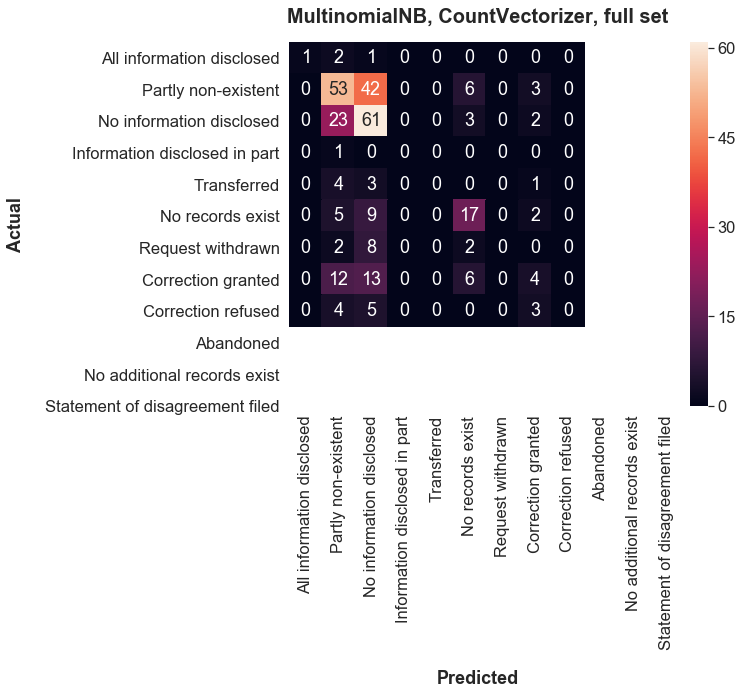

In [410]:
display_confusion_matrix(y_fs_test, count_preds_fs,
                         tokenized_adf, 'Decision',
                         'MultinomialNB, CountVectorizer, full set')

### tf-idf with LinearSVC - full set of decisions

In [411]:
tfidf_pipe.fit(X_fs_train, y_fs_train)
tfidf_preds_fs = tfidf_pipe.predict(X_fs_test)
print("Accuracy: {0}".format(accuracy_score(y_fs_test, tfidf_preds_fs)))

Accuracy: 0.412751677852349


tf-idf with MultinomialNB gives about 42% accuracy, not better. Let's look at the confusion matrix.

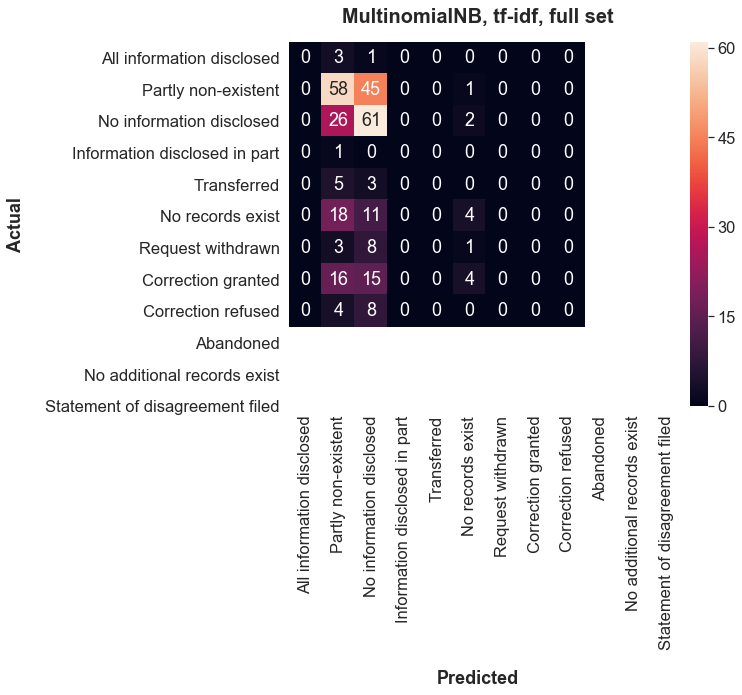

In [412]:
display_confusion_matrix(y_fs_test, tfidf_preds_fs,
                         tokenized_adf, 'Decision',
                         'MultinomialNB, tf-idf, full set')

By observing the matrix, we can see that it could not predict decisions that had few instances, like *'Correction granted'*, which has only once request. It was in the training set but not in the prediction set, or vice versa, but not both.

Therefore, let's test three different approaches to this:

a) Keep our set of decisions, except for the ones with less than 15 instances (just to keep *'Transferred'*.)

b) Binning all decisions into 3 basic categories, all, partial, or no information disclosed.

a) Remove cases with less than 15 cases and where a decision was not made, this, when the request was either *'Withdrawn'* or *'Abandoned'*. 


## a) Using Decisions with more than 15 instances

In [413]:
print(tokenized_adf['Decision'].value_counts())

All information disclosed          296
Information disclosed in part      282
Request withdrawn                  124
No records exist                    90
Partly non-existent                 36
No information disclosed            33
Transferred                         20
Abandoned                           13
Correction refused                   3
Correction granted                   3
No additional records exist          1
Statement of disagreement filed      1
Name: Decision, dtype: int64


In [414]:
tokenized_adf_over15 = tokenized_adf.groupby('Decision').filter(lambda x: len(x) >= 15)
print(tokenized_adf_over15['Decision'].value_counts())

All information disclosed        296
Information disclosed in part    282
Request withdrawn                124
No records exist                  90
Partly non-existent               36
No information disclosed          33
Transferred                       20
Name: Decision, dtype: int64


### Model comparison

Now we will introduce a way to compare 8 classifiers at once, both numerically and visually. We start with CounterVectorizer, for both regular and *balanced* class weights, and then we will change our vectorizer to tf-idf.


In [419]:
accuracy_dfs = pd.DataFrame()

In [420]:
def compare_ML_models(df, df_feature_col, df_labels_col, 
                      vectorizer_name, 
                      num_k_folds,
                      model_seed,
                      balanced_bool,
                      plot_title, 
                      accuracy_df_title):
    '''
    Functions that compares eight ML classifiers models:
    RandomForest, LinearSVC, MultinomialNB, LogisticRegression,
    SVC, KNeighbors, SGDC, and DecisionTree for
    five numebr of folds (cv)
    
    Takes:
    dataframe
    dataframe column with data
    dataframe column with labels
    vectorizer
    random seed,
    if one considers class_weight='balanced'
    plot title
    output dataframe title
    
    Output:
    Dataframe with accuracy means per model
      
    '''
  
    if vectorizer_name == 'tfidf_vectorizer':
        vectorizer = TfidfVectorizer(sublinear_tf=True, min_df=3, norm='l2',
                                     ngram_range=(1, 4), tokenizer=prepare_text_tlc)
    elif vectorizer_name == 'count_vectorizer':
        vectorizer = CountVectorizer(min_df=3, ngram_range=(1, 4), tokenizer=prepare_text_tlc)
    else:
        print("No such vectorizer")
        return None

    assert df_feature_col in  df, "Column '{0}' not in dataframe".format(df_feature_col)
    assert df_labels_col in  df, "Column '{0}' not in dataframe".format(df_labels_col)
    
    features = vectorizer.fit_transform(df[df_feature_col])
    labels = df[df_labels_col]
    
    if balanced_bool:
        cw_value = 'balanced'
    else:
        cw_value = None

    models = [
        RandomForestClassifier(n_estimators=200, max_depth=3,
                               random_state=model_seed, class_weight=cw_value),
        LinearSVC(random_state=model_seed, class_weight=cw_value),
        MultinomialNB(),
        LogisticRegression(random_state=model_seed, class_weight=cw_value),
        SVC(gamma="scale", random_state=model_seed, class_weight=cw_value),
        KNeighborsClassifier(),
        SGDClassifier(loss='hinge', penalty='l2', max_iter=5, tol=None,
                      random_state=model_seed, class_weight=cw_value),
        DecisionTreeClassifier(random_state=model_seed, class_weight=cw_value)
        ]
        
    CV = num_k_folds
    cv_df = pd.DataFrame(index=range(CV * len(models)))
    entries = []
    for model in models:
        model_name = model.__class__.__name__
        accuracies = cross_val_score(model, features, labels,
                                     scoring='accuracy', cv=CV)
        for fold_idx, accuracy in enumerate(accuracies):
            entries.append((model_name, fold_idx, accuracy))
    cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])


    fig, ax = plt.subplots(figsize=(15,6))
    sns.set_context("notebook", font_scale=1.5)
    ax = sns.boxplot(x='model_name', y='accuracy', data=cv_df, color="#5480d2")  # color='#5480d2'
    sns.stripplot(x='model_name', y='accuracy', data=cv_df,
                 size=8, jitter=True, edgecolor="midnightblue", linewidth=2, color="#5480d2")
    plt.ylabel('Accuracy', fontweight='bold', fontsize=18, labelpad=20)
    plt.xlabel('Model', fontweight='bold', fontsize=18, labelpad=20)
    ax.set_title(label=plot_title, fontweight='bold', size=20, pad=20)
    for i, artist in enumerate(ax.artists):
        # Set the linecolor on the artist to the facecolor, and set the facecolor to None
        col = "midnightblue"    #artist.get_facecolor()
        artist.set_edgecolor(col) 
        #artist.set_facecolor('None')
        # Each box has 6 associated Line2D objects (to make the whiskers, fliers, etc.)
        # Loop over them here, and use the same colour as above
        for j in range(i*6,i*6+6):
            line = ax.lines[j]
            line.set_color(col)
            line.set_mfc(col)
            line.set_mec(col)
    plt.xticks(rotation=30, fontsize=14)
    plt.tight_layout()
    filename = compose_filename(plot_title)
    fig.savefig(filename)

    accuracy_df = cv_df.groupby('model_name').accuracy.mean()
    accuracy_df = accuracy_df.to_frame()
    accuracy_df.rename(index=str, columns={"accuracy": accuracy_df_title}, inplace=True)

    return accuracy_df

In [421]:
def add_df_to_accuracy_df(accuracy_df, df_to_add):
    column = df_to_add.columns[0]
    if column not in accuracy_df.columns:
        accuracy_df = pd.concat([accuracy_df, df_to_add], axis=1, sort=False)
    return accuracy_df
    

Over-15, CountVec
model_name                               
DecisionTreeClassifier           0.318291
KNeighborsClassifier             0.371541
LinearSVC                        0.381662
LogisticRegression               0.421445
MultinomialNB                    0.383792
RandomForestClassifier           0.405277
SGDClassifier                    0.335278
SVC                              0.412096

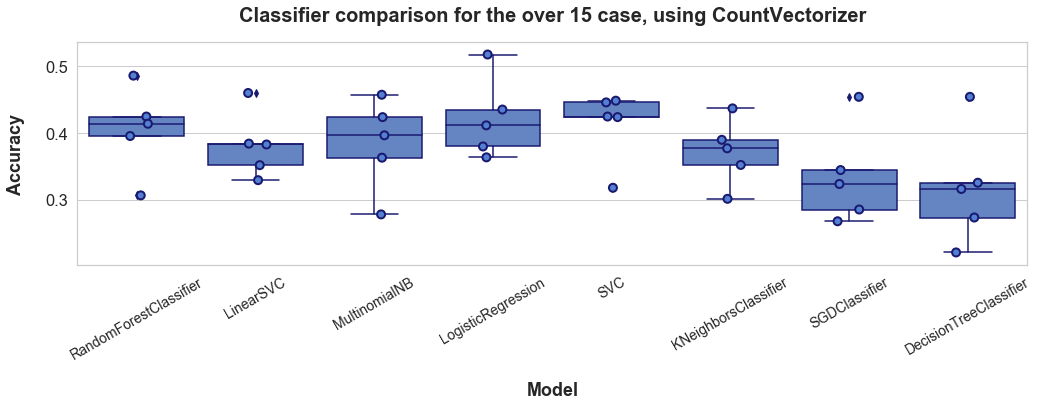

In [422]:
acc_df1 = compare_ML_models(tokenized_adf_over15, 'Edited_Summary', 'Decision', 
              'count_vectorizer', 
              5,
              42,
              False,
              'Classifier comparison for the over 15 case, using CountVectorizer', 
              'Over-15, CountVec')

accuracy_dfs = add_df_to_accuracy_df(accuracy_dfs, acc_df1)
acc_df1


Over-15, CountVec, bal.
model_name                                     
DecisionTreeClassifier                 0.284519
KNeighborsClassifier                   0.371541
LinearSVC                              0.361455
LogisticRegression                     0.393186
MultinomialNB                          0.383792
RandomForestClassifier                 0.287557
SGDClassifier                          0.332016
SVC                                    0.240081

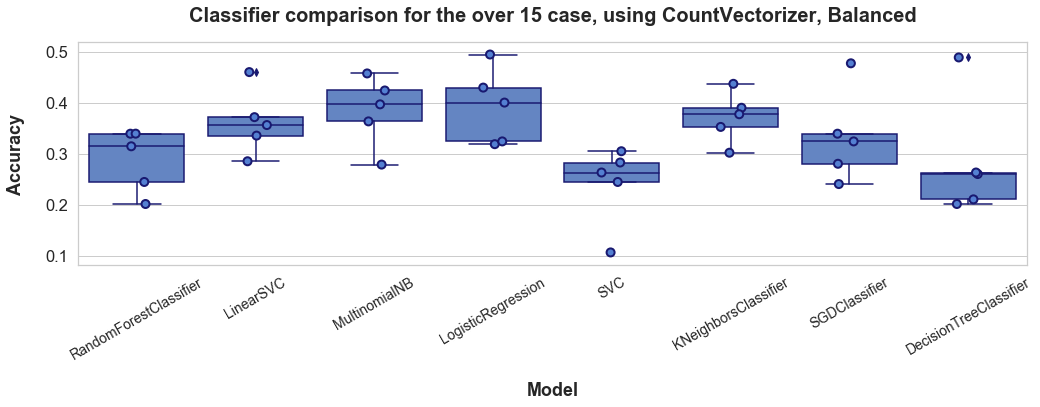

In [423]:
acc_df2 = compare_ML_models(tokenized_adf_over15, 'Edited_Summary', 'Decision', 
              'count_vectorizer', 
              5,
              42,
              True,
              'Classifier comparison for the over 15 case, using CountVectorizer, Balanced', 
              'Over-15, CountVec, bal.')
     
accuracy_dfs = add_df_to_accuracy_df(accuracy_dfs, acc_df2)
acc_df2

Over-15, tf-idf
model_name                             
DecisionTreeClassifier         0.332749
KNeighborsClassifier           0.378463
LinearSVC                      0.412230
LogisticRegression             0.439525
MultinomialNB                  0.451982
RandomForestClassifier         0.387260
SGDClassifier                  0.356864
SVC                            0.336029

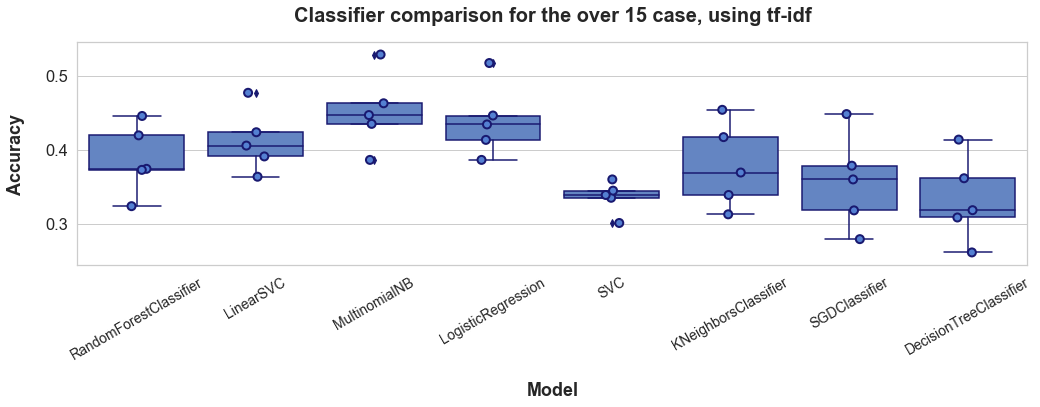

In [424]:
acc_df3 = compare_ML_models(tokenized_adf_over15, 'Edited_Summary', 'Decision', 
              'tfidf_vectorizer', 
              5,
              42,
              False,
              'Classifier comparison for the over 15 case, using tf-idf', 
              'Over-15, tf-idf')
accuracy_dfs = add_df_to_accuracy_df(accuracy_dfs, acc_df3)
acc_df3

Over-15, tf-idf, bal.
model_name                                   
DecisionTreeClassifier               0.282058
KNeighborsClassifier                 0.378463
LinearSVC                            0.378451
LogisticRegression                   0.400023
MultinomialNB                        0.451982
RandomForestClassifier               0.330589
SGDClassifier                        0.320643
SVC                                  0.235949

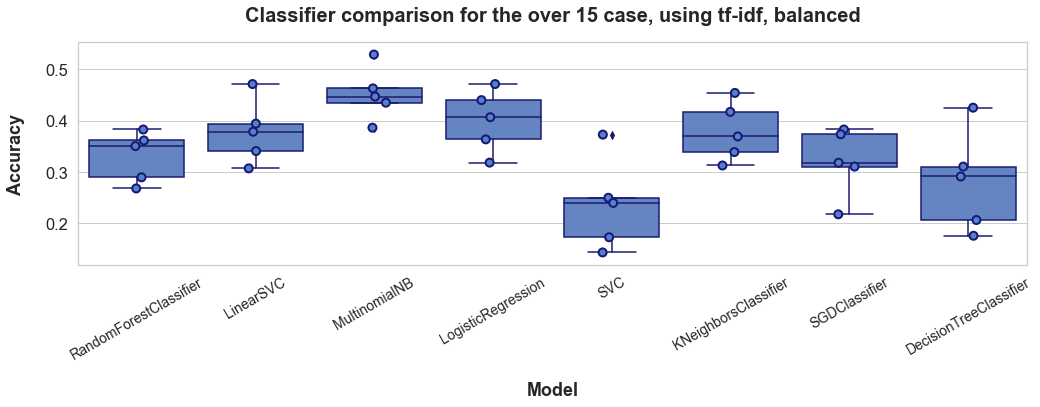

In [425]:
acc_df4 = compare_ML_models(tokenized_adf_over15, 'Edited_Summary', 'Decision', 
              'tfidf_vectorizer', 
              5,
              42,
              True,
              'Classifier comparison for the over 15 case, using tf-idf, balanced', 
              'Over-15, tf-idf, bal.')
accuracy_dfs = add_df_to_accuracy_df(accuracy_dfs, acc_df4)
acc_df4

### Grid Search

MultinomialNB with tf-idf seems to do better. Therefore, we are going to show an example of the approach using GridSearchCV to find the best parameters for a classifier, in this case, for MultinomialNB, and the vectorizer. We will find the scores and the confusion matrix.


Setting our training and test sets.

In [426]:
y_s_over15 = tokenized_adf_over15['Decision']
X_s_over15 = tokenized_adf_over15['Edited_Summary']
X_s_over15_train, X_s_over15_test, y_s_over15_train, y_s_over15_test=train_test_split(X_s_over15, 
                                                y_s_over15, test_size=0.33, random_state=42)

Finding parameters.

In [427]:
tfidf_vect = TfidfVectorizer()
parameters = {'vectorizer__ngram_range': [(1, 2), (1, 3), (1, 4)],
              'clf__alpha': (1, 1e-1, 1e-2, 1e-3)
             }
tfidf_clf = MultinomialNB()
tfidf_pipe = Pipeline([
                      ('vectorizer', tfidf_vect),
                      ('clf', tfidf_clf)
                      ])
gs_clf = GridSearchCV(tfidf_pipe, parameters, cv=5, iid=False, n_jobs=-1)
gs_clf_over15 = gs_clf.fit(X_s_over15_train, y_s_over15_train)
print("For MultinomialNB Classifier with tf-idf:\n")
print("Best score: ", gs_clf_over15.best_score_)
for param_name in sorted(parameters.keys()):
    print("{0}: {1}".format(param_name, gs_clf_over15.best_params_[param_name]))


For MultinomialNB Classifier with tf-idf:

Best score:  0.4811953753396243
clf__alpha: 0.1
vectorizer__ngram_range: (1, 2)


Running our model with the parameters just found.

MultinomialNB Accuracy, tfidf, over 15 case: 0.42955326460481097
                               precision    recall  f1-score   support

    All information disclosed       0.48      0.57      0.52       106
          Partly non-existent       0.37      0.62      0.46        79
     No information disclosed       0.00      0.00      0.00        11
Information disclosed in part       0.48      0.52      0.50        29
                  Transferred       0.00      0.00      0.00        14
             No records exist       0.50      0.02      0.04        43
            Request withdrawn       0.00      0.00      0.00         9

                    micro avg       0.43      0.43      0.43       291
                    macro avg       0.26      0.25      0.22       291
                 weighted avg       0.40      0.43      0.37       291



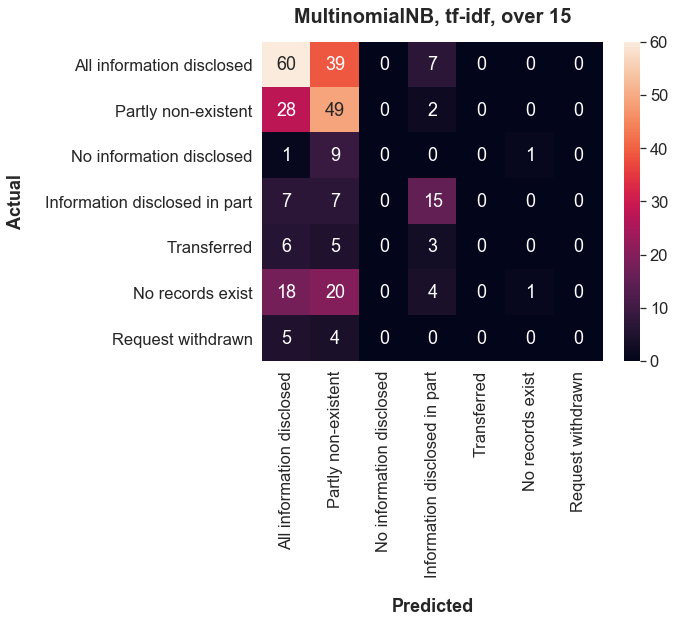

In [428]:
tfidf_vect = TfidfVectorizer(ngram_range=(1, 2))
tfidf_clf = MultinomialNB(alpha=0.1)

tfidf_pipe.fit(X_s_over15_train, y_s_over15_train)
tfidf_preds_over15 = tfidf_pipe.predict(X_s_over15_test)
print("MultinomialNB Accuracy, tfidf, over 15 case:", accuracy_score(y_s_over15_test, tfidf_preds_over15))

display_confusion_matrix_w_report(y_s_over15_test, tfidf_preds_over15,
                         tokenized_adf_over15, 'Decision',
                         'MultinomialNB, tf-idf, over 15')

## b) Binning into 3 basic categories: all, partial, or no information disclosed

So, let's reduce the categories to three: all, partial, and no information disclosed. We'll bin them according to:

- All information disclosed (plus 'Correction granted')

- Information disclosed in part (plus 'Partly non-existent')

- No information disclosed (plus 'Transferred', 'No records exist', 'Correction refused', 'No additional records exist', 'Statement of disagreement filed', 'Withdrawn', and 'Abandoned')

We will do this by adding a new column to our array, *'Sub_Decision'*.

In [429]:
tokenized_adf.head(4)

Request_Number Request_Type               Source  \
0           98001     Personal           Individual   
1           98002      General           Individual   
2           98003      General             Business   
3           98004      General  Individual by Agent   

                                  Summary_of_Request  \
0  GWA file, specifically agreements, cheques and...   
1  Records related to construction on {company na...   
2  Information regarding damage to Regional facil...   
3  Identity of the Sunnyside Home employee who wi...   

                    Decision  \
0  All information disclosed   
1        Partly non-existent   
2        Partly non-existent   
3   No information disclosed   

                                      Edited_Summary  
0  file specifically agreement cheque monetary in...  
1         records relate construction site 1996 1997  
2  information regard damage regional facility se...  
3  identity sunnyside home employee witness motor...

In [430]:
tokenized_adf['Sub_Decision'] = tokenized_adf['Decision']

In [431]:
tokenized_adf.head(4)

Request_Number Request_Type               Source  \
0           98001     Personal           Individual   
1           98002      General           Individual   
2           98003      General             Business   
3           98004      General  Individual by Agent   

                                  Summary_of_Request  \
0  GWA file, specifically agreements, cheques and...   
1  Records related to construction on {company na...   
2  Information regarding damage to Regional facil...   
3  Identity of the Sunnyside Home employee who wi...   

                    Decision  \
0  All information disclosed   
1        Partly non-existent   
2        Partly non-existent   
3   No information disclosed   

                                      Edited_Summary  \
0  file specifically agreement cheque monetary in...   
1         records relate construction site 1996 1997   
2  information regard damage regional facility se...   
3  identity sunnyside home employee witness motor...   

                Sub_Decision  
0  All information disclosed  
1        Partly non-existent  
2        Partly non-existent  
3   No information disclosed

Replacing our decisions for a generic version.

In [432]:
pos_dec = {'Correction granted'}
part_dec = {'Partly non-existent'}
neg_dec = {'Request withdrawn', 'Transferred', 'No records exist', 'Correction refused', 'Abandoned', 
           'No additional records exist', 'Statement of disagreement filed'}

In [433]:
for pos in pos_dec:
    tokenized_adf['Sub_Decision'] = tokenized_adf['Sub_Decision'].str.replace(
                                    pos,'All information disclosed')

In [434]:
for part in part_dec:
    tokenized_adf['Sub_Decision'] = tokenized_adf['Sub_Decision'].str.replace(
                                    part,'Information disclosed in part')

In [435]:
for neg in neg_dec:
    tokenized_adf['Sub_Decision'] = tokenized_adf['Sub_Decision'].str.replace(
                                    neg,'No information disclosed')

In [436]:
tokenized_adf.head(11)

Request_Number Request_Type               Source  \
0            98001     Personal           Individual   
1            98002      General           Individual   
2            98003      General             Business   
3            98004      General  Individual by Agent   
4            98005     Personal           Individual   
5            98006      General             Business   
6            98007      General             Business   
7            98008     Personal           Individual   
8            98009     Personal           Individual   
9            98010     Personal           Individual   
10           98011      General           Individual   

                                   Summary_of_Request  \
0   GWA file, specifically agreements, cheques and...   
1   Records related to construction on {company na...   
2   Information regarding damage to Regional facil...   
3   Identity of the Sunnyside Home employee who wi...   
4   Regional Solicitor's file for {name removed} r...   
5   Tender and contract for wastewater treatment o...   
6   Unit pricing (pages 24-28) of winning bid for ...   
7   GWA for {name removed} records from January 1,...   
8   Home Child Care Provider file for {name remove...   
9   Income Maintenance file for {name removed} nar...   
10  Various records regarding the voice radio system.   

                         Decision  \
0       All information disclosed   
1             Partly non-existent   
2             Partly non-existent   
3        No information disclosed   
4   Information disclosed in part   
5   Information disclosed in part   
6        No information disclosed   
7             Partly non-existent   
8   Information disclosed in part   
9       All information disclosed   
10                    Transferred   

                                       Edited_Summary  \
0   file specifically agreement cheque monetary in...   
1          records relate construction site 1996 1997   
2   information regard damage regional facility se...   
3   identity sunnyside home employee witness motor...   
4   regional solicitor file regard employment wate...   
5   tender contract wastewater treatment operation...   
6                            unit price page contract   
7   record january 1993 present particularly lette...   
8          home child care provider file 1983 present   
9   income maintenance file narrative note january...   
10                  various record regard voice radio   

                     Sub_Decision  
0       All information disclosed  
1   Information disclosed in part  
2   Information disclosed in part  
3        No information disclosed  
4   Information disclosed in part  
5   Information disclosed in part  
6        No information disclosed  
7   Information disclosed in part  
8   Information disclosed in part  
9       All information disclosed  
10       No information disclosed

In [437]:
tokenized_adf['Sub_Decision'].unique()

array(['All information disclosed', 'Information disclosed in part',
       'No information disclosed'], dtype=object)

In [438]:
tokenized_adf.Sub_Decision.value_counts()

Information disclosed in part    318
All information disclosed        299
No information disclosed         285
Name: Sub_Decision, dtype: int64

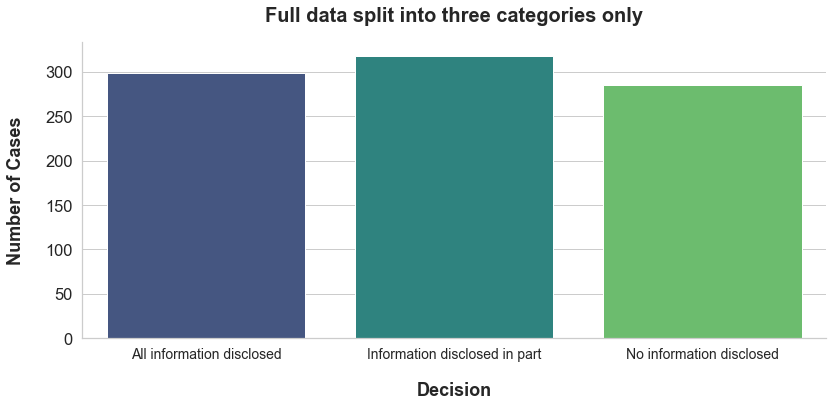

In [440]:
columns_sub = []
for i in range(0,tokenized_adf.Sub_Decision.nunique()):
    columns_sub.append(tokenized_adf.Sub_Decision.unique()[i])

tokenized_adf_groupby_Sub_Decision = tokenized_adf.groupby('Sub_Decision').count()[['Source']]

fig, ax = plt.subplots(figsize=(12, 6))
sns.set(style="whitegrid")
sns.set_context("notebook", font_scale=1.5)
sns.despine()
ax = sns.barplot(x=columns_sub, y='Source', data=tokenized_adf_groupby_Sub_Decision, palette='viridis')
plt.ylabel('Number of Cases', fontweight='bold', fontsize=18, labelpad=20)
plt.xlabel('Decision', fontweight='bold', fontsize=18, labelpad=20)
ax.set_title(label='Full data split into three categories only', fontweight='bold', size=20, pad=20)
plt.xticks(rotation=0, fontsize=14)
plt.tight_layout()
plt.savefig('./img/full_data_split_into_three_bins.png')
plt.savefig('./img/full_data_split_into_three_bins.pdf')

And now our set seems more balanced.

### Model comparison, 3-bin case

Let's compare eight different classifiers with two vectorizers, CountVectorizer and tf-idf.

3-bins, CountVec
model_name                              
DecisionTreeClassifier          0.420319
KNeighborsClassifier            0.408072
LinearSVC                       0.445819
LogisticRegression              0.456894
MultinomialNB                   0.465752
RandomForestClassifier          0.417911
SGDClassifier                   0.430245
SVC                             0.454449

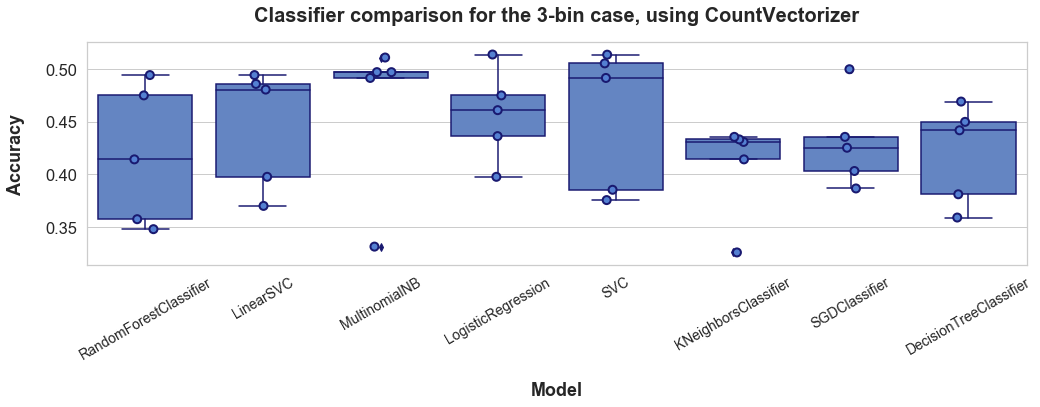

In [441]:
acc_df5 = compare_ML_models(tokenized_adf, 'Edited_Summary', 'Sub_Decision', 
              'count_vectorizer', 
              5,
              42,
              False,
              'Classifier comparison for the 3-bin case, using CountVectorizer', 
              '3-bins, CountVec')
accuracy_dfs = add_df_to_accuracy_df(accuracy_dfs, acc_df5)
acc_df5

3-bins, tf-idf
model_name                            
DecisionTreeClassifier        0.402578
KNeighborsClassifier          0.410263
LinearSVC                     0.445820
LogisticRegression            0.462394
MultinomialNB                 0.470147
RandomForestClassifier        0.421226
SGDClassifier                 0.426912
SVC                           0.411238

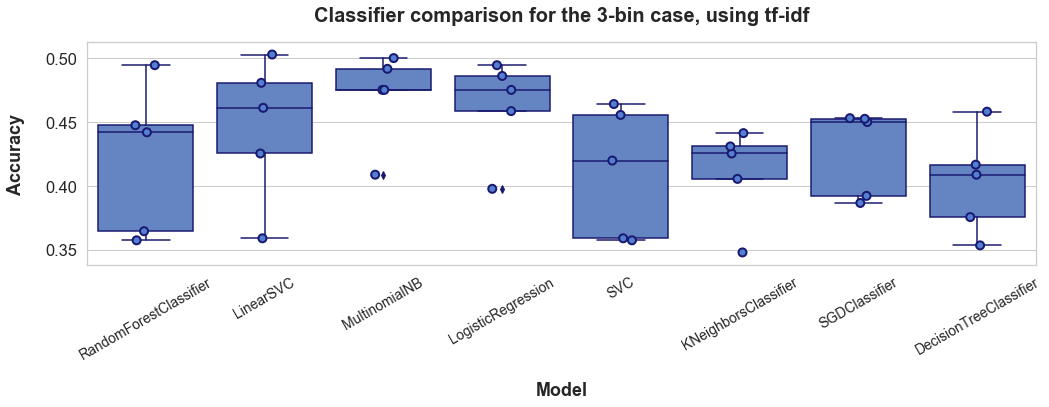

In [442]:
acc_df6 = compare_ML_models(tokenized_adf, 'Edited_Summary', 'Sub_Decision', 
              'tfidf_vectorizer', 
              5,
              42,
              False,
              'Classifier comparison for the 3-bin case, using tf-idf', 
              '3-bins, tf-idf')
accuracy_dfs = add_df_to_accuracy_df(accuracy_dfs, acc_df6)
acc_df6

It seems like LogisticRegression with tf-idf does slightly better this time. Let's find the best parameters and take a look at the confusion matrix and the scores.

In [443]:
y_s_3b = tokenized_adf['Sub_Decision']
X_s_3b = tokenized_adf['Edited_Summary']
X_s_3b_train, X_s_3b_test, y_s_3b_train, y_s_3b_test = train_test_split(X_s_3b, y_s_3b,
                                                                        test_size=0.33, random_state=42)

### GridSearchCV for LogisticRegression - tf-idf

Finding parameters.

In [444]:
# tf-idf
tfidf_vect = TfidfVectorizer()
tfidf_clf = LogisticRegression(random_state=42)
tfidf_pipe = Pipeline([
                      ('vectorizer', tfidf_vect),
                      ('clf', tfidf_clf)
                      ])

parameters = {'vectorizer__ngram_range': [(1, 2), (1, 3), (1, 4)],
              'clf__penalty' : ['l1', 'l2'],
              'clf__C' : np.logspace(-4, 4, 20),
              'clf__solver' : ['liblinear']
             }

gs_clf = GridSearchCV(tfidf_pipe, parameters, cv=5)
gs_clf_3b = gs_clf.fit(X_s_3b_train, y_s_3b_train)
print("For MultinomialNB Classifier with tf-idf:\n")
print("Best score: ", gs_clf_3b.best_score_)
for param_name in sorted(parameters.keys()):
    print("{0}: {1}".format(param_name, gs_clf_3b.best_params_[param_name]))


For MultinomialNB Classifier with tf-idf:

Best score:  0.49337748344370863
clf__C: 29.763514416313132
clf__penalty: l2
clf__solver: liblinear
vectorizer__ngram_range: (1, 2)


Running our model with the parameters just found.

In [445]:
tfidf_vect = TfidfVectorizer(ngram_range=(1, 2))
tfidf_clf = LogisticRegression(C=29.76, penalty='l2', solver='liblinear', random_state=42)
tfidf_pipe.fit(X_s_3b_train, y_s_3b_train)
tfidf_preds_3b = tfidf_pipe.predict(X_s_3b_test)
print("LogisticRegression Accuracy - tfidf - 3 bins:", accuracy_score(y_s_3b_test, tfidf_preds_3b))

LogisticRegression Accuracy - tfidf - 3 bins: 0.49328859060402686


Finding confusion matrix and report.

                               precision    recall  f1-score   support

    All information disclosed       0.49      0.40      0.44       104
Information disclosed in part       0.46      0.58      0.52       101
     No information disclosed       0.53      0.49      0.51        93

                    micro avg       0.49      0.49      0.49       298
                    macro avg       0.50      0.49      0.49       298
                 weighted avg       0.50      0.49      0.49       298



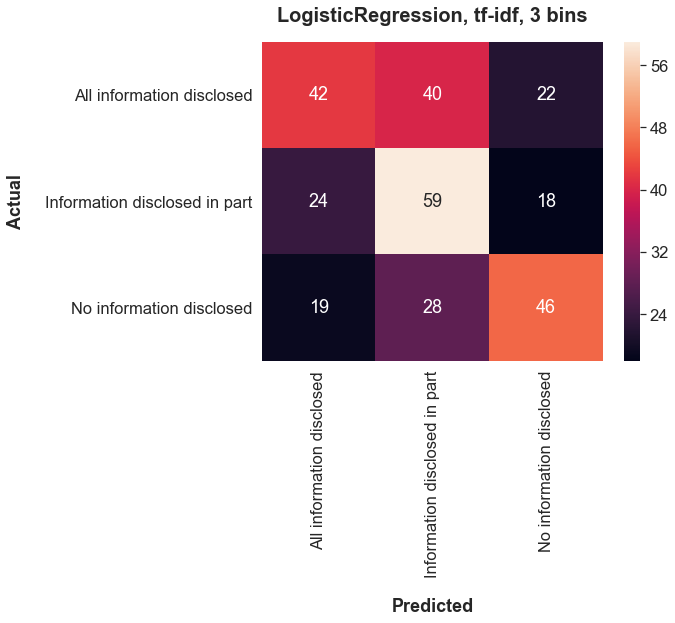

In [446]:
display_confusion_matrix_w_report(y_s_3b_test, tfidf_preds_3b,
                         tokenized_adf, 'Sub_Decision',
                         'LogisticRegression, tf-idf, 3 bins')

## c) Removing cases with less than 15 cases and where a decision was not made

Let's call this dataframe 'independent'. Removing *'Withdrawn'* or *'Abandoned'* leaves us with 757 out of 902 total requests.

In [451]:
tokenized_adf_indep = tokenized_adf_over15.copy()

In [452]:
tokenized_adf_indep = tokenized_adf_indep[tokenized_adf_indep.Decision != 'Request withdrawn']

In [453]:
tokenized_adf_indep = tokenized_adf_indep[tokenized_adf_indep.Decision != 'Abandoned']

In [454]:
print(tokenized_adf_indep['Decision'].value_counts())

All information disclosed        296
Information disclosed in part    282
No records exist                  90
Partly non-existent               36
No information disclosed          33
Transferred                       20
Name: Decision, dtype: int64


In [455]:
len(tokenized_adf_indep)

757

In [456]:
len(tokenized_adf)

902

Indep., CountVec
model_name                              
DecisionTreeClassifier          0.413891
KNeighborsClassifier            0.473341
LinearSVC                       0.469325
LogisticRegression              0.518300
MultinomialNB                   0.426755
RandomForestClassifier          0.475750
SGDClassifier                   0.450651
SVC                             0.480882

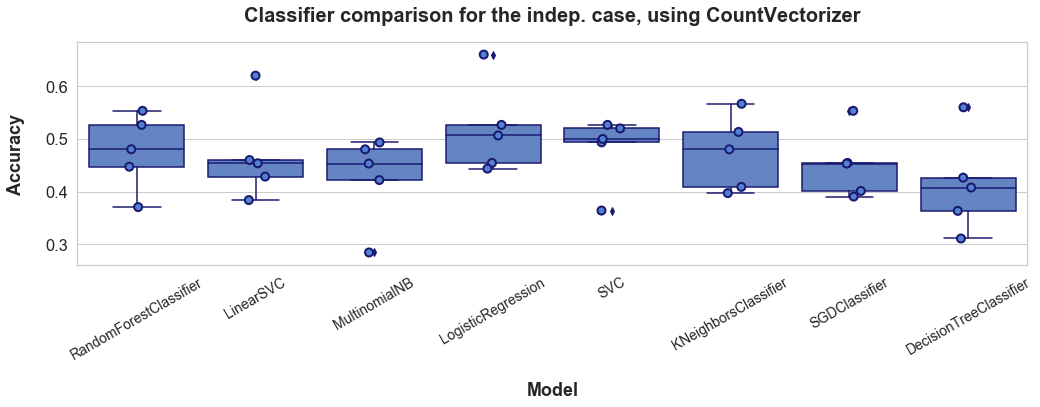

In [457]:
acc_df7 = compare_ML_models(tokenized_adf_indep, 'Edited_Summary', 'Decision', 
              'count_vectorizer', 
              5,
              42,
              False,
              'Classifier comparison for the indep. case, using CountVectorizer', 
              'Indep., CountVec')
accuracy_dfs = add_df_to_accuracy_df(accuracy_dfs, acc_df7)
acc_df7

Indep., tf-idf
model_name                            
DecisionTreeClassifier        0.440009
KNeighborsClassifier          0.456034
LinearSVC                     0.506283
LogisticRegression            0.524767
MultinomialNB                 0.525910
RandomForestClassifier        0.473325
SGDClassifier                 0.455973
SVC                           0.395068

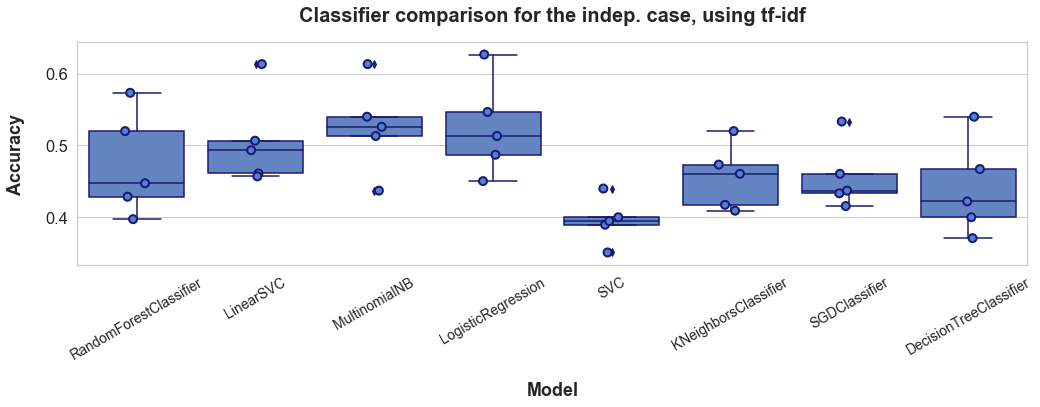

In [458]:
acc_df8 = compare_ML_models(tokenized_adf_indep, 'Edited_Summary', 'Decision', 
              'tfidf_vectorizer', 
              5,
              42,
              False,
              'Classifier comparison for the indep. case, using tf-idf', 
              'Indep., tf-idf')
accuracy_dfs = add_df_to_accuracy_df(accuracy_dfs, acc_df8)
acc_df8

It seems like MultinomialNB with tf-idf does better this time. Let's find the best parameters and take a look at the confusion matrix and the scores.

### GridSearchCv for MultinomialNB - tf-idf

Finding parameters.

In [459]:
y_indep = tokenized_adf_indep['Decision']
X_indep = tokenized_adf_indep['Edited_Summary']
X_indep_train, X_indep_test, y_indep_train, y_indep_test = train_test_split(X_indep, y_indep, 
                                                                            test_size=0.33, random_state=42)

In [460]:
tfidf_vect = TfidfVectorizer()
tfidf_clf = MultinomialNB()
tfidf_pipe = Pipeline([
                      ('vectorizer', tfidf_vect),
                      ('clf', tfidf_clf)
                      ])

parameters = {'vectorizer__ngram_range': [(1, 2), (1, 3), (1, 4)],
              'clf__alpha': (1, 1e-1, 1e-2, 1e-3)
             }

gs_clf = GridSearchCV(tfidf_pipe, parameters, cv=5)
gs_clf_indep = gs_clf.fit(X_indep_train, y_indep_train)

print("For MultinomialNB Classifier with tf-idf:\n")
print("Best score: ", gs_clf_indep.best_score_)
for param_name in sorted(parameters.keys()):
    print("{0}: {1}".format(param_name, gs_clf_indep.best_params_[param_name]))


For MultinomialNB Classifier with tf-idf:

Best score:  0.5384615384615384
clf__alpha: 0.1
vectorizer__ngram_range: (1, 3)


Running our model with the parameters just found.

In [461]:
tfidf_vect = TfidfVectorizer(ngram_range=(1, 4))
tfidf_clf = MultinomialNB(alpha=0.1)
tfidf_pipe.fit(X_indep_train, y_indep_train)
tfidf_preds_indep = tfidf_pipe.predict(X_indep_test)
print("MultinomialNB Accuracy - tfidf - indep:", accuracy_score(y_indep_test, tfidf_preds_indep))

MultinomialNB Accuracy - tfidf - indep: 0.5


Finding confusion matrix and report.

                               precision    recall  f1-score   support

    All information disclosed       0.49      0.55      0.52       104
          Partly non-existent       0.53      0.61      0.57        95
     No information disclosed       0.00      0.00      0.00         3
Information disclosed in part       0.42      0.32      0.36        31
                  Transferred       0.00      0.00      0.00        13
             No records exist       0.00      0.00      0.00         4

                    micro avg       0.50      0.50      0.50       250
                    macro avg       0.24      0.25      0.24       250
                 weighted avg       0.46      0.50      0.48       250



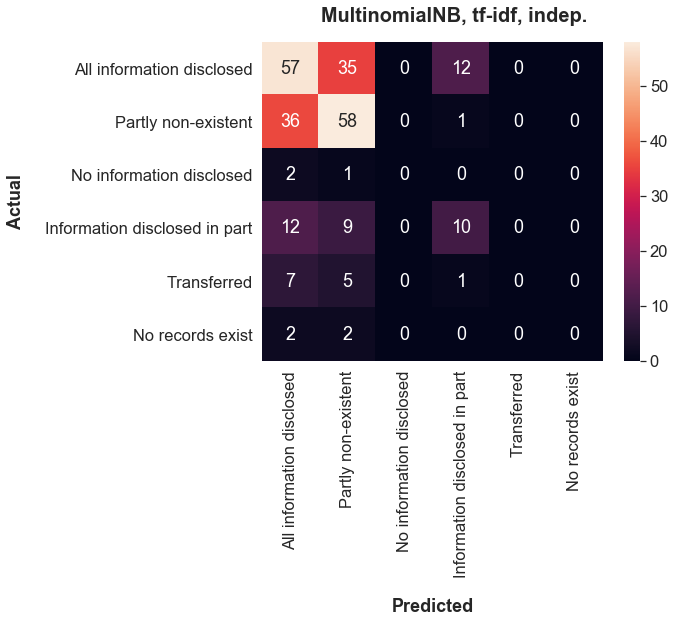

In [462]:
display_confusion_matrix_w_report(y_indep_test, tfidf_preds_indep,
                                  tokenized_adf_indep, 'Decision',
                         '        MultinomialNB, tf-idf, indep.')

And putting all the accuracy scores together, and giving it some *Style* to make the results clearer.

In [463]:
accuracy_dfs

Over-15, CountVec  Over-15, CountVec, bal.  \
model_name                                                           
DecisionTreeClassifier           0.318291                 0.284519   
KNeighborsClassifier             0.371541                 0.371541   
LinearSVC                        0.381662                 0.361455   
LogisticRegression               0.421445                 0.393186   
MultinomialNB                    0.383792                 0.383792   
RandomForestClassifier           0.405277                 0.287557   
SGDClassifier                    0.335278                 0.332016   
SVC                              0.412096                 0.240081   

                        Over-15, tf-idf  Over-15, tf-idf, bal.  \
model_name                                                       
DecisionTreeClassifier         0.332749               0.282058   
KNeighborsClassifier           0.378463               0.378463   
LinearSVC                      0.412230               0.378451   
LogisticRegression             0.439525               0.400023   
MultinomialNB                  0.451982               0.451982   
RandomForestClassifier         0.387260               0.330589   
SGDClassifier                  0.356864               0.320643   
SVC                            0.336029               0.235949   

                        3-bins, CountVec  3-bins, tf-idf  Indep., CountVec  \
model_name                                                                   
DecisionTreeClassifier          0.420319        0.402578          0.413891   
KNeighborsClassifier            0.408072        0.410263          0.473341   
LinearSVC                       0.445819        0.445820          0.469325   
LogisticRegression              0.456894        0.462394          0.518300   
MultinomialNB                   0.465752        0.470147          0.426755   
RandomForestClassifier          0.417911        0.421226          0.475750   
SGDClassifier                   0.430245        0.426912          0.450651   
SVC                             0.454449        0.411238          0.480882   

                        Indep., tf-idf  
model_name                              
DecisionTreeClassifier        0.440009  
KNeighborsClassifier          0.456034  
LinearSVC                     0.506283  
LogisticRegression            0.524767  
MultinomialNB                 0.525910  
RandomForestClassifier        0.473325  
SGDClassifier                 0.455973  
SVC                           0.395068

Adding some functions that will *style* and color the dataframe.

In [464]:
def color_above45_green(val):
    """
    Takes a scalar and returns a string with
    the css property `'color: green'` for above 0.45
    strings, black otherwise.
    """
    color = 'green' if val > 0.45 else 'black'
    return 'color: %s' % color

In [465]:
def highlight_max(s):
    '''
    highlight the maximum in a Series yellow.
    '''
    is_max = s == s.max()
    return ['background-color: yellow' if v else '' for v in is_max]

In [466]:
caption = 'Accuracy score for all the eight models, and 3 different cases\
         (Over-15: over 15 requests, 3-bins: All decisions split into three bins,\
         Indep.: over 15 and w/o Withdrawn and Abandoned.)\
         We also considered two different vectorizers, CountVectorizer (CountVec) and tf-idf.\
         Highest score per case is highlighted in yellow. Scores above 45% are shown in green.'
s = accuracy_dfs.style.\
    applymap(color_above45_green).\
    apply(highlight_max).\
    set_caption(caption)
s

__We see that even though our results are not good (50% is the highest!), in general, for this case, Logistic Regression and Multinomial Naive Bayes classifiers, combined with tf-idf, worked best, as well as reducing the number of 'Decisions'.__

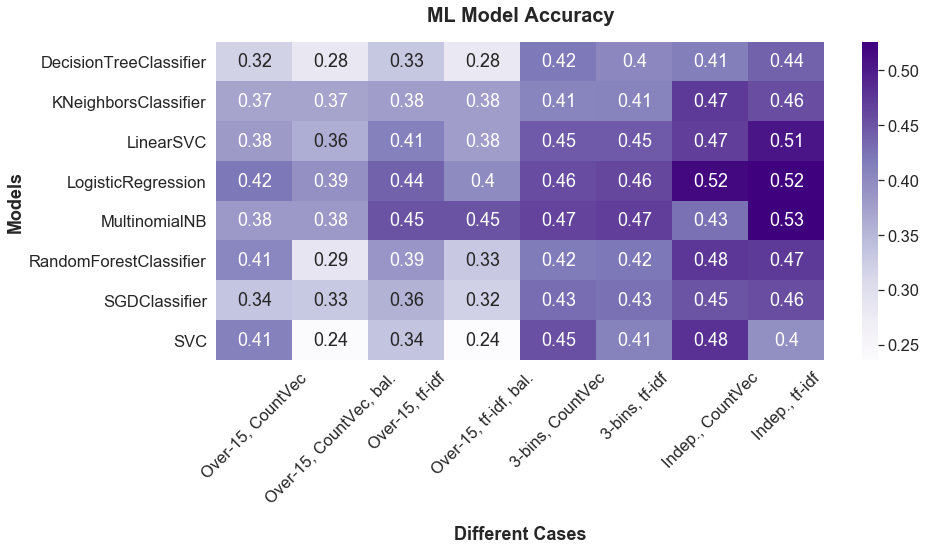

In [468]:
fig, ax = plt.subplots(figsize=(14, 8))
sns.heatmap(accuracy_dfs, annot=True, fmt='0.2g', cmap='Purples', # Purples, PuBu
            xticklabels=accuracy_dfs.columns, yticklabels=accuracy_dfs.index)
plt.ylabel('Models', fontweight='bold', fontsize=18)
plt.xlabel('Different Cases', fontweight='bold', fontsize=18, labelpad=20)
plt.xticks(rotation=45)
ax.set_title(label='ML Model Accuracy', fontweight='bold', size=20, pad=20)
plt.tight_layout()
plt.savefig('./img/ML_model_accuracies_heatmap.png')
plt.savefig('./img/ML_model_accuracies_heatmap.pdf')